# ILR OOD Experiments
Runs experiments of using independent logistic regressors to perform out of distribution detection on SAR images from the sample dataset

Adapted from Nate's SAR ood experiments script

In [54]:
from __future__ import print_function
import numpy as np
import sys
import os
from collections import defaultdict
import random
import torch
import torch.nn as nn
import torch.utils.data as utilsdata
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as tvdatasets
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import copy

# Custom
import models
import create_split
import Dataset_fromPythonList as custom_dset
import helpers
import training_helpers
import ood_helpers
import calculate_log as callog
%matplotlib inline

In [2]:
# Constants
device = 'cuda' if torch.cuda.is_available() else 'cpu'
DSIZE = 64

In [3]:
# Inputs
# Percentage of measured data for training the sample classifier (range = [0,1])
K = float(0)
# Number of classes to hold out as OOD classes (range = [1, 8])
NUM_HOLDOUT_CLASSES = int(1)
dataset_root = "./SAMPLE_dataset/png_images/qpm"
REPEAT_ITERS = 5
DATASETS = ["ID", "holdout"]
SEED = 1234567
random.seed(SEED)
torch.manual_seed(SEED)

# SAMPLE Classifier Learning Params
num_epochs = 60
batch_size = 128
learning_rate_decay_schedule = [50]
learning_rate = 0.001
gamma = 0.1
weight_decay = 0.
dropout = 0.4

# Normalization Constants for range [-1,+1]
MEAN = torch.tensor([0.5], dtype=torch.float32).view([1,1,1]).to(device)
STD = torch.tensor([0.5], dtype=torch.float32).view([1,1,1]).to(device)

In [33]:
# Initialize stat keepers

STAT_accuracy = [[],[],[],[],[],[],[],[],[],[]]
STAT_ood_baseline = [{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
STAT_ood_odin = [{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
STAT_ood_odin_ipp = [{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
STAT_ood_mahala = [{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
STAT_ood_mahala_ipp = [{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
STAT_ilr_accuracy = [[],[],[],[],[],[],[],[],[],[]]
STAT_ilr_ood_baseline = [{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
STAT_ilr_ood_odin = [{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
STAT_ilr_ood_odin_ipp = [{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
STAT_ilr_ood_mahala = [{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]
STAT_ilr_ood_mahala_ipp = [{}, {}, {}, {}, {}, {}, {}, {}, {}, {}, {}]

for hld in range(10):
    for dd in range(1, len(DATASETS)):
        STAT_ood_baseline[hld][DATASETS[dd]] = defaultdict(list)
        STAT_ood_odin[hld][DATASETS[dd]] = defaultdict(list)
        STAT_ood_odin_ipp[hld][DATASETS[dd]] = defaultdict(list)
        STAT_ood_mahala[hld][DATASETS[dd]] = defaultdict(list)
        STAT_ood_mahala_ipp[hld][DATASETS[dd]] = defaultdict(list)
        STAT_ilr_ood_baseline[hld][DATASETS[dd]] = defaultdict(list)
        STAT_ilr_ood_odin[hld][DATASETS[dd]] = defaultdict(list)
        STAT_ilr_ood_odin_ipp[hld][DATASETS[dd]] = defaultdict(list)
        STAT_ilr_ood_mahala[hld][DATASETS[dd]] = defaultdict(list)
        STAT_ilr_ood_mahala_ipp[hld][DATASETS[dd]] = defaultdict(list)

In [34]:
# Dataset setup
full_train_list, full_test_list = create_split.create_mixed_dataset_exp41(
    dataset_root, K)
clsmap = helpers.get_class_mapping_from_dataset_list(full_train_list)

Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):   539


In [35]:
class_counts = torch.zeros((10), dtype=torch.float32).to(device)
for i in full_train_list:
    class_counts[i[1]] += 1
print(class_counts)
print(class_counts.sum())
print(class_counts.sum()- class_counts)
print((class_counts.sum()-class_counts)/class_counts)

tensor([116.,  55.,  43.,  78.,  75.,  76.,  75., 116.,  56., 116.],
       device='cuda:0')
tensor(806., device='cuda:0')
tensor([690., 751., 763., 728., 731., 730., 731., 690., 750., 690.],
       device='cuda:0')
tensor([ 5.9483, 13.6545, 17.7442,  9.3333,  9.7467,  9.6053,  9.7467,  5.9483,
        13.3929,  5.9483], device='cuda:0')


In [36]:
def make_datasets(dataset_root, K, holdout_classes):
    # Dataset setup
    full_train_list, full_test_list = create_split.create_mixed_dataset_exp41(
        dataset_root, K)
    clsmap = helpers.get_class_mapping_from_dataset_list(full_train_list)
    print("ORIGINAL CLASS MAPPING: ", clsmap)
    # Setup holdout classes
    print("HOLDOUT CLASSES: ", holdout_classes)
    remaining_classes = [x for x in list(range(10)) if x not in holdout_classes]
    print("Remaining Classes: ", remaining_classes)

    # Remove holdout class data from the training dataset and reassign labels
    ID_trainlist = []
    for elem in full_train_list:
        if elem[1] in holdout_classes:
            continue
        else:
            ID_trainlist.append([elem[0], remaining_classes.index(elem[1])])
    ID_testlist = []
    OOD_testlist = []
    for elem in full_test_list:
        if elem[1] in holdout_classes:
            OOD_testlist.append([elem[0], 0])
        else:
            ID_testlist.append([elem[0], remaining_classes.index(elem[1])])

    print("# ID Train: ", len(ID_trainlist))
    print("# ID Test: ", len(ID_testlist))
    print("# OOD Test: ", len(OOD_testlist))

    clsmap = helpers.get_class_mapping_from_dataset_list(ID_trainlist)
    print("NEW TRAINING CLASS MAPPING: ", clsmap)
    clsmap = helpers.get_class_mapping_from_dataset_list(ID_testlist)
    print("NEW TESTING CLASS MAPPING: ", clsmap)
    
    class_counts = torch.zeros((10-len(holdout_classes)), dtype=torch.float32).to(device)
    for i in ID_trainlist:
        class_counts[i[1]] += 1
    bce_weights = (class_counts.sum()-class_counts)/class_counts
    
    return ID_trainlist, ID_testlist, OOD_testlist, bce_weights

def getDataloaders(ID_trainlist, ID_testlist, OOD_testlist, batch_size=128):
    # Construct datasets and dataloaders
    data_transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.CenterCrop(DSIZE),
        transforms.ToTensor()
    ])
    ID_trainloader = utilsdata.DataLoader(
        custom_dset.Dataset_fromPythonList(ID_trainlist, transform=data_transform),
        batch_size=batch_size, shuffle=True, num_workers=2, timeout=1000,
    )
    ID_testloader = utilsdata.DataLoader(
        custom_dset.Dataset_fromPythonList(ID_testlist, transform=data_transform),
        batch_size=batch_size, shuffle=False, num_workers=2, timeout=1000,
    )
    OOD_testloader = utilsdata.DataLoader(
        custom_dset.Dataset_fromPythonList(OOD_testlist, transform=data_transform),
        batch_size=batch_size, shuffle=False, num_workers=2, timeout=1000,
    )
    return ID_trainloader, ID_testloader, OOD_testloader
            
    

In [66]:
for cls_method in ['ilr', 'softmax']:
    for holdout in range(10):
        holdout_classes = [holdout]
        for ITER in range(REPEAT_ITERS):
            print(20*"*")
            print("Starting Iter: {}/{} for K={}, J={}, Cls={}, Holdout={}".format(
                ITER, REPEAT_ITERS, K, NUM_HOLDOUT_CLASSES, cls_method, holdout))
            print(20*"*")
            # Make datasets
            ID_trainlist, ID_testlist, OOD_testlist, bce_weights = make_datasets(
                dataset_root, K, holdout_classes)
            ID_trainloader, ID_testloader, OOD_testloader = getDataloaders(
                ID_trainlist, ID_testlist, OOD_testlist, batch_size=batch_size)
            
            # Model Setup
            ilr = (cls_method == 'ilr')
            net = models.resnet18(
                num_classes=10-NUM_HOLDOUT_CLASSES, drop_prob=dropout, ilr=ilr).to(device)
            optimizer = torch.optim.Adam(
                net.parameters(), lr=learning_rate, weight_decay=weight_decay)
            learning_rate_table = helpers.create_learning_rate_table(
                learning_rate, learning_rate_decay_schedule, gamma, num_epochs)
            
            # Training loop
            final_test_acc = 0.
            for epoch in range(num_epochs):
                # Decay learning rate according to decay schedule
                helpers.adjust_learning_rate(optimizer, epoch, learning_rate_table)
                print("Starting Epoch {}/{}. lr = {}".format(
                    epoch, num_epochs, learning_rate_table[epoch]))
                # Train
                train_acc, train_loss, percent_real = training_helpers.train_model(
                    net, optimizer, ID_trainloader, 10-NUM_HOLDOUT_CLASSES, bce_weights)
                print("[{}] Epoch [{}/{}]; lr: {} TrainAccuracy: {:.5f} TrainLoss: {:.5f} %-Real: {}".format(
                    ITER, epoch, num_epochs, learning_rate_table[epoch],
                    train_acc, train_loss, percent_real))
                # Test
                test_acc, test_loss = helpers.test_model(net, device,  ID_testloader, MEAN, STD)
                print("\t[{}] Epoch [{}/{}]; TestAccuracy: {:.5f} TestLoss: {:.5f}".format(
                    ITER, epoch, num_epochs, test_acc, test_loss))
                final_test_acc = test_acc
            if cls_method == 'ilr':
                STAT_ilr_accuracy[holdout].append(final_test_acc)
            else:
                STAT_accuracy[holdout].append(final_test_acc)
            net.eval()

            MAHALA_LAYER_SET = [
                "resnet18_2",
                "resnet18_2_2",
                "resnet18_2_2_2",
                "resnet18_2_2_2_2",
            ]

            hooked_activation_dict={}; hook_handles = []
            def get_activation(name):
                def hook(module, input, output):
                    hooked_activation_dict[name]=output
                return hook
            for l in MAHALA_LAYER_SET:
                hook_handles.append(ood_helpers.set_model_hook(l, net, get_activation(l), device))
            with torch.no_grad():
                dd = torch.zeros(1,1,64,64).uniform_().to(device)
                net(dd)
                dd = None
            for l in MAHALA_LAYER_SET:
                print("Hooked Layer: {}; Shape: {}; Min: {}; Max: {}".format(
                    l,hooked_activation_dict[l].shape,
                    hooked_activation_dict[l].min(),
                    hooked_activation_dict[l].max()))

            ### Calculate means and covariance stats for Mahalanobis detector

            layer_means, layer_precisions = ood_helpers.compute_empirical_means_and_precision(
                net, hooked_activation_dict, MAHALA_LAYER_SET,
                ID_trainloader, 10-NUM_HOLDOUT_CLASSES)

            ### Measure OOD scores with state-of-the-art methods

            baseline_scores_dict = {}
            odin_scores_dict = {}
            odin_ipp_scores_dict = {}
            mahala_scores_dict = {}
            mahala_ipp_scores_dict = {}

            for dset in DATASETS:
                print("Computing OOD scores for {}...".format(dset))
                currloader = None
                if dset == "ID":
                    currloader = ID_testloader
                elif dset == "holdout":
                    currloader = OOD_testloader
                else:
                    currloader = ood_helpers.get_ood_dataloader(dset,DSIZE,bsize=128,shuf=False)

                ##### COMPUTE OOD SCORES FOR THIS DATASET
                base_scores,odin_scores,odin_ipp_scores = \
                    ood_helpers.generate_ood_scores_ODIN_and_BASELINE(
                        net, currloader, 1000., MEAN, STD, IPP=True, eps=0.01)
                mahalanobis_scores,mahalanobis_ipp_scores = \
                    ood_helpers.generate_ood_scores_MAHALANOBIS(
                    net, currloader, hooked_activation_dict, MAHALA_LAYER_SET,
                    layer_means, layer_precisions, MEAN, STD, IPP=True, eps=0.01)

                # Save raw OOD scores into dictionaries
                baseline_scores_dict[dset] = base_scores
                odin_scores_dict[dset] = odin_scores
                odin_ipp_scores_dict[dset] = odin_ipp_scores
                mahala_scores_dict[dset] = mahalanobis_scores
                mahala_ipp_scores_dict[dset] = mahalanobis_ipp_scores

            # Compute all OOD statistics for this model over all the tested datasets
            print("Computing OOD Statistics...")
            for dd in range(1,len(DATASETS)):
                print("** DATASET: {} **".format(DATASETS[dd]))

                metric_results = callog.metric(
                    np.array(baseline_scores_dict["ID"]) ,
                    np.array(baseline_scores_dict[DATASETS[dd]]) )
                print("\tBaseline.   AUROC: {:.4f}. TNR@95TPR: {:.4f}. DetAcc: {:.4f}".format(
                    metric_results['TMP']['AUROC'],
                    metric_results['TMP']['TNR'],
                    metric_results['TMP']['DTACC'],
                ))
                if cls_method == 'ilr':
                    STAT_ilr_ood_baseline[holdout][DATASETS[dd]]["auroc"].append(
                        metric_results['TMP']['AUROC'])
                    STAT_ilr_ood_baseline[holdout][DATASETS[dd]]["tnr"].append(
                        metric_results['TMP']['TNR'])
                    STAT_ilr_ood_baseline[holdout][DATASETS[dd]]["dtacc"].append(
                        metric_results['TMP']['DTACC'])
                else:                                                                                                                                              
                    STAT_ood_baseline[holdout][DATASETS[dd]]["auroc"].append(
                        metric_results['TMP']['AUROC'])
                    STAT_ood_baseline[holdout][DATASETS[dd]]["tnr"].append(
                        metric_results['TMP']['TNR'])
                    STAT_ood_baseline[holdout][DATASETS[dd]]["dtacc"].append(
                         metric_results['TMP']['DTACC'])

                metric_results = callog.metric(
                    np.array(odin_scores_dict["ID"]) ,
                    np.array(odin_scores_dict[DATASETS[dd]]) )
                print("\tODIN (T=1000).     AUROC: {:.4f}. TNR@95TPR: {:.4f}. DetAcc: {:.4f}".format(
                    metric_results['TMP']['AUROC'],
                    metric_results['TMP']['TNR'],
                    metric_results['TMP']['DTACC'],
                ))
                if cls_method == 'ilr':
                    STAT_ilr_ood_odin[holdout][DATASETS[dd]]["auroc"].append(
                        metric_results['TMP']['AUROC'] )
                    STAT_ilr_ood_odin[holdout][DATASETS[dd]]["tnr"].append(
                        metric_results['TMP']['TNR'] )
                    STAT_ilr_ood_odin[holdout][DATASETS[dd]]["dtacc"].append(
                        metric_results['TMP']['DTACC'] )
                else:                                                                                                                                              
                    STAT_ood_odin[holdout][DATASETS[dd]]["auroc"].append(
                        metric_results['TMP']['AUROC'] )
                    STAT_ood_odin[holdout][DATASETS[dd]]["tnr"].append(
                        metric_results['TMP']['TNR'] )
                    STAT_ood_odin[holdout][DATASETS[dd]]["dtacc"].append(
                        metric_results['TMP']['DTACC'] )

                metric_results = callog.metric(
                    np.array(mahala_scores_dict["ID"]) ,
                    np.array(mahala_scores_dict[DATASETS[dd]]) )
                print("\tMahalanobis.       AUROC: {:.4f}. TNR@95TPR: {:.4f}. DetAcc: {:.4f}".format(
                    metric_results['TMP']['AUROC'],
                    metric_results['TMP']['TNR'],
                    metric_results['TMP']['DTACC'],
                ))
                if cls_method == 'ilr':
                    STAT_ilr_ood_mahala[holdout][DATASETS[dd]]["auroc"].append(
                        metric_results['TMP']['AUROC'] )
                    STAT_ilr_ood_mahala[holdout][DATASETS[dd]]["tnr"].append(
                        metric_results['TMP']['TNR'] )
                    STAT_ilr_ood_mahala[holdout][DATASETS[dd]]["dtacc"].append(
                        metric_results['TMP']['DTACC'] )
                else:
                    STAT_ood_mahala[holdout][DATASETS[dd]]["auroc"].append(
                        metric_results['TMP']['AUROC'] )
                    STAT_ood_mahala[holdout][DATASETS[dd]]["tnr"].append(
                        metric_results['TMP']['TNR'] )
                    STAT_ood_mahala[holdout][DATASETS[dd]]["dtacc"].append(
                        metric_results['TMP']['DTACC'] )

                metric_results = callog.metric(
                    np.array(odin_ipp_scores_dict["ID"]) ,
                    np.array(odin_ipp_scores_dict[DATASETS[dd]]) )
                print("\tODIN (T=1000) IPP. AUROC: {:.4f}. TNR@95TPR: {:.4f}. DetAcc: {:.4f}".format(
                    metric_results['TMP']['AUROC'],
                    metric_results['TMP']['TNR'],
                    metric_results['TMP']['DTACC'],
                ))
                if cls_method == 'ilr':
                    STAT_ilr_ood_odin_ipp[holdout][DATASETS[dd]]["auroc"].append(
                        metric_results['TMP']['AUROC'] )
                    STAT_ilr_ood_odin_ipp[holdout][DATASETS[dd]]["tnr"].append(
                        metric_results['TMP']['TNR'] )
                    STAT_ilr_ood_odin_ipp[holdout][DATASETS[dd]]["dtacc"].append(
                        metric_results['TMP']['DTACC'] )
                else:
                    STAT_ood_odin_ipp[holdout][DATASETS[dd]]["auroc"].append(
                        metric_results['TMP']['AUROC'] )
                    STAT_ood_odin_ipp[holdout][DATASETS[dd]]["tnr"].append(
                        metric_results['TMP']['TNR'] )
                    STAT_ood_odin_ipp[holdout][DATASETS[dd]]["dtacc"].append(
                        metric_results['TMP']['DTACC'] )

                metric_results = callog.metric(
                    np.array(mahala_ipp_scores_dict["ID"]) ,
                    np.array(mahala_ipp_scores_dict[DATASETS[dd]]) )
                print("\tMahalanobis IPP.   AUROC: {:.4f}. TNR@95TPR: {:.4f}. DetAcc: {:.4f}".format(                                                              
                    metric_results['TMP']['AUROC'],                                                                                                                
                    metric_results['TMP']['TNR'],                                                                                                                  
                    metric_results['TMP']['DTACC'],                                                                                                                
                ))                                                                                                                                                 
                if cls_method == 'ilr':                                                                                                                            
                    STAT_ilr_ood_mahala_ipp[holdout][DATASETS[dd]]["auroc"].append(
                        metric_results['TMP']['AUROC'] )
                    STAT_ilr_ood_mahala_ipp[holdout][DATASETS[dd]]["tnr"].append(
                        metric_results['TMP']['TNR'] )
                    STAT_ilr_ood_mahala_ipp[holdout][DATASETS[dd]]["dtacc"].append(
                        metric_results['TMP']['DTACC'] )
                else:
                    STAT_ood_mahala_ipp[holdout][DATASETS[dd]]["auroc"].append(
                        metric_results['TMP']['AUROC'] )
                    STAT_ood_mahala_ipp[holdout][DATASETS[dd]]["tnr"].append(
                        metric_results['TMP']['TNR'] )
                    STAT_ood_mahala_ipp[holdout][DATASETS[dd]]["dtacc"].append(
                        metric_results['TMP']['DTACC'] )

********************
Starting Iter: 0/5 for K=0.0, J=1, Cls=ilr, Holdout=0
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):   539
ORIGINAL CLASS MAPPING:  {0: '2s1', 1: 'bmp2', 2: 'btr70', 3: 'm1', 4: 'm2', 5: 'm35', 6: 'm548', 7: 'm60', 8: 't72', 9: 'zsu23'}
HOLDOUT CLASSES:  [0]
Remaining Classes:  [1, 2, 3, 4, 5, 6, 7, 8, 9]
# ID Train:  690
# ID Test:  481
# OOD Test:  58
NEW TRAINING CLASS MAPPING:  {0: 'bmp2', 1: 'btr70', 2: 'm1', 3: 'm2', 4: 'm35', 5: 'm548', 6: 'm60', 7: 't72', 8: 'zsu23'}
NEW TESTING CLASS MAPPING:  {0: 'bmp2', 1: 'btr

	[0] Epoch [40/60]; TestAccuracy: 0.88981 TestLoss: 0.65830
Starting Epoch 41/60. lr = 0.001
[0] Epoch [41/60]; lr: 0.001 TrainAccuracy: 0.96232 TrainLoss: 0.05848 %-Real: 0.0
	[0] Epoch [41/60]; TestAccuracy: 0.92308 TestLoss: 0.34729
Starting Epoch 42/60. lr = 0.001
[0] Epoch [42/60]; lr: 0.001 TrainAccuracy: 0.96232 TrainLoss: 0.06988 %-Real: 0.0
	[0] Epoch [42/60]; TestAccuracy: 0.93139 TestLoss: 0.30906
Starting Epoch 43/60. lr = 0.001
[0] Epoch [43/60]; lr: 0.001 TrainAccuracy: 0.96957 TrainLoss: 0.06426 %-Real: 0.0
	[0] Epoch [43/60]; TestAccuracy: 0.90021 TestLoss: 0.46286
Starting Epoch 44/60. lr = 0.001
[0] Epoch [44/60]; lr: 0.001 TrainAccuracy: 0.95797 TrainLoss: 0.08071 %-Real: 0.0
	[0] Epoch [44/60]; TestAccuracy: 0.94387 TestLoss: 0.20618
Starting Epoch 45/60. lr = 0.001
[0] Epoch [45/60]; lr: 0.001 TrainAccuracy: 0.97391 TrainLoss: 0.06725 %-Real: 0.0
	[0] Epoch [45/60]; TestAccuracy: 0.94179 TestLoss: 0.21573
Starting Epoch 46/60. lr = 0.001
[0] Epoch [46/60]; lr: 0.00

[1] Epoch [12/60]; lr: 0.001 TrainAccuracy: 0.78986 TrainLoss: 0.28683 %-Real: 0.0
	[1] Epoch [12/60]; TestAccuracy: 0.72557 TestLoss: 0.84510
Starting Epoch 13/60. lr = 0.001
[1] Epoch [13/60]; lr: 0.001 TrainAccuracy: 0.84203 TrainLoss: 0.24251 %-Real: 0.0
	[1] Epoch [13/60]; TestAccuracy: 0.61954 TestLoss: 1.49702
Starting Epoch 14/60. lr = 0.001
[1] Epoch [14/60]; lr: 0.001 TrainAccuracy: 0.90290 TrainLoss: 0.17956 %-Real: 0.0
	[1] Epoch [14/60]; TestAccuracy: 0.69023 TestLoss: 1.36545
Starting Epoch 15/60. lr = 0.001
[1] Epoch [15/60]; lr: 0.001 TrainAccuracy: 0.88986 TrainLoss: 0.19769 %-Real: 0.0
	[1] Epoch [15/60]; TestAccuracy: 0.75468 TestLoss: 0.95099
Starting Epoch 16/60. lr = 0.001
[1] Epoch [16/60]; lr: 0.001 TrainAccuracy: 0.90870 TrainLoss: 0.14949 %-Real: 0.0
	[1] Epoch [16/60]; TestAccuracy: 0.72765 TestLoss: 1.37539
Starting Epoch 17/60. lr = 0.001
[1] Epoch [17/60]; lr: 0.001 TrainAccuracy: 0.92319 TrainLoss: 0.14983 %-Real: 0.0
	[1] Epoch [17/60]; TestAccuracy: 0.8

	[1] Epoch [58/60]; TestAccuracy: 0.93971 TestLoss: 0.28918
Starting Epoch 59/60. lr = 0.0001
[1] Epoch [59/60]; lr: 0.0001 TrainAccuracy: 0.99275 TrainLoss: 0.01330 %-Real: 0.0
	[1] Epoch [59/60]; TestAccuracy: 0.94179 TestLoss: 0.31113
Hooked Layer: resnet18_2; Shape: torch.Size([1, 64, 16, 16]); Min: -7.154580116271973; Max: 15.717583656311035
Hooked Layer: resnet18_2_2; Shape: torch.Size([1, 128, 8, 8]); Min: -5.921173572540283; Max: 11.51736068725586
Hooked Layer: resnet18_2_2_2; Shape: torch.Size([1, 256, 4, 4]); Min: -3.349778175354004; Max: 7.628495216369629
Hooked Layer: resnet18_2_2_2_2; Shape: torch.Size([1, 512, 2, 2]); Min: -1.6213959455490112; Max: 5.808248519897461
Computing sample matrix...
Computing class means...
Computing precision matrices...
Layer resnet18_2. Reps.size: torch.Size([690, 64]). Lbls.size: torch.Size([690]). ClassMean.size: torch.Size([9, 64]). PrecisionMat.size: torch.Size([64, 64])
Layer resnet18_2_2. Reps.size: torch.Size([690, 128]). Lbls.size: to

[2] Epoch [30/60]; lr: 0.001 TrainAccuracy: 0.97681 TrainLoss: 0.04513 %-Real: 0.0
	[2] Epoch [30/60]; TestAccuracy: 0.91268 TestLoss: 0.32717
Starting Epoch 31/60. lr = 0.001
[2] Epoch [31/60]; lr: 0.001 TrainAccuracy: 0.97971 TrainLoss: 0.06335 %-Real: 0.0
	[2] Epoch [31/60]; TestAccuracy: 0.92516 TestLoss: 0.25012
Starting Epoch 32/60. lr = 0.001
[2] Epoch [32/60]; lr: 0.001 TrainAccuracy: 0.97536 TrainLoss: 0.04988 %-Real: 0.0
	[2] Epoch [32/60]; TestAccuracy: 0.85239 TestLoss: 0.71299
Starting Epoch 33/60. lr = 0.001
[2] Epoch [33/60]; lr: 0.001 TrainAccuracy: 0.96377 TrainLoss: 0.05872 %-Real: 0.0
	[2] Epoch [33/60]; TestAccuracy: 0.89189 TestLoss: 0.67380
Starting Epoch 34/60. lr = 0.001
[2] Epoch [34/60]; lr: 0.001 TrainAccuracy: 0.97391 TrainLoss: 0.05134 %-Real: 0.0
	[2] Epoch [34/60]; TestAccuracy: 0.88981 TestLoss: 0.59526
Starting Epoch 35/60. lr = 0.001
[2] Epoch [35/60]; lr: 0.001 TrainAccuracy: 0.97681 TrainLoss: 0.04700 %-Real: 0.0
	[2] Epoch [35/60]; TestAccuracy: 0.9

[3] Epoch [1/60]; lr: 0.001 TrainAccuracy: 0.21449 TrainLoss: 1.19208 %-Real: 0.0
	[3] Epoch [1/60]; TestAccuracy: 0.11019 TestLoss: 2.24711
Starting Epoch 2/60. lr = 0.001
[3] Epoch [2/60]; lr: 0.001 TrainAccuracy: 0.30725 TrainLoss: 1.02187 %-Real: 0.0
	[3] Epoch [2/60]; TestAccuracy: 0.16840 TestLoss: 2.24923
Starting Epoch 3/60. lr = 0.001
[3] Epoch [3/60]; lr: 0.001 TrainAccuracy: 0.40000 TrainLoss: 0.89876 %-Real: 0.0
	[3] Epoch [3/60]; TestAccuracy: 0.18295 TestLoss: 2.08252
Starting Epoch 4/60. lr = 0.001
[3] Epoch [4/60]; lr: 0.001 TrainAccuracy: 0.53043 TrainLoss: 0.71002 %-Real: 0.0
	[3] Epoch [4/60]; TestAccuracy: 0.23077 TestLoss: 1.99009
Starting Epoch 5/60. lr = 0.001
[3] Epoch [5/60]; lr: 0.001 TrainAccuracy: 0.66232 TrainLoss: 0.55825 %-Real: 0.0
	[3] Epoch [5/60]; TestAccuracy: 0.33264 TestLoss: 1.93355
Starting Epoch 6/60. lr = 0.001
[3] Epoch [6/60]; lr: 0.001 TrainAccuracy: 0.66957 TrainLoss: 0.48162 %-Real: 0.0
	[3] Epoch [6/60]; TestAccuracy: 0.37838 TestLoss: 1.

[3] Epoch [48/60]; lr: 0.001 TrainAccuracy: 0.99275 TrainLoss: 0.02054 %-Real: 0.0
	[3] Epoch [48/60]; TestAccuracy: 0.93763 TestLoss: 0.32181
Starting Epoch 49/60. lr = 0.001
[3] Epoch [49/60]; lr: 0.001 TrainAccuracy: 0.98841 TrainLoss: 0.03212 %-Real: 0.0
	[3] Epoch [49/60]; TestAccuracy: 0.92308 TestLoss: 0.34248
Starting Epoch 50/60. lr = 0.0001
[3] Epoch [50/60]; lr: 0.0001 TrainAccuracy: 0.98116 TrainLoss: 0.03427 %-Real: 0.0
	[3] Epoch [50/60]; TestAccuracy: 0.93971 TestLoss: 0.23885
Starting Epoch 51/60. lr = 0.0001
[3] Epoch [51/60]; lr: 0.0001 TrainAccuracy: 0.98551 TrainLoss: 0.03078 %-Real: 0.0
	[3] Epoch [51/60]; TestAccuracy: 0.94802 TestLoss: 0.19332
Starting Epoch 52/60. lr = 0.0001
[3] Epoch [52/60]; lr: 0.0001 TrainAccuracy: 0.99130 TrainLoss: 0.02023 %-Real: 0.0
	[3] Epoch [52/60]; TestAccuracy: 0.95218 TestLoss: 0.17677
Starting Epoch 53/60. lr = 0.0001
[3] Epoch [53/60]; lr: 0.0001 TrainAccuracy: 0.99130 TrainLoss: 0.01670 %-Real: 0.0
	[3] Epoch [53/60]; TestAccur

	[4] Epoch [19/60]; TestAccuracy: 0.84823 TestLoss: 0.67963
Starting Epoch 20/60. lr = 0.001
[4] Epoch [20/60]; lr: 0.001 TrainAccuracy: 0.95652 TrainLoss: 0.08938 %-Real: 0.0
	[4] Epoch [20/60]; TestAccuracy: 0.88773 TestLoss: 0.42284
Starting Epoch 21/60. lr = 0.001
[4] Epoch [21/60]; lr: 0.001 TrainAccuracy: 0.93913 TrainLoss: 0.12617 %-Real: 0.0
	[4] Epoch [21/60]; TestAccuracy: 0.87318 TestLoss: 0.61560
Starting Epoch 22/60. lr = 0.001
[4] Epoch [22/60]; lr: 0.001 TrainAccuracy: 0.95072 TrainLoss: 0.09412 %-Real: 0.0
	[4] Epoch [22/60]; TestAccuracy: 0.85447 TestLoss: 0.71023
Starting Epoch 23/60. lr = 0.001
[4] Epoch [23/60]; lr: 0.001 TrainAccuracy: 0.95942 TrainLoss: 0.07304 %-Real: 0.0
	[4] Epoch [23/60]; TestAccuracy: 0.85031 TestLoss: 0.70790
Starting Epoch 24/60. lr = 0.001
[4] Epoch [24/60]; lr: 0.001 TrainAccuracy: 0.97391 TrainLoss: 0.05743 %-Real: 0.0
	[4] Epoch [24/60]; TestAccuracy: 0.86486 TestLoss: 0.68143
Starting Epoch 25/60. lr = 0.001
[4] Epoch [25/60]; lr: 0.00

Computing OOD scores for holdout...
Computing OOD Statistics...
** DATASET: holdout **
	Baseline.   AUROC: 0.8248. TNR@95TPR: 0.1379. DetAcc: 0.7839
	ODIN (T=1000).     AUROC: 0.7959. TNR@95TPR: 0.1379. DetAcc: 0.7748
	Mahalanobis.       AUROC: 0.8293. TNR@95TPR: 0.2241. DetAcc: 0.7673
	ODIN (T=1000) IPP. AUROC: 0.7970. TNR@95TPR: 0.1379. DetAcc: 0.7659
	Mahalanobis IPP.   AUROC: 0.7925. TNR@95TPR: 0.2931. DetAcc: 0.7211
********************
Starting Iter: 0/5 for K=0.0, J=1, Cls=ilr, Holdout=1
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):  

	[0] Epoch [38/60]; TestAccuracy: 0.84189 TestLoss: 0.98186
Starting Epoch 39/60. lr = 0.001
[0] Epoch [39/60]; lr: 0.001 TrainAccuracy: 0.98003 TrainLoss: 0.04228 %-Real: 0.0
	[0] Epoch [39/60]; TestAccuracy: 0.90144 TestLoss: 0.41057
Starting Epoch 40/60. lr = 0.001
[0] Epoch [40/60]; lr: 0.001 TrainAccuracy: 0.97603 TrainLoss: 0.04555 %-Real: 0.0
	[0] Epoch [40/60]; TestAccuracy: 0.90965 TestLoss: 0.46797
Starting Epoch 41/60. lr = 0.001
[0] Epoch [41/60]; lr: 0.001 TrainAccuracy: 0.98802 TrainLoss: 0.02641 %-Real: 0.0
	[0] Epoch [41/60]; TestAccuracy: 0.91376 TestLoss: 0.41564
Starting Epoch 42/60. lr = 0.001
[0] Epoch [42/60]; lr: 0.001 TrainAccuracy: 0.98402 TrainLoss: 0.02711 %-Real: 0.0
	[0] Epoch [42/60]; TestAccuracy: 0.85832 TestLoss: 0.92490
Starting Epoch 43/60. lr = 0.001
[0] Epoch [43/60]; lr: 0.001 TrainAccuracy: 0.98269 TrainLoss: 0.04900 %-Real: 0.0
	[0] Epoch [43/60]; TestAccuracy: 0.89733 TestLoss: 0.54329
Starting Epoch 44/60. lr = 0.001
[0] Epoch [44/60]; lr: 0.00

[1] Epoch [10/60]; lr: 0.001 TrainAccuracy: 0.81092 TrainLoss: 0.27008 %-Real: 0.0
	[1] Epoch [10/60]; TestAccuracy: 0.69610 TestLoss: 1.16060
Starting Epoch 11/60. lr = 0.001
[1] Epoch [11/60]; lr: 0.001 TrainAccuracy: 0.86152 TrainLoss: 0.24903 %-Real: 0.0
	[1] Epoch [11/60]; TestAccuracy: 0.72485 TestLoss: 1.07843
Starting Epoch 12/60. lr = 0.001
[1] Epoch [12/60]; lr: 0.001 TrainAccuracy: 0.85619 TrainLoss: 0.22315 %-Real: 0.0
	[1] Epoch [12/60]; TestAccuracy: 0.73101 TestLoss: 0.94013
Starting Epoch 13/60. lr = 0.001
[1] Epoch [13/60]; lr: 0.001 TrainAccuracy: 0.87217 TrainLoss: 0.19762 %-Real: 0.0
	[1] Epoch [13/60]; TestAccuracy: 0.74743 TestLoss: 1.21383
Starting Epoch 14/60. lr = 0.001
[1] Epoch [14/60]; lr: 0.001 TrainAccuracy: 0.89481 TrainLoss: 0.17927 %-Real: 0.0
	[1] Epoch [14/60]; TestAccuracy: 0.77002 TestLoss: 1.09942
Starting Epoch 15/60. lr = 0.001
[1] Epoch [15/60]; lr: 0.001 TrainAccuracy: 0.91212 TrainLoss: 0.15137 %-Real: 0.0
	[1] Epoch [15/60]; TestAccuracy: 0.8

	[1] Epoch [56/60]; TestAccuracy: 0.93018 TestLoss: 0.38302
Starting Epoch 57/60. lr = 0.0001
[1] Epoch [57/60]; lr: 0.0001 TrainAccuracy: 0.99201 TrainLoss: 0.01617 %-Real: 0.0
	[1] Epoch [57/60]; TestAccuracy: 0.92813 TestLoss: 0.38975
Starting Epoch 58/60. lr = 0.0001
[1] Epoch [58/60]; lr: 0.0001 TrainAccuracy: 0.98402 TrainLoss: 0.02081 %-Real: 0.0
	[1] Epoch [58/60]; TestAccuracy: 0.92813 TestLoss: 0.39310
Starting Epoch 59/60. lr = 0.0001
[1] Epoch [59/60]; lr: 0.0001 TrainAccuracy: 0.98935 TrainLoss: 0.01733 %-Real: 0.0
	[1] Epoch [59/60]; TestAccuracy: 0.92813 TestLoss: 0.41058
Hooked Layer: resnet18_2; Shape: torch.Size([1, 64, 16, 16]); Min: -7.160073757171631; Max: 16.8005428314209
Hooked Layer: resnet18_2_2; Shape: torch.Size([1, 128, 8, 8]); Min: -4.7674078941345215; Max: 11.097150802612305
Hooked Layer: resnet18_2_2_2; Shape: torch.Size([1, 256, 4, 4]); Min: -2.8038511276245117; Max: 7.607603073120117
Hooked Layer: resnet18_2_2_2_2; Shape: torch.Size([1, 512, 2, 2]); Min

[2] Epoch [28/60]; lr: 0.001 TrainAccuracy: 0.96937 TrainLoss: 0.04710 %-Real: 0.0
	[2] Epoch [28/60]; TestAccuracy: 0.89322 TestLoss: 0.81769
Starting Epoch 29/60. lr = 0.001
[2] Epoch [29/60]; lr: 0.001 TrainAccuracy: 0.96538 TrainLoss: 0.05926 %-Real: 0.0
	[2] Epoch [29/60]; TestAccuracy: 0.88706 TestLoss: 0.48488
Starting Epoch 30/60. lr = 0.001
[2] Epoch [30/60]; lr: 0.001 TrainAccuracy: 0.96671 TrainLoss: 0.05539 %-Real: 0.0
	[2] Epoch [30/60]; TestAccuracy: 0.84189 TestLoss: 0.75227
Starting Epoch 31/60. lr = 0.001
[2] Epoch [31/60]; lr: 0.001 TrainAccuracy: 0.98535 TrainLoss: 0.03516 %-Real: 0.0
	[2] Epoch [31/60]; TestAccuracy: 0.89528 TestLoss: 0.44088
Starting Epoch 32/60. lr = 0.001
[2] Epoch [32/60]; lr: 0.001 TrainAccuracy: 0.97204 TrainLoss: 0.04894 %-Real: 0.0
	[2] Epoch [32/60]; TestAccuracy: 0.87064 TestLoss: 0.62640
Starting Epoch 33/60. lr = 0.001
[2] Epoch [33/60]; lr: 0.001 TrainAccuracy: 0.98003 TrainLoss: 0.03626 %-Real: 0.0
	[2] Epoch [33/60]; TestAccuracy: 0.8

[3] Epoch [0/60]; lr: 0.001 TrainAccuracy: 0.10919 TrainLoss: 1.31848 %-Real: 0.0
	[3] Epoch [0/60]; TestAccuracy: 0.12731 TestLoss: 2.22995
Starting Epoch 1/60. lr = 0.001
[3] Epoch [1/60]; lr: 0.001 TrainAccuracy: 0.20107 TrainLoss: 1.23310 %-Real: 0.0
	[3] Epoch [1/60]; TestAccuracy: 0.10472 TestLoss: 2.32622
Starting Epoch 2/60. lr = 0.001
[3] Epoch [2/60]; lr: 0.001 TrainAccuracy: 0.25699 TrainLoss: 1.05693 %-Real: 0.0
	[3] Epoch [2/60]; TestAccuracy: 0.16632 TestLoss: 2.26094
Starting Epoch 3/60. lr = 0.001
[3] Epoch [3/60]; lr: 0.001 TrainAccuracy: 0.37150 TrainLoss: 0.91982 %-Real: 0.0
	[3] Epoch [3/60]; TestAccuracy: 0.16632 TestLoss: 2.15836
Starting Epoch 4/60. lr = 0.001
[3] Epoch [4/60]; lr: 0.001 TrainAccuracy: 0.44740 TrainLoss: 0.76520 %-Real: 0.0
	[3] Epoch [4/60]; TestAccuracy: 0.12115 TestLoss: 2.15961
Starting Epoch 5/60. lr = 0.001
[3] Epoch [5/60]; lr: 0.001 TrainAccuracy: 0.58722 TrainLoss: 0.62250 %-Real: 0.0
	[3] Epoch [5/60]; TestAccuracy: 0.35934 TestLoss: 1.

[3] Epoch [47/60]; lr: 0.001 TrainAccuracy: 0.98402 TrainLoss: 0.03618 %-Real: 0.0
	[3] Epoch [47/60]; TestAccuracy: 0.91786 TestLoss: 0.38158
Starting Epoch 48/60. lr = 0.001
[3] Epoch [48/60]; lr: 0.001 TrainAccuracy: 0.98802 TrainLoss: 0.02452 %-Real: 0.0
	[3] Epoch [48/60]; TestAccuracy: 0.91376 TestLoss: 0.39709
Starting Epoch 49/60. lr = 0.001
[3] Epoch [49/60]; lr: 0.001 TrainAccuracy: 0.97204 TrainLoss: 0.03137 %-Real: 0.0
	[3] Epoch [49/60]; TestAccuracy: 0.90965 TestLoss: 0.41283
Starting Epoch 50/60. lr = 0.0001
[3] Epoch [50/60]; lr: 0.0001 TrainAccuracy: 0.99201 TrainLoss: 0.01622 %-Real: 0.0
	[3] Epoch [50/60]; TestAccuracy: 0.91992 TestLoss: 0.38788
Starting Epoch 51/60. lr = 0.0001
[3] Epoch [51/60]; lr: 0.0001 TrainAccuracy: 0.98935 TrainLoss: 0.01950 %-Real: 0.0
	[3] Epoch [51/60]; TestAccuracy: 0.92813 TestLoss: 0.36332
Starting Epoch 52/60. lr = 0.0001
[3] Epoch [52/60]; lr: 0.0001 TrainAccuracy: 0.99201 TrainLoss: 0.02653 %-Real: 0.0
	[3] Epoch [52/60]; TestAccurac

	[4] Epoch [18/60]; TestAccuracy: 0.81520 TestLoss: 0.77871
Starting Epoch 19/60. lr = 0.001
[4] Epoch [19/60]; lr: 0.001 TrainAccuracy: 0.94940 TrainLoss: 0.09872 %-Real: 0.0
	[4] Epoch [19/60]; TestAccuracy: 0.90760 TestLoss: 0.44749
Starting Epoch 20/60. lr = 0.001
[4] Epoch [20/60]; lr: 0.001 TrainAccuracy: 0.94940 TrainLoss: 0.09016 %-Real: 0.0
	[4] Epoch [20/60]; TestAccuracy: 0.89938 TestLoss: 0.55265
Starting Epoch 21/60. lr = 0.001
[4] Epoch [21/60]; lr: 0.001 TrainAccuracy: 0.96671 TrainLoss: 0.07480 %-Real: 0.0
	[4] Epoch [21/60]; TestAccuracy: 0.88090 TestLoss: 0.49368
Starting Epoch 22/60. lr = 0.001
[4] Epoch [22/60]; lr: 0.001 TrainAccuracy: 0.95473 TrainLoss: 0.06671 %-Real: 0.0
	[4] Epoch [22/60]; TestAccuracy: 0.87474 TestLoss: 0.48669
Starting Epoch 23/60. lr = 0.001
[4] Epoch [23/60]; lr: 0.001 TrainAccuracy: 0.96937 TrainLoss: 0.06280 %-Real: 0.0
	[4] Epoch [23/60]; TestAccuracy: 0.87269 TestLoss: 0.69471
Starting Epoch 24/60. lr = 0.001
[4] Epoch [24/60]; lr: 0.00

Computing OOD scores for holdout...
Computing OOD Statistics...
** DATASET: holdout **
	Baseline.   AUROC: 0.7196. TNR@95TPR: 0.1346. DetAcc: 0.6770
	ODIN (T=1000).     AUROC: 0.7139. TNR@95TPR: 0.1731. DetAcc: 0.6791
	Mahalanobis.       AUROC: 0.8778. TNR@95TPR: 0.2500. DetAcc: 0.8510
	ODIN (T=1000) IPP. AUROC: 0.7447. TNR@95TPR: 0.1346. DetAcc: 0.7080
	Mahalanobis IPP.   AUROC: 0.9281. TNR@95TPR: 0.5769. DetAcc: 0.8817
********************
Starting Iter: 0/5 for K=0.0, J=1, Cls=ilr, Holdout=2
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):  

	[0] Epoch [38/60]; TestAccuracy: 0.92245 TestLoss: 0.35853
Starting Epoch 39/60. lr = 0.001
[0] Epoch [39/60]; lr: 0.001 TrainAccuracy: 0.96461 TrainLoss: 0.05474 %-Real: 0.0
	[0] Epoch [39/60]; TestAccuracy: 0.90204 TestLoss: 0.46540
Starting Epoch 40/60. lr = 0.001
[0] Epoch [40/60]; lr: 0.001 TrainAccuracy: 0.98034 TrainLoss: 0.04958 %-Real: 0.0
	[0] Epoch [40/60]; TestAccuracy: 0.88980 TestLoss: 0.53411
Starting Epoch 41/60. lr = 0.001
[0] Epoch [41/60]; lr: 0.001 TrainAccuracy: 0.98296 TrainLoss: 0.03864 %-Real: 0.0
	[0] Epoch [41/60]; TestAccuracy: 0.90408 TestLoss: 0.49205
Starting Epoch 42/60. lr = 0.001
[0] Epoch [42/60]; lr: 0.001 TrainAccuracy: 0.98165 TrainLoss: 0.03165 %-Real: 0.0
	[0] Epoch [42/60]; TestAccuracy: 0.90612 TestLoss: 0.51260
Starting Epoch 43/60. lr = 0.001
[0] Epoch [43/60]; lr: 0.001 TrainAccuracy: 0.96986 TrainLoss: 0.05547 %-Real: 0.0
	[0] Epoch [43/60]; TestAccuracy: 0.93878 TestLoss: 0.22367
Starting Epoch 44/60. lr = 0.001
[0] Epoch [44/60]; lr: 0.00

[1] Epoch [10/60]; lr: 0.001 TrainAccuracy: 0.79292 TrainLoss: 0.36746 %-Real: 0.0
	[1] Epoch [10/60]; TestAccuracy: 0.72449 TestLoss: 0.80159
Starting Epoch 11/60. lr = 0.001
[1] Epoch [11/60]; lr: 0.001 TrainAccuracy: 0.81127 TrainLoss: 0.31063 %-Real: 0.0
	[1] Epoch [11/60]; TestAccuracy: 0.66735 TestLoss: 1.16572
Starting Epoch 12/60. lr = 0.001
[1] Epoch [12/60]; lr: 0.001 TrainAccuracy: 0.84928 TrainLoss: 0.25876 %-Real: 0.0
	[1] Epoch [12/60]; TestAccuracy: 0.75306 TestLoss: 1.06548
Starting Epoch 13/60. lr = 0.001
[1] Epoch [13/60]; lr: 0.001 TrainAccuracy: 0.87025 TrainLoss: 0.21897 %-Real: 0.0
	[1] Epoch [13/60]; TestAccuracy: 0.68776 TestLoss: 1.02804
Starting Epoch 14/60. lr = 0.001
[1] Epoch [14/60]; lr: 0.001 TrainAccuracy: 0.90039 TrainLoss: 0.19046 %-Real: 0.0
	[1] Epoch [14/60]; TestAccuracy: 0.77755 TestLoss: 0.81444
Starting Epoch 15/60. lr = 0.001
[1] Epoch [15/60]; lr: 0.001 TrainAccuracy: 0.90564 TrainLoss: 0.15944 %-Real: 0.0
	[1] Epoch [15/60]; TestAccuracy: 0.6

	[1] Epoch [56/60]; TestAccuracy: 0.91837 TestLoss: 0.26131
Starting Epoch 57/60. lr = 0.0001
[1] Epoch [57/60]; lr: 0.0001 TrainAccuracy: 0.98427 TrainLoss: 0.03319 %-Real: 0.0
	[1] Epoch [57/60]; TestAccuracy: 0.92449 TestLoss: 0.23712
Starting Epoch 58/60. lr = 0.0001
[1] Epoch [58/60]; lr: 0.0001 TrainAccuracy: 0.98427 TrainLoss: 0.02579 %-Real: 0.0
	[1] Epoch [58/60]; TestAccuracy: 0.93265 TestLoss: 0.23198
Starting Epoch 59/60. lr = 0.0001
[1] Epoch [59/60]; lr: 0.0001 TrainAccuracy: 0.99083 TrainLoss: 0.01672 %-Real: 0.0
	[1] Epoch [59/60]; TestAccuracy: 0.93265 TestLoss: 0.22728
Hooked Layer: resnet18_2; Shape: torch.Size([1, 64, 16, 16]); Min: -7.13538932800293; Max: 16.00394058227539
Hooked Layer: resnet18_2_2; Shape: torch.Size([1, 128, 8, 8]); Min: -5.612675189971924; Max: 12.241948127746582
Hooked Layer: resnet18_2_2_2; Shape: torch.Size([1, 256, 4, 4]); Min: -2.983091354370117; Max: 9.16737174987793
Hooked Layer: resnet18_2_2_2_2; Shape: torch.Size([1, 512, 2, 2]); Min: -

[2] Epoch [28/60]; lr: 0.001 TrainAccuracy: 0.96855 TrainLoss: 0.06203 %-Real: 0.0
	[2] Epoch [28/60]; TestAccuracy: 0.85510 TestLoss: 0.80760
Starting Epoch 29/60. lr = 0.001
[2] Epoch [29/60]; lr: 0.001 TrainAccuracy: 0.95937 TrainLoss: 0.08065 %-Real: 0.0
	[2] Epoch [29/60]; TestAccuracy: 0.88367 TestLoss: 0.50431
Starting Epoch 30/60. lr = 0.001
[2] Epoch [30/60]; lr: 0.001 TrainAccuracy: 0.97248 TrainLoss: 0.06397 %-Real: 0.0
	[2] Epoch [30/60]; TestAccuracy: 0.85102 TestLoss: 0.68337
Starting Epoch 31/60. lr = 0.001
[2] Epoch [31/60]; lr: 0.001 TrainAccuracy: 0.96855 TrainLoss: 0.06640 %-Real: 0.0
	[2] Epoch [31/60]; TestAccuracy: 0.87347 TestLoss: 0.66406
Starting Epoch 32/60. lr = 0.001
[2] Epoch [32/60]; lr: 0.001 TrainAccuracy: 0.96330 TrainLoss: 0.06710 %-Real: 0.0
	[2] Epoch [32/60]; TestAccuracy: 0.84898 TestLoss: 0.78376
Starting Epoch 33/60. lr = 0.001
[2] Epoch [33/60]; lr: 0.001 TrainAccuracy: 0.97510 TrainLoss: 0.04618 %-Real: 0.0
	[2] Epoch [33/60]; TestAccuracy: 0.9

[3] Epoch [0/60]; lr: 0.001 TrainAccuracy: 0.10354 TrainLoss: 1.33380 %-Real: 0.0
	[3] Epoch [0/60]; TestAccuracy: 0.11837 TestLoss: 2.19955
Starting Epoch 1/60. lr = 0.001
[3] Epoch [1/60]; lr: 0.001 TrainAccuracy: 0.14679 TrainLoss: 1.24865 %-Real: 0.0
	[3] Epoch [1/60]; TestAccuracy: 0.10816 TestLoss: 2.18535
Starting Epoch 2/60. lr = 0.001
[3] Epoch [2/60]; lr: 0.001 TrainAccuracy: 0.22412 TrainLoss: 1.10289 %-Real: 0.0
	[3] Epoch [2/60]; TestAccuracy: 0.21837 TestLoss: 2.04748
Starting Epoch 3/60. lr = 0.001
[3] Epoch [3/60]; lr: 0.001 TrainAccuracy: 0.30537 TrainLoss: 0.96587 %-Real: 0.0
	[3] Epoch [3/60]; TestAccuracy: 0.21429 TestLoss: 1.97688
Starting Epoch 4/60. lr = 0.001
[3] Epoch [4/60]; lr: 0.001 TrainAccuracy: 0.41678 TrainLoss: 0.82041 %-Real: 0.0
	[3] Epoch [4/60]; TestAccuracy: 0.26735 TestLoss: 1.92476
Starting Epoch 5/60. lr = 0.001
[3] Epoch [5/60]; lr: 0.001 TrainAccuracy: 0.51769 TrainLoss: 0.70052 %-Real: 0.0
	[3] Epoch [5/60]; TestAccuracy: 0.24694 TestLoss: 1.

[3] Epoch [47/60]; lr: 0.001 TrainAccuracy: 0.97510 TrainLoss: 0.04357 %-Real: 0.0
	[3] Epoch [47/60]; TestAccuracy: 0.88776 TestLoss: 0.49089
Starting Epoch 48/60. lr = 0.001
[3] Epoch [48/60]; lr: 0.001 TrainAccuracy: 0.97248 TrainLoss: 0.04028 %-Real: 0.0
	[3] Epoch [48/60]; TestAccuracy: 0.91633 TestLoss: 0.38037
Starting Epoch 49/60. lr = 0.001
[3] Epoch [49/60]; lr: 0.001 TrainAccuracy: 0.98165 TrainLoss: 0.03406 %-Real: 0.0
	[3] Epoch [49/60]; TestAccuracy: 0.89796 TestLoss: 0.58805
Starting Epoch 50/60. lr = 0.0001
[3] Epoch [50/60]; lr: 0.0001 TrainAccuracy: 0.98427 TrainLoss: 0.02668 %-Real: 0.0
	[3] Epoch [50/60]; TestAccuracy: 0.90408 TestLoss: 0.54857
Starting Epoch 51/60. lr = 0.0001
[3] Epoch [51/60]; lr: 0.0001 TrainAccuracy: 0.98558 TrainLoss: 0.02586 %-Real: 0.0
	[3] Epoch [51/60]; TestAccuracy: 0.90816 TestLoss: 0.52539
Starting Epoch 52/60. lr = 0.0001
[3] Epoch [52/60]; lr: 0.0001 TrainAccuracy: 0.98689 TrainLoss: 0.02975 %-Real: 0.0
	[3] Epoch [52/60]; TestAccurac

	[4] Epoch [18/60]; TestAccuracy: 0.87143 TestLoss: 0.48820
Starting Epoch 19/60. lr = 0.001
[4] Epoch [19/60]; lr: 0.001 TrainAccuracy: 0.95020 TrainLoss: 0.11091 %-Real: 0.0
	[4] Epoch [19/60]; TestAccuracy: 0.83469 TestLoss: 0.95145
Starting Epoch 20/60. lr = 0.001
[4] Epoch [20/60]; lr: 0.001 TrainAccuracy: 0.95151 TrainLoss: 0.09093 %-Real: 0.0
	[4] Epoch [20/60]; TestAccuracy: 0.88776 TestLoss: 0.43919
Starting Epoch 21/60. lr = 0.001
[4] Epoch [21/60]; lr: 0.001 TrainAccuracy: 0.94758 TrainLoss: 0.08768 %-Real: 0.0
	[4] Epoch [21/60]; TestAccuracy: 0.91224 TestLoss: 0.40464
Starting Epoch 22/60. lr = 0.001
[4] Epoch [22/60]; lr: 0.001 TrainAccuracy: 0.95675 TrainLoss: 0.09012 %-Real: 0.0
	[4] Epoch [22/60]; TestAccuracy: 0.82449 TestLoss: 0.70092
Starting Epoch 23/60. lr = 0.001
[4] Epoch [23/60]; lr: 0.001 TrainAccuracy: 0.95413 TrainLoss: 0.08079 %-Real: 0.0
	[4] Epoch [23/60]; TestAccuracy: 0.88163 TestLoss: 0.52526
Starting Epoch 24/60. lr = 0.001
[4] Epoch [24/60]; lr: 0.00

Computing OOD scores for holdout...
Computing OOD Statistics...
** DATASET: holdout **
	Baseline.   AUROC: 0.7723. TNR@95TPR: 0.2449. DetAcc: 0.7092
	ODIN (T=1000).     AUROC: 0.8099. TNR@95TPR: 0.3061. DetAcc: 0.7408
	Mahalanobis.       AUROC: 0.8439. TNR@95TPR: 0.3878. DetAcc: 0.7765
	ODIN (T=1000) IPP. AUROC: 0.8258. TNR@95TPR: 0.3061. DetAcc: 0.7531
	Mahalanobis IPP.   AUROC: 0.8900. TNR@95TPR: 0.4898. DetAcc: 0.8276
********************
Starting Iter: 0/5 for K=0.0, J=1, Cls=ilr, Holdout=3
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):  

[0] Epoch [38/60]; lr: 0.001 TrainAccuracy: 0.96291 TrainLoss: 0.07515 %-Real: 0.0
	[0] Epoch [38/60]; TestAccuracy: 0.86680 TestLoss: 0.70226
Starting Epoch 39/60. lr = 0.001
[0] Epoch [39/60]; lr: 0.001 TrainAccuracy: 0.97253 TrainLoss: 0.05234 %-Real: 0.0
	[0] Epoch [39/60]; TestAccuracy: 0.89959 TestLoss: 0.56128
Starting Epoch 40/60. lr = 0.001
[0] Epoch [40/60]; lr: 0.001 TrainAccuracy: 0.96703 TrainLoss: 0.06183 %-Real: 0.0
	[0] Epoch [40/60]; TestAccuracy: 0.89549 TestLoss: 0.48671
Starting Epoch 41/60. lr = 0.001
[0] Epoch [41/60]; lr: 0.001 TrainAccuracy: 0.97253 TrainLoss: 0.05792 %-Real: 0.0
	[0] Epoch [41/60]; TestAccuracy: 0.85041 TestLoss: 0.74900
Starting Epoch 42/60. lr = 0.001
[0] Epoch [42/60]; lr: 0.001 TrainAccuracy: 0.98214 TrainLoss: 0.04517 %-Real: 0.0
	[0] Epoch [42/60]; TestAccuracy: 0.86885 TestLoss: 0.77443
Starting Epoch 43/60. lr = 0.001
[0] Epoch [43/60]; lr: 0.001 TrainAccuracy: 0.97940 TrainLoss: 0.04360 %-Real: 0.0
	[0] Epoch [43/60]; TestAccuracy: 0.9

	[1] Epoch [9/60]; TestAccuracy: 0.77664 TestLoss: 0.62039
Starting Epoch 10/60. lr = 0.001
[1] Epoch [10/60]; lr: 0.001 TrainAccuracy: 0.80769 TrainLoss: 0.27734 %-Real: 0.0
	[1] Epoch [10/60]; TestAccuracy: 0.73975 TestLoss: 0.69386
Starting Epoch 11/60. lr = 0.001
[1] Epoch [11/60]; lr: 0.001 TrainAccuracy: 0.84066 TrainLoss: 0.23595 %-Real: 0.0
	[1] Epoch [11/60]; TestAccuracy: 0.75205 TestLoss: 0.84202
Starting Epoch 12/60. lr = 0.001
[1] Epoch [12/60]; lr: 0.001 TrainAccuracy: 0.88187 TrainLoss: 0.20256 %-Real: 0.0
	[1] Epoch [12/60]; TestAccuracy: 0.84631 TestLoss: 0.48628
Starting Epoch 13/60. lr = 0.001
[1] Epoch [13/60]; lr: 0.001 TrainAccuracy: 0.89835 TrainLoss: 0.19980 %-Real: 0.0
	[1] Epoch [13/60]; TestAccuracy: 0.74590 TestLoss: 0.91630
Starting Epoch 14/60. lr = 0.001
[1] Epoch [14/60]; lr: 0.001 TrainAccuracy: 0.87363 TrainLoss: 0.20905 %-Real: 0.0
	[1] Epoch [14/60]; TestAccuracy: 0.78074 TestLoss: 0.72161
Starting Epoch 15/60. lr = 0.001
[1] Epoch [15/60]; lr: 0.001

[1] Epoch [56/60]; lr: 0.0001 TrainAccuracy: 0.98489 TrainLoss: 0.03591 %-Real: 0.0
	[1] Epoch [56/60]; TestAccuracy: 0.92008 TestLoss: 0.43191
Starting Epoch 57/60. lr = 0.0001
[1] Epoch [57/60]; lr: 0.0001 TrainAccuracy: 0.98489 TrainLoss: 0.02999 %-Real: 0.0
	[1] Epoch [57/60]; TestAccuracy: 0.92418 TestLoss: 0.40778
Starting Epoch 58/60. lr = 0.0001
[1] Epoch [58/60]; lr: 0.0001 TrainAccuracy: 0.98352 TrainLoss: 0.04292 %-Real: 0.0
	[1] Epoch [58/60]; TestAccuracy: 0.91803 TestLoss: 0.39872
Starting Epoch 59/60. lr = 0.0001
[1] Epoch [59/60]; lr: 0.0001 TrainAccuracy: 0.98489 TrainLoss: 0.03536 %-Real: 0.0
	[1] Epoch [59/60]; TestAccuracy: 0.92008 TestLoss: 0.37423
Hooked Layer: resnet18_2; Shape: torch.Size([1, 64, 16, 16]); Min: -7.453167915344238; Max: 14.665895462036133
Hooked Layer: resnet18_2_2; Shape: torch.Size([1, 128, 8, 8]); Min: -5.224798202514648; Max: 12.120187759399414
Hooked Layer: resnet18_2_2_2; Shape: torch.Size([1, 256, 4, 4]); Min: -3.7701706886291504; Max: 7.6

	[2] Epoch [27/60]; TestAccuracy: 0.87295 TestLoss: 0.53693
Starting Epoch 28/60. lr = 0.001
[2] Epoch [28/60]; lr: 0.001 TrainAccuracy: 0.96154 TrainLoss: 0.07623 %-Real: 0.0
	[2] Epoch [28/60]; TestAccuracy: 0.83402 TestLoss: 0.68335
Starting Epoch 29/60. lr = 0.001
[2] Epoch [29/60]; lr: 0.001 TrainAccuracy: 0.94918 TrainLoss: 0.08964 %-Real: 0.0
	[2] Epoch [29/60]; TestAccuracy: 0.91598 TestLoss: 0.34699
Starting Epoch 30/60. lr = 0.001
[2] Epoch [30/60]; lr: 0.001 TrainAccuracy: 0.96291 TrainLoss: 0.07808 %-Real: 0.0
	[2] Epoch [30/60]; TestAccuracy: 0.89549 TestLoss: 0.52229
Starting Epoch 31/60. lr = 0.001
[2] Epoch [31/60]; lr: 0.001 TrainAccuracy: 0.96016 TrainLoss: 0.08200 %-Real: 0.0
	[2] Epoch [31/60]; TestAccuracy: 0.89549 TestLoss: 0.44193
Starting Epoch 32/60. lr = 0.001
[2] Epoch [32/60]; lr: 0.001 TrainAccuracy: 0.95879 TrainLoss: 0.08434 %-Real: 0.0
	[2] Epoch [32/60]; TestAccuracy: 0.91393 TestLoss: 0.32588
Starting Epoch 33/60. lr = 0.001
[2] Epoch [33/60]; lr: 0.00

[3] Epoch [0/60]; lr: 0.001 TrainAccuracy: 0.12225 TrainLoss: 1.31153 %-Real: 0.0
	[3] Epoch [0/60]; TestAccuracy: 0.09631 TestLoss: 2.21000
Starting Epoch 1/60. lr = 0.001
[3] Epoch [1/60]; lr: 0.001 TrainAccuracy: 0.17720 TrainLoss: 1.20545 %-Real: 0.0
	[3] Epoch [1/60]; TestAccuracy: 0.11066 TestLoss: 2.25878
Starting Epoch 2/60. lr = 0.001
[3] Epoch [2/60]; lr: 0.001 TrainAccuracy: 0.27747 TrainLoss: 1.04947 %-Real: 0.0
	[3] Epoch [2/60]; TestAccuracy: 0.19262 TestLoss: 2.28168
Starting Epoch 3/60. lr = 0.001
[3] Epoch [3/60]; lr: 0.001 TrainAccuracy: 0.31731 TrainLoss: 0.93780 %-Real: 0.0
	[3] Epoch [3/60]; TestAccuracy: 0.31148 TestLoss: 2.04627
Starting Epoch 4/60. lr = 0.001
[3] Epoch [4/60]; lr: 0.001 TrainAccuracy: 0.48214 TrainLoss: 0.76046 %-Real: 0.0
	[3] Epoch [4/60]; TestAccuracy: 0.32787 TestLoss: 1.58415
Starting Epoch 5/60. lr = 0.001
[3] Epoch [5/60]; lr: 0.001 TrainAccuracy: 0.56181 TrainLoss: 0.62212 %-Real: 0.0
	[3] Epoch [5/60]; TestAccuracy: 0.41598 TestLoss: 1.

[3] Epoch [47/60]; lr: 0.001 TrainAccuracy: 0.97802 TrainLoss: 0.04777 %-Real: 0.0
	[3] Epoch [47/60]; TestAccuracy: 0.91803 TestLoss: 0.38420
Starting Epoch 48/60. lr = 0.001
[3] Epoch [48/60]; lr: 0.001 TrainAccuracy: 0.97253 TrainLoss: 0.05256 %-Real: 0.0
	[3] Epoch [48/60]; TestAccuracy: 0.89959 TestLoss: 0.57278
Starting Epoch 49/60. lr = 0.001
[3] Epoch [49/60]; lr: 0.001 TrainAccuracy: 0.97390 TrainLoss: 0.04184 %-Real: 0.0
	[3] Epoch [49/60]; TestAccuracy: 0.89959 TestLoss: 0.42743
Starting Epoch 50/60. lr = 0.0001
[3] Epoch [50/60]; lr: 0.0001 TrainAccuracy: 0.97665 TrainLoss: 0.03790 %-Real: 0.0
	[3] Epoch [50/60]; TestAccuracy: 0.90574 TestLoss: 0.39604
Starting Epoch 51/60. lr = 0.0001
[3] Epoch [51/60]; lr: 0.0001 TrainAccuracy: 0.98077 TrainLoss: 0.04659 %-Real: 0.0
	[3] Epoch [51/60]; TestAccuracy: 0.91393 TestLoss: 0.34864
Starting Epoch 52/60. lr = 0.0001
[3] Epoch [52/60]; lr: 0.0001 TrainAccuracy: 0.98764 TrainLoss: 0.03105 %-Real: 0.0
	[3] Epoch [52/60]; TestAccurac

	[4] Epoch [18/60]; TestAccuracy: 0.77459 TestLoss: 0.95981
Starting Epoch 19/60. lr = 0.001
[4] Epoch [19/60]; lr: 0.001 TrainAccuracy: 0.92445 TrainLoss: 0.14227 %-Real: 0.0
	[4] Epoch [19/60]; TestAccuracy: 0.72746 TestLoss: 1.47090
Starting Epoch 20/60. lr = 0.001
[4] Epoch [20/60]; lr: 0.001 TrainAccuracy: 0.93269 TrainLoss: 0.11497 %-Real: 0.0
	[4] Epoch [20/60]; TestAccuracy: 0.75205 TestLoss: 1.41776
Starting Epoch 21/60. lr = 0.001
[4] Epoch [21/60]; lr: 0.001 TrainAccuracy: 0.92995 TrainLoss: 0.12200 %-Real: 0.0
	[4] Epoch [21/60]; TestAccuracy: 0.82172 TestLoss: 0.94487
Starting Epoch 22/60. lr = 0.001
[4] Epoch [22/60]; lr: 0.001 TrainAccuracy: 0.94780 TrainLoss: 0.08364 %-Real: 0.0
	[4] Epoch [22/60]; TestAccuracy: 0.80533 TestLoss: 1.07932
Starting Epoch 23/60. lr = 0.001
[4] Epoch [23/60]; lr: 0.001 TrainAccuracy: 0.94093 TrainLoss: 0.09371 %-Real: 0.0
	[4] Epoch [23/60]; TestAccuracy: 0.86885 TestLoss: 0.58542
Starting Epoch 24/60. lr = 0.001
[4] Epoch [24/60]; lr: 0.00

Computing OOD scores for holdout...
Computing OOD Statistics...
** DATASET: holdout **
	Baseline.   AUROC: 0.8391. TNR@95TPR: 0.2353. DetAcc: 0.7974
	ODIN (T=1000).     AUROC: 0.9065. TNR@95TPR: 0.4118. DetAcc: 0.8405
	Mahalanobis.       AUROC: 0.6959. TNR@95TPR: 0.0000. DetAcc: 0.7180
	ODIN (T=1000) IPP. AUROC: 0.9016. TNR@95TPR: 0.4118. DetAcc: 0.8311
	Mahalanobis IPP.   AUROC: 0.6453. TNR@95TPR: 0.0000. DetAcc: 0.6850
********************
Starting Iter: 0/5 for K=0.0, J=1, Cls=ilr, Holdout=4
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):  

[0] Epoch [38/60]; lr: 0.001 TrainAccuracy: 0.96580 TrainLoss: 0.06988 %-Real: 0.0
	[0] Epoch [38/60]; TestAccuracy: 0.89506 TestLoss: 0.51313
Starting Epoch 39/60. lr = 0.001
[0] Epoch [39/60]; lr: 0.001 TrainAccuracy: 0.96443 TrainLoss: 0.05935 %-Real: 0.0
	[0] Epoch [39/60]; TestAccuracy: 0.92798 TestLoss: 0.31817
Starting Epoch 40/60. lr = 0.001
[0] Epoch [40/60]; lr: 0.001 TrainAccuracy: 0.97538 TrainLoss: 0.05085 %-Real: 0.0
	[0] Epoch [40/60]; TestAccuracy: 0.94239 TestLoss: 0.33417
Starting Epoch 41/60. lr = 0.001
[0] Epoch [41/60]; lr: 0.001 TrainAccuracy: 0.96170 TrainLoss: 0.06208 %-Real: 0.0
	[0] Epoch [41/60]; TestAccuracy: 0.94239 TestLoss: 0.27653
Starting Epoch 42/60. lr = 0.001
[0] Epoch [42/60]; lr: 0.001 TrainAccuracy: 0.98085 TrainLoss: 0.03504 %-Real: 0.0
	[0] Epoch [42/60]; TestAccuracy: 0.94444 TestLoss: 0.25500
Starting Epoch 43/60. lr = 0.001
[0] Epoch [43/60]; lr: 0.001 TrainAccuracy: 0.98085 TrainLoss: 0.04239 %-Real: 0.0
	[0] Epoch [43/60]; TestAccuracy: 0.9

	[1] Epoch [9/60]; TestAccuracy: 0.65638 TestLoss: 1.32220
Starting Epoch 10/60. lr = 0.001
[1] Epoch [10/60]; lr: 0.001 TrainAccuracy: 0.83584 TrainLoss: 0.27639 %-Real: 0.0
	[1] Epoch [10/60]; TestAccuracy: 0.62757 TestLoss: 1.68245
Starting Epoch 11/60. lr = 0.001
[1] Epoch [11/60]; lr: 0.001 TrainAccuracy: 0.80301 TrainLoss: 0.29342 %-Real: 0.0
	[1] Epoch [11/60]; TestAccuracy: 0.64198 TestLoss: 1.22727
Starting Epoch 12/60. lr = 0.001
[1] Epoch [12/60]; lr: 0.001 TrainAccuracy: 0.82900 TrainLoss: 0.25263 %-Real: 0.0
	[1] Epoch [12/60]; TestAccuracy: 0.59465 TestLoss: 2.03921
Starting Epoch 13/60. lr = 0.001
[1] Epoch [13/60]; lr: 0.001 TrainAccuracy: 0.84542 TrainLoss: 0.21888 %-Real: 0.0
	[1] Epoch [13/60]; TestAccuracy: 0.67695 TestLoss: 1.28623
Starting Epoch 14/60. lr = 0.001
[1] Epoch [14/60]; lr: 0.001 TrainAccuracy: 0.88235 TrainLoss: 0.19902 %-Real: 0.0
	[1] Epoch [14/60]; TestAccuracy: 0.68519 TestLoss: 1.45112
Starting Epoch 15/60. lr = 0.001
[1] Epoch [15/60]; lr: 0.001

[1] Epoch [56/60]; lr: 0.0001 TrainAccuracy: 0.99316 TrainLoss: 0.02066 %-Real: 0.0
	[1] Epoch [56/60]; TestAccuracy: 0.91564 TestLoss: 0.45032
Starting Epoch 57/60. lr = 0.0001
[1] Epoch [57/60]; lr: 0.0001 TrainAccuracy: 0.98769 TrainLoss: 0.01996 %-Real: 0.0
	[1] Epoch [57/60]; TestAccuracy: 0.91564 TestLoss: 0.46596
Starting Epoch 58/60. lr = 0.0001
[1] Epoch [58/60]; lr: 0.0001 TrainAccuracy: 0.99316 TrainLoss: 0.02153 %-Real: 0.0
	[1] Epoch [58/60]; TestAccuracy: 0.90947 TestLoss: 0.51086
Starting Epoch 59/60. lr = 0.0001
[1] Epoch [59/60]; lr: 0.0001 TrainAccuracy: 0.98769 TrainLoss: 0.03278 %-Real: 0.0
	[1] Epoch [59/60]; TestAccuracy: 0.91152 TestLoss: 0.50240
Hooked Layer: resnet18_2; Shape: torch.Size([1, 64, 16, 16]); Min: -6.966953754425049; Max: 15.63992977142334
Hooked Layer: resnet18_2_2; Shape: torch.Size([1, 128, 8, 8]); Min: -4.174938678741455; Max: 10.46042251586914
Hooked Layer: resnet18_2_2_2; Shape: torch.Size([1, 256, 4, 4]); Min: -2.279019832611084; Max: 6.6569

	[2] Epoch [27/60]; TestAccuracy: 0.87037 TestLoss: 0.72910
Starting Epoch 28/60. lr = 0.001
[2] Epoch [28/60]; lr: 0.001 TrainAccuracy: 0.97264 TrainLoss: 0.05755 %-Real: 0.0
	[2] Epoch [28/60]; TestAccuracy: 0.92798 TestLoss: 0.47641
Starting Epoch 29/60. lr = 0.001
[2] Epoch [29/60]; lr: 0.001 TrainAccuracy: 0.95349 TrainLoss: 0.06635 %-Real: 0.0
	[2] Epoch [29/60]; TestAccuracy: 0.89712 TestLoss: 0.69254
Starting Epoch 30/60. lr = 0.001
[2] Epoch [30/60]; lr: 0.001 TrainAccuracy: 0.97538 TrainLoss: 0.04744 %-Real: 0.0
	[2] Epoch [30/60]; TestAccuracy: 0.91358 TestLoss: 0.44781
Starting Epoch 31/60. lr = 0.001
[2] Epoch [31/60]; lr: 0.001 TrainAccuracy: 0.96580 TrainLoss: 0.06463 %-Real: 0.0
	[2] Epoch [31/60]; TestAccuracy: 0.91770 TestLoss: 0.45110
Starting Epoch 32/60. lr = 0.001
[2] Epoch [32/60]; lr: 0.001 TrainAccuracy: 0.97264 TrainLoss: 0.05331 %-Real: 0.0
	[2] Epoch [32/60]; TestAccuracy: 0.92798 TestLoss: 0.39342
Starting Epoch 33/60. lr = 0.001
[2] Epoch [33/60]; lr: 0.00

[3] Epoch [0/60]; lr: 0.001 TrainAccuracy: 0.11354 TrainLoss: 1.31179 %-Real: 0.0
	[3] Epoch [0/60]; TestAccuracy: 0.12551 TestLoss: 2.19926
Starting Epoch 1/60. lr = 0.001
[3] Epoch [1/60]; lr: 0.001 TrainAccuracy: 0.10944 TrainLoss: 1.30767 %-Real: 0.0
	[3] Epoch [1/60]; TestAccuracy: 0.10494 TestLoss: 2.26268
Starting Epoch 2/60. lr = 0.001
[3] Epoch [2/60]; lr: 0.001 TrainAccuracy: 0.16553 TrainLoss: 1.23337 %-Real: 0.0
	[3] Epoch [2/60]; TestAccuracy: 0.10700 TestLoss: 2.16198
Starting Epoch 3/60. lr = 0.001
[3] Epoch [3/60]; lr: 0.001 TrainAccuracy: 0.25034 TrainLoss: 1.07235 %-Real: 0.0
	[3] Epoch [3/60]; TestAccuracy: 0.17078 TestLoss: 1.94952
Starting Epoch 4/60. lr = 0.001
[3] Epoch [4/60]; lr: 0.001 TrainAccuracy: 0.35431 TrainLoss: 0.92168 %-Real: 0.0
	[3] Epoch [4/60]; TestAccuracy: 0.41152 TestLoss: 1.56586
Starting Epoch 5/60. lr = 0.001
[3] Epoch [5/60]; lr: 0.001 TrainAccuracy: 0.49248 TrainLoss: 0.77005 %-Real: 0.0
	[3] Epoch [5/60]; TestAccuracy: 0.42387 TestLoss: 1.

[3] Epoch [47/60]; lr: 0.001 TrainAccuracy: 0.98222 TrainLoss: 0.03240 %-Real: 0.0
	[3] Epoch [47/60]; TestAccuracy: 0.89918 TestLoss: 0.65528
Starting Epoch 48/60. lr = 0.001
[3] Epoch [48/60]; lr: 0.001 TrainAccuracy: 0.97811 TrainLoss: 0.03801 %-Real: 0.0
	[3] Epoch [48/60]; TestAccuracy: 0.93827 TestLoss: 0.36304
Starting Epoch 49/60. lr = 0.001
[3] Epoch [49/60]; lr: 0.001 TrainAccuracy: 0.97127 TrainLoss: 0.05480 %-Real: 0.0
	[3] Epoch [49/60]; TestAccuracy: 0.95679 TestLoss: 0.20819
Starting Epoch 50/60. lr = 0.0001
[3] Epoch [50/60]; lr: 0.0001 TrainAccuracy: 0.97948 TrainLoss: 0.03491 %-Real: 0.0
	[3] Epoch [50/60]; TestAccuracy: 0.95267 TestLoss: 0.20237
Starting Epoch 51/60. lr = 0.0001
[3] Epoch [51/60]; lr: 0.0001 TrainAccuracy: 0.98632 TrainLoss: 0.02739 %-Real: 0.0
	[3] Epoch [51/60]; TestAccuracy: 0.94650 TestLoss: 0.22150
Starting Epoch 52/60. lr = 0.0001
[3] Epoch [52/60]; lr: 0.0001 TrainAccuracy: 0.99316 TrainLoss: 0.02221 %-Real: 0.0
	[3] Epoch [52/60]; TestAccurac

	[4] Epoch [18/60]; TestAccuracy: 0.84979 TestLoss: 0.61309
Starting Epoch 19/60. lr = 0.001
[4] Epoch [19/60]; lr: 0.001 TrainAccuracy: 0.93981 TrainLoss: 0.12968 %-Real: 0.0
	[4] Epoch [19/60]; TestAccuracy: 0.80247 TestLoss: 1.18482
Starting Epoch 20/60. lr = 0.001
[4] Epoch [20/60]; lr: 0.001 TrainAccuracy: 0.94528 TrainLoss: 0.08028 %-Real: 0.0
	[4] Epoch [20/60]; TestAccuracy: 0.81070 TestLoss: 1.28426
Starting Epoch 21/60. lr = 0.001
[4] Epoch [21/60]; lr: 0.001 TrainAccuracy: 0.92750 TrainLoss: 0.12416 %-Real: 0.0
	[4] Epoch [21/60]; TestAccuracy: 0.88066 TestLoss: 0.52691
Starting Epoch 22/60. lr = 0.001
[4] Epoch [22/60]; lr: 0.001 TrainAccuracy: 0.93434 TrainLoss: 0.10482 %-Real: 0.0
	[4] Epoch [22/60]; TestAccuracy: 0.73663 TestLoss: 1.90694
Starting Epoch 23/60. lr = 0.001
[4] Epoch [23/60]; lr: 0.001 TrainAccuracy: 0.95486 TrainLoss: 0.07953 %-Real: 0.0
	[4] Epoch [23/60]; TestAccuracy: 0.84568 TestLoss: 0.79493
Starting Epoch 24/60. lr = 0.001
[4] Epoch [24/60]; lr: 0.00

Computing OOD scores for holdout...
Computing OOD Statistics...
** DATASET: holdout **
	Baseline.   AUROC: 0.9066. TNR@95TPR: 0.3962. DetAcc: 0.8469
	ODIN (T=1000).     AUROC: 0.9382. TNR@95TPR: 0.6226. DetAcc: 0.8865
	Mahalanobis.       AUROC: 0.8449. TNR@95TPR: 0.4151. DetAcc: 0.7668
	ODIN (T=1000) IPP. AUROC: 0.9287. TNR@95TPR: 0.4717. DetAcc: 0.8829
	Mahalanobis IPP.   AUROC: 0.7991. TNR@95TPR: 0.3019. DetAcc: 0.7424
********************
Starting Iter: 0/5 for K=0.0, J=1, Cls=ilr, Holdout=5
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):  

	[0] Epoch [38/60]; TestAccuracy: 0.91770 TestLoss: 0.40520
Starting Epoch 39/60. lr = 0.001
[0] Epoch [39/60]; lr: 0.001 TrainAccuracy: 0.97671 TrainLoss: 0.04646 %-Real: 0.0
	[0] Epoch [39/60]; TestAccuracy: 0.94033 TestLoss: 0.23698
Starting Epoch 40/60. lr = 0.001
[0] Epoch [40/60]; lr: 0.001 TrainAccuracy: 0.98082 TrainLoss: 0.04727 %-Real: 0.0
	[0] Epoch [40/60]; TestAccuracy: 0.94033 TestLoss: 0.25195
Starting Epoch 41/60. lr = 0.001
[0] Epoch [41/60]; lr: 0.001 TrainAccuracy: 0.96164 TrainLoss: 0.06048 %-Real: 0.0
	[0] Epoch [41/60]; TestAccuracy: 0.92798 TestLoss: 0.42839
Starting Epoch 42/60. lr = 0.001
[0] Epoch [42/60]; lr: 0.001 TrainAccuracy: 0.96849 TrainLoss: 0.05064 %-Real: 0.0
	[0] Epoch [42/60]; TestAccuracy: 0.91358 TestLoss: 0.46380
Starting Epoch 43/60. lr = 0.001
[0] Epoch [43/60]; lr: 0.001 TrainAccuracy: 0.96986 TrainLoss: 0.06476 %-Real: 0.0
	[0] Epoch [43/60]; TestAccuracy: 0.89712 TestLoss: 0.48214
Starting Epoch 44/60. lr = 0.001
[0] Epoch [44/60]; lr: 0.00

[1] Epoch [10/60]; lr: 0.001 TrainAccuracy: 0.76712 TrainLoss: 0.35890 %-Real: 0.0
	[1] Epoch [10/60]; TestAccuracy: 0.73045 TestLoss: 0.78975
Starting Epoch 11/60. lr = 0.001
[1] Epoch [11/60]; lr: 0.001 TrainAccuracy: 0.81507 TrainLoss: 0.29973 %-Real: 0.0
	[1] Epoch [11/60]; TestAccuracy: 0.75720 TestLoss: 0.71453
Starting Epoch 12/60. lr = 0.001
[1] Epoch [12/60]; lr: 0.001 TrainAccuracy: 0.82603 TrainLoss: 0.28081 %-Real: 0.0
	[1] Epoch [12/60]; TestAccuracy: 0.77778 TestLoss: 0.66985
Starting Epoch 13/60. lr = 0.001
[1] Epoch [13/60]; lr: 0.001 TrainAccuracy: 0.83836 TrainLoss: 0.26100 %-Real: 0.0
	[1] Epoch [13/60]; TestAccuracy: 0.75926 TestLoss: 0.96580
Starting Epoch 14/60. lr = 0.001
[1] Epoch [14/60]; lr: 0.001 TrainAccuracy: 0.83836 TrainLoss: 0.23517 %-Real: 0.0
	[1] Epoch [14/60]; TestAccuracy: 0.75720 TestLoss: 0.91395
Starting Epoch 15/60. lr = 0.001
[1] Epoch [15/60]; lr: 0.001 TrainAccuracy: 0.87123 TrainLoss: 0.21226 %-Real: 0.0
	[1] Epoch [15/60]; TestAccuracy: 0.7

	[1] Epoch [56/60]; TestAccuracy: 0.95679 TestLoss: 0.22584
Starting Epoch 57/60. lr = 0.0001
[1] Epoch [57/60]; lr: 0.0001 TrainAccuracy: 0.98356 TrainLoss: 0.03026 %-Real: 0.0
	[1] Epoch [57/60]; TestAccuracy: 0.95885 TestLoss: 0.24238
Starting Epoch 58/60. lr = 0.0001
[1] Epoch [58/60]; lr: 0.0001 TrainAccuracy: 0.98630 TrainLoss: 0.02108 %-Real: 0.0
	[1] Epoch [58/60]; TestAccuracy: 0.95885 TestLoss: 0.26129
Starting Epoch 59/60. lr = 0.0001
[1] Epoch [59/60]; lr: 0.0001 TrainAccuracy: 0.98767 TrainLoss: 0.01965 %-Real: 0.0
	[1] Epoch [59/60]; TestAccuracy: 0.95679 TestLoss: 0.26206
Hooked Layer: resnet18_2; Shape: torch.Size([1, 64, 16, 16]); Min: -5.281251907348633; Max: 15.06557846069336
Hooked Layer: resnet18_2_2; Shape: torch.Size([1, 128, 8, 8]); Min: -3.2422945499420166; Max: 8.607025146484375
Hooked Layer: resnet18_2_2_2; Shape: torch.Size([1, 256, 4, 4]); Min: -2.832684278488159; Max: 6.611949443817139
Hooked Layer: resnet18_2_2_2_2; Shape: torch.Size([1, 512, 2, 2]); Min:

[2] Epoch [28/60]; lr: 0.001 TrainAccuracy: 0.94932 TrainLoss: 0.08526 %-Real: 0.0
	[2] Epoch [28/60]; TestAccuracy: 0.92387 TestLoss: 0.39170
Starting Epoch 29/60. lr = 0.001
[2] Epoch [29/60]; lr: 0.001 TrainAccuracy: 0.95342 TrainLoss: 0.08500 %-Real: 0.0
	[2] Epoch [29/60]; TestAccuracy: 0.84979 TestLoss: 0.68857
Starting Epoch 30/60. lr = 0.001
[2] Epoch [30/60]; lr: 0.001 TrainAccuracy: 0.96575 TrainLoss: 0.07267 %-Real: 0.0
	[2] Epoch [30/60]; TestAccuracy: 0.92181 TestLoss: 0.37017
Starting Epoch 31/60. lr = 0.001
[2] Epoch [31/60]; lr: 0.001 TrainAccuracy: 0.96986 TrainLoss: 0.06362 %-Real: 0.0
	[2] Epoch [31/60]; TestAccuracy: 0.94239 TestLoss: 0.39667
Starting Epoch 32/60. lr = 0.001
[2] Epoch [32/60]; lr: 0.001 TrainAccuracy: 0.96849 TrainLoss: 0.05281 %-Real: 0.0
	[2] Epoch [32/60]; TestAccuracy: 0.90741 TestLoss: 0.52989
Starting Epoch 33/60. lr = 0.001
[2] Epoch [33/60]; lr: 0.001 TrainAccuracy: 0.96986 TrainLoss: 0.05949 %-Real: 0.0
	[2] Epoch [33/60]; TestAccuracy: 0.9

[3] Epoch [0/60]; lr: 0.001 TrainAccuracy: 0.11370 TrainLoss: 1.30201 %-Real: 0.0
	[3] Epoch [0/60]; TestAccuracy: 0.12140 TestLoss: 2.21957
Starting Epoch 1/60. lr = 0.001
[3] Epoch [1/60]; lr: 0.001 TrainAccuracy: 0.13288 TrainLoss: 1.27858 %-Real: 0.0
	[3] Epoch [1/60]; TestAccuracy: 0.10700 TestLoss: 2.26148
Starting Epoch 2/60. lr = 0.001
[3] Epoch [2/60]; lr: 0.001 TrainAccuracy: 0.19726 TrainLoss: 1.20493 %-Real: 0.0
	[3] Epoch [2/60]; TestAccuracy: 0.10700 TestLoss: 2.30278
Starting Epoch 3/60. lr = 0.001
[3] Epoch [3/60]; lr: 0.001 TrainAccuracy: 0.27397 TrainLoss: 1.06100 %-Real: 0.0
	[3] Epoch [3/60]; TestAccuracy: 0.12346 TestLoss: 2.27755
Starting Epoch 4/60. lr = 0.001
[3] Epoch [4/60]; lr: 0.001 TrainAccuracy: 0.35068 TrainLoss: 0.95686 %-Real: 0.0
	[3] Epoch [4/60]; TestAccuracy: 0.13580 TestLoss: 2.14663
Starting Epoch 5/60. lr = 0.001
[3] Epoch [5/60]; lr: 0.001 TrainAccuracy: 0.45342 TrainLoss: 0.82182 %-Real: 0.0
	[3] Epoch [5/60]; TestAccuracy: 0.22840 TestLoss: 2.

[3] Epoch [47/60]; lr: 0.001 TrainAccuracy: 0.97945 TrainLoss: 0.05150 %-Real: 0.0
	[3] Epoch [47/60]; TestAccuracy: 0.90741 TestLoss: 0.43917
Starting Epoch 48/60. lr = 0.001
[3] Epoch [48/60]; lr: 0.001 TrainAccuracy: 0.98082 TrainLoss: 0.03592 %-Real: 0.0
	[3] Epoch [48/60]; TestAccuracy: 0.95267 TestLoss: 0.28949
Starting Epoch 49/60. lr = 0.001
[3] Epoch [49/60]; lr: 0.001 TrainAccuracy: 0.96712 TrainLoss: 0.05059 %-Real: 0.0
	[3] Epoch [49/60]; TestAccuracy: 0.93416 TestLoss: 0.36446
Starting Epoch 50/60. lr = 0.0001
[3] Epoch [50/60]; lr: 0.0001 TrainAccuracy: 0.98493 TrainLoss: 0.02758 %-Real: 0.0
	[3] Epoch [50/60]; TestAccuracy: 0.94033 TestLoss: 0.33169
Starting Epoch 51/60. lr = 0.0001
[3] Epoch [51/60]; lr: 0.0001 TrainAccuracy: 0.97808 TrainLoss: 0.04455 %-Real: 0.0
	[3] Epoch [51/60]; TestAccuracy: 0.94444 TestLoss: 0.29089
Starting Epoch 52/60. lr = 0.0001
[3] Epoch [52/60]; lr: 0.0001 TrainAccuracy: 0.97671 TrainLoss: 0.04631 %-Real: 0.0
	[3] Epoch [52/60]; TestAccurac

	[4] Epoch [18/60]; TestAccuracy: 0.77366 TestLoss: 0.92850
Starting Epoch 19/60. lr = 0.001
[4] Epoch [19/60]; lr: 0.001 TrainAccuracy: 0.93973 TrainLoss: 0.12592 %-Real: 0.0
	[4] Epoch [19/60]; TestAccuracy: 0.85802 TestLoss: 0.54810
Starting Epoch 20/60. lr = 0.001
[4] Epoch [20/60]; lr: 0.001 TrainAccuracy: 0.93151 TrainLoss: 0.12496 %-Real: 0.0
	[4] Epoch [20/60]; TestAccuracy: 0.84362 TestLoss: 0.73449
Starting Epoch 21/60. lr = 0.001
[4] Epoch [21/60]; lr: 0.001 TrainAccuracy: 0.94384 TrainLoss: 0.09693 %-Real: 0.0
	[4] Epoch [21/60]; TestAccuracy: 0.81276 TestLoss: 1.03908
Starting Epoch 22/60. lr = 0.001
[4] Epoch [22/60]; lr: 0.001 TrainAccuracy: 0.93973 TrainLoss: 0.11275 %-Real: 0.0
	[4] Epoch [22/60]; TestAccuracy: 0.86008 TestLoss: 0.85015
Starting Epoch 23/60. lr = 0.001
[4] Epoch [23/60]; lr: 0.001 TrainAccuracy: 0.93014 TrainLoss: 0.10353 %-Real: 0.0
	[4] Epoch [23/60]; TestAccuracy: 0.86008 TestLoss: 0.62943
Starting Epoch 24/60. lr = 0.001
[4] Epoch [24/60]; lr: 0.00

Computing OOD scores for holdout...
Computing OOD Statistics...
** DATASET: holdout **
	Baseline.   AUROC: 0.7898. TNR@95TPR: 0.3208. DetAcc: 0.7373
	ODIN (T=1000).     AUROC: 0.8207. TNR@95TPR: 0.4717. DetAcc: 0.7566
	Mahalanobis.       AUROC: 0.9116. TNR@95TPR: 0.4717. DetAcc: 0.8556
	ODIN (T=1000) IPP. AUROC: 0.8539. TNR@95TPR: 0.5472. DetAcc: 0.7824
	Mahalanobis IPP.   AUROC: 0.9330. TNR@95TPR: 0.6792. DetAcc: 0.8714
********************
Starting Iter: 0/5 for K=0.0, J=1, Cls=ilr, Holdout=6
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):  

	[0] Epoch [38/60]; TestAccuracy: 0.88272 TestLoss: 0.75301
Starting Epoch 39/60. lr = 0.001
[0] Epoch [39/60]; lr: 0.001 TrainAccuracy: 0.97948 TrainLoss: 0.05265 %-Real: 0.0
	[0] Epoch [39/60]; TestAccuracy: 0.91770 TestLoss: 0.47838
Starting Epoch 40/60. lr = 0.001
[0] Epoch [40/60]; lr: 0.001 TrainAccuracy: 0.95622 TrainLoss: 0.07803 %-Real: 0.0
	[0] Epoch [40/60]; TestAccuracy: 0.91564 TestLoss: 0.53843
Starting Epoch 41/60. lr = 0.001
[0] Epoch [41/60]; lr: 0.001 TrainAccuracy: 0.96580 TrainLoss: 0.05865 %-Real: 0.0
	[0] Epoch [41/60]; TestAccuracy: 0.90741 TestLoss: 0.77214
Starting Epoch 42/60. lr = 0.001
[0] Epoch [42/60]; lr: 0.001 TrainAccuracy: 0.97538 TrainLoss: 0.05444 %-Real: 0.0
	[0] Epoch [42/60]; TestAccuracy: 0.91770 TestLoss: 0.42023
Starting Epoch 43/60. lr = 0.001
[0] Epoch [43/60]; lr: 0.001 TrainAccuracy: 0.97127 TrainLoss: 0.05517 %-Real: 0.0
	[0] Epoch [43/60]; TestAccuracy: 0.90947 TestLoss: 0.51994
Starting Epoch 44/60. lr = 0.001
[0] Epoch [44/60]; lr: 0.00

[1] Epoch [10/60]; lr: 0.001 TrainAccuracy: 0.74282 TrainLoss: 0.40940 %-Real: 0.0
	[1] Epoch [10/60]; TestAccuracy: 0.59877 TestLoss: 1.45518
Starting Epoch 11/60. lr = 0.001
[1] Epoch [11/60]; lr: 0.001 TrainAccuracy: 0.77975 TrainLoss: 0.34348 %-Real: 0.0
	[1] Epoch [11/60]; TestAccuracy: 0.71605 TestLoss: 0.78024
Starting Epoch 12/60. lr = 0.001
[1] Epoch [12/60]; lr: 0.001 TrainAccuracy: 0.80027 TrainLoss: 0.30083 %-Real: 0.0
	[1] Epoch [12/60]; TestAccuracy: 0.66049 TestLoss: 1.04460
Starting Epoch 13/60. lr = 0.001
[1] Epoch [13/60]; lr: 0.001 TrainAccuracy: 0.84815 TrainLoss: 0.26363 %-Real: 0.0
	[1] Epoch [13/60]; TestAccuracy: 0.71811 TestLoss: 0.94930
Starting Epoch 14/60. lr = 0.001
[1] Epoch [14/60]; lr: 0.001 TrainAccuracy: 0.85226 TrainLoss: 0.24583 %-Real: 0.0
	[1] Epoch [14/60]; TestAccuracy: 0.71811 TestLoss: 0.99115
Starting Epoch 15/60. lr = 0.001
[1] Epoch [15/60]; lr: 0.001 TrainAccuracy: 0.86867 TrainLoss: 0.21795 %-Real: 0.0
	[1] Epoch [15/60]; TestAccuracy: 0.7

	[1] Epoch [56/60]; TestAccuracy: 0.92593 TestLoss: 0.34568
Starting Epoch 57/60. lr = 0.0001
[1] Epoch [57/60]; lr: 0.0001 TrainAccuracy: 0.98222 TrainLoss: 0.03255 %-Real: 0.0
	[1] Epoch [57/60]; TestAccuracy: 0.92593 TestLoss: 0.35638
Starting Epoch 58/60. lr = 0.0001
[1] Epoch [58/60]; lr: 0.0001 TrainAccuracy: 0.98085 TrainLoss: 0.03687 %-Real: 0.0
	[1] Epoch [58/60]; TestAccuracy: 0.93210 TestLoss: 0.37622
Starting Epoch 59/60. lr = 0.0001
[1] Epoch [59/60]; lr: 0.0001 TrainAccuracy: 0.98358 TrainLoss: 0.02960 %-Real: 0.0
	[1] Epoch [59/60]; TestAccuracy: 0.93416 TestLoss: 0.39188
Hooked Layer: resnet18_2; Shape: torch.Size([1, 64, 16, 16]); Min: -5.996793270111084; Max: 15.970369338989258
Hooked Layer: resnet18_2_2; Shape: torch.Size([1, 128, 8, 8]); Min: -3.6927759647369385; Max: 10.262757301330566
Hooked Layer: resnet18_2_2_2; Shape: torch.Size([1, 256, 4, 4]); Min: -2.353177547454834; Max: 7.429961681365967
Hooked Layer: resnet18_2_2_2_2; Shape: torch.Size([1, 512, 2, 2]); Mi

[2] Epoch [28/60]; lr: 0.001 TrainAccuracy: 0.95896 TrainLoss: 0.08687 %-Real: 0.0
	[2] Epoch [28/60]; TestAccuracy: 0.92387 TestLoss: 0.28524
Starting Epoch 29/60. lr = 0.001
[2] Epoch [29/60]; lr: 0.001 TrainAccuracy: 0.95212 TrainLoss: 0.07792 %-Real: 0.0
	[2] Epoch [29/60]; TestAccuracy: 0.90947 TestLoss: 0.54415
Starting Epoch 30/60. lr = 0.001
[2] Epoch [30/60]; lr: 0.001 TrainAccuracy: 0.96170 TrainLoss: 0.07682 %-Real: 0.0
	[2] Epoch [30/60]; TestAccuracy: 0.88889 TestLoss: 0.56679
Starting Epoch 31/60. lr = 0.001
[2] Epoch [31/60]; lr: 0.001 TrainAccuracy: 0.96306 TrainLoss: 0.06368 %-Real: 0.0
	[2] Epoch [31/60]; TestAccuracy: 0.92181 TestLoss: 0.43288
Starting Epoch 32/60. lr = 0.001
[2] Epoch [32/60]; lr: 0.001 TrainAccuracy: 0.97538 TrainLoss: 0.05140 %-Real: 0.0
	[2] Epoch [32/60]; TestAccuracy: 0.90947 TestLoss: 0.36506
Starting Epoch 33/60. lr = 0.001
[2] Epoch [33/60]; lr: 0.001 TrainAccuracy: 0.96170 TrainLoss: 0.05752 %-Real: 0.0
	[2] Epoch [33/60]; TestAccuracy: 0.8

[3] Epoch [0/60]; lr: 0.001 TrainAccuracy: 0.09302 TrainLoss: 1.29250 %-Real: 0.0
	[3] Epoch [0/60]; TestAccuracy: 0.10494 TestLoss: 2.22222
Starting Epoch 1/60. lr = 0.001
[3] Epoch [1/60]; lr: 0.001 TrainAccuracy: 0.18194 TrainLoss: 1.25542 %-Real: 0.0
	[3] Epoch [1/60]; TestAccuracy: 0.10700 TestLoss: 2.22758
Starting Epoch 2/60. lr = 0.001
[3] Epoch [2/60]; lr: 0.001 TrainAccuracy: 0.20383 TrainLoss: 1.17445 %-Real: 0.0
	[3] Epoch [2/60]; TestAccuracy: 0.10494 TestLoss: 2.32328
Starting Epoch 3/60. lr = 0.001
[3] Epoch [3/60]; lr: 0.001 TrainAccuracy: 0.28454 TrainLoss: 1.08178 %-Real: 0.0
	[3] Epoch [3/60]; TestAccuracy: 0.10905 TestLoss: 2.64676
Starting Epoch 4/60. lr = 0.001
[3] Epoch [4/60]; lr: 0.001 TrainAccuracy: 0.37346 TrainLoss: 0.95179 %-Real: 0.0
	[3] Epoch [4/60]; TestAccuracy: 0.13374 TestLoss: 2.62513
Starting Epoch 5/60. lr = 0.001
[3] Epoch [5/60]; lr: 0.001 TrainAccuracy: 0.48290 TrainLoss: 0.78516 %-Real: 0.0
	[3] Epoch [5/60]; TestAccuracy: 0.32922 TestLoss: 1.

[3] Epoch [47/60]; lr: 0.001 TrainAccuracy: 0.97401 TrainLoss: 0.04906 %-Real: 0.0
	[3] Epoch [47/60]; TestAccuracy: 0.89918 TestLoss: 0.66701
Starting Epoch 48/60. lr = 0.001
[3] Epoch [48/60]; lr: 0.001 TrainAccuracy: 0.97948 TrainLoss: 0.03507 %-Real: 0.0
	[3] Epoch [48/60]; TestAccuracy: 0.92593 TestLoss: 0.32848
Starting Epoch 49/60. lr = 0.001
[3] Epoch [49/60]; lr: 0.001 TrainAccuracy: 0.96580 TrainLoss: 0.05714 %-Real: 0.0
	[3] Epoch [49/60]; TestAccuracy: 0.92387 TestLoss: 0.57855
Starting Epoch 50/60. lr = 0.0001
[3] Epoch [50/60]; lr: 0.0001 TrainAccuracy: 0.97674 TrainLoss: 0.04455 %-Real: 0.0
	[3] Epoch [50/60]; TestAccuracy: 0.93004 TestLoss: 0.51433
Starting Epoch 51/60. lr = 0.0001
[3] Epoch [51/60]; lr: 0.0001 TrainAccuracy: 0.97401 TrainLoss: 0.05548 %-Real: 0.0
	[3] Epoch [51/60]; TestAccuracy: 0.92593 TestLoss: 0.47120
Starting Epoch 52/60. lr = 0.0001
[3] Epoch [52/60]; lr: 0.0001 TrainAccuracy: 0.97674 TrainLoss: 0.04195 %-Real: 0.0
	[3] Epoch [52/60]; TestAccurac

	[4] Epoch [18/60]; TestAccuracy: 0.87449 TestLoss: 0.45511
Starting Epoch 19/60. lr = 0.001
[4] Epoch [19/60]; lr: 0.001 TrainAccuracy: 0.92750 TrainLoss: 0.11735 %-Real: 0.0
	[4] Epoch [19/60]; TestAccuracy: 0.91770 TestLoss: 0.28175
Starting Epoch 20/60. lr = 0.001
[4] Epoch [20/60]; lr: 0.001 TrainAccuracy: 0.93160 TrainLoss: 0.11920 %-Real: 0.0
	[4] Epoch [20/60]; TestAccuracy: 0.83951 TestLoss: 0.94008
Starting Epoch 21/60. lr = 0.001
[4] Epoch [21/60]; lr: 0.001 TrainAccuracy: 0.95349 TrainLoss: 0.10278 %-Real: 0.0
	[4] Epoch [21/60]; TestAccuracy: 0.88272 TestLoss: 0.54630
Starting Epoch 22/60. lr = 0.001
[4] Epoch [22/60]; lr: 0.001 TrainAccuracy: 0.94528 TrainLoss: 0.10045 %-Real: 0.0
	[4] Epoch [22/60]; TestAccuracy: 0.90123 TestLoss: 0.54117
Starting Epoch 23/60. lr = 0.001
[4] Epoch [23/60]; lr: 0.001 TrainAccuracy: 0.95622 TrainLoss: 0.08626 %-Real: 0.0
	[4] Epoch [23/60]; TestAccuracy: 0.93210 TestLoss: 0.38909
Starting Epoch 24/60. lr = 0.001
[4] Epoch [24/60]; lr: 0.00

Computing OOD scores for holdout...
Computing OOD Statistics...
** DATASET: holdout **
	Baseline.   AUROC: 0.4888. TNR@95TPR: 0.0377. DetAcc: 0.5746
	ODIN (T=1000).     AUROC: 0.4965. TNR@95TPR: 0.0189. DetAcc: 0.5869
	Mahalanobis.       AUROC: 0.7113. TNR@95TPR: 0.1698. DetAcc: 0.6987
	ODIN (T=1000) IPP. AUROC: 0.5462. TNR@95TPR: 0.0377. DetAcc: 0.6013
	Mahalanobis IPP.   AUROC: 0.7873. TNR@95TPR: 0.2264. DetAcc: 0.7510
********************
Starting Iter: 0/5 for K=0.0, J=1, Cls=ilr, Holdout=7
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):  

	[0] Epoch [38/60]; TestAccuracy: 0.86848 TestLoss: 0.82175
Starting Epoch 39/60. lr = 0.001
[0] Epoch [39/60]; lr: 0.001 TrainAccuracy: 0.96522 TrainLoss: 0.06648 %-Real: 0.0
	[0] Epoch [39/60]; TestAccuracy: 0.90188 TestLoss: 0.71030
Starting Epoch 40/60. lr = 0.001
[0] Epoch [40/60]; lr: 0.001 TrainAccuracy: 0.96522 TrainLoss: 0.05802 %-Real: 0.0
	[0] Epoch [40/60]; TestAccuracy: 0.82046 TestLoss: 0.89199
Starting Epoch 41/60. lr = 0.001
[0] Epoch [41/60]; lr: 0.001 TrainAccuracy: 0.96667 TrainLoss: 0.05692 %-Real: 0.0
	[0] Epoch [41/60]; TestAccuracy: 0.91232 TestLoss: 0.39762
Starting Epoch 42/60. lr = 0.001
[0] Epoch [42/60]; lr: 0.001 TrainAccuracy: 0.97536 TrainLoss: 0.04189 %-Real: 0.0
	[0] Epoch [42/60]; TestAccuracy: 0.85386 TestLoss: 0.95039
Starting Epoch 43/60. lr = 0.001
[0] Epoch [43/60]; lr: 0.001 TrainAccuracy: 0.96812 TrainLoss: 0.05571 %-Real: 0.0
	[0] Epoch [43/60]; TestAccuracy: 0.86639 TestLoss: 0.75305
Starting Epoch 44/60. lr = 0.001
[0] Epoch [44/60]; lr: 0.00

[1] Epoch [10/60]; lr: 0.001 TrainAccuracy: 0.77681 TrainLoss: 0.37815 %-Real: 0.0
	[1] Epoch [10/60]; TestAccuracy: 0.80585 TestLoss: 0.60609
Starting Epoch 11/60. lr = 0.001
[1] Epoch [11/60]; lr: 0.001 TrainAccuracy: 0.80435 TrainLoss: 0.30321 %-Real: 0.0
	[1] Epoch [11/60]; TestAccuracy: 0.71190 TestLoss: 1.21031
Starting Epoch 12/60. lr = 0.001
[1] Epoch [12/60]; lr: 0.001 TrainAccuracy: 0.84058 TrainLoss: 0.26848 %-Real: 0.0
	[1] Epoch [12/60]; TestAccuracy: 0.68267 TestLoss: 1.11793
Starting Epoch 13/60. lr = 0.001
[1] Epoch [13/60]; lr: 0.001 TrainAccuracy: 0.87536 TrainLoss: 0.23013 %-Real: 0.0
	[1] Epoch [13/60]; TestAccuracy: 0.81837 TestLoss: 0.51002
Starting Epoch 14/60. lr = 0.001
[1] Epoch [14/60]; lr: 0.001 TrainAccuracy: 0.90000 TrainLoss: 0.18525 %-Real: 0.0
	[1] Epoch [14/60]; TestAccuracy: 0.78288 TestLoss: 0.81590
Starting Epoch 15/60. lr = 0.001
[1] Epoch [15/60]; lr: 0.001 TrainAccuracy: 0.89275 TrainLoss: 0.18422 %-Real: 0.0
	[1] Epoch [15/60]; TestAccuracy: 0.8

	[1] Epoch [56/60]; TestAccuracy: 0.94781 TestLoss: 0.29061
Starting Epoch 57/60. lr = 0.0001
[1] Epoch [57/60]; lr: 0.0001 TrainAccuracy: 0.98261 TrainLoss: 0.02702 %-Real: 0.0
	[1] Epoch [57/60]; TestAccuracy: 0.94363 TestLoss: 0.29458
Starting Epoch 58/60. lr = 0.0001
[1] Epoch [58/60]; lr: 0.0001 TrainAccuracy: 0.98841 TrainLoss: 0.03764 %-Real: 0.0
	[1] Epoch [58/60]; TestAccuracy: 0.94154 TestLoss: 0.31590
Starting Epoch 59/60. lr = 0.0001
[1] Epoch [59/60]; lr: 0.0001 TrainAccuracy: 0.98116 TrainLoss: 0.03097 %-Real: 0.0
	[1] Epoch [59/60]; TestAccuracy: 0.94154 TestLoss: 0.34085
Hooked Layer: resnet18_2; Shape: torch.Size([1, 64, 16, 16]); Min: -7.16916561126709; Max: 18.508541107177734
Hooked Layer: resnet18_2_2; Shape: torch.Size([1, 128, 8, 8]); Min: -4.293465614318848; Max: 11.993986129760742
Hooked Layer: resnet18_2_2_2; Shape: torch.Size([1, 256, 4, 4]); Min: -2.7257814407348633; Max: 8.19626235961914
Hooked Layer: resnet18_2_2_2_2; Shape: torch.Size([1, 512, 2, 2]); Min:

[2] Epoch [28/60]; lr: 0.001 TrainAccuracy: 0.95217 TrainLoss: 0.08515 %-Real: 0.0
	[2] Epoch [28/60]; TestAccuracy: 0.87683 TestLoss: 0.71487
Starting Epoch 29/60. lr = 0.001
[2] Epoch [29/60]; lr: 0.001 TrainAccuracy: 0.94638 TrainLoss: 0.07971 %-Real: 0.0
	[2] Epoch [29/60]; TestAccuracy: 0.87474 TestLoss: 0.50513
Starting Epoch 30/60. lr = 0.001
[2] Epoch [30/60]; lr: 0.001 TrainAccuracy: 0.95507 TrainLoss: 0.07243 %-Real: 0.0
	[2] Epoch [30/60]; TestAccuracy: 0.89144 TestLoss: 0.43533
Starting Epoch 31/60. lr = 0.001
[2] Epoch [31/60]; lr: 0.001 TrainAccuracy: 0.96667 TrainLoss: 0.06394 %-Real: 0.0
	[2] Epoch [31/60]; TestAccuracy: 0.88935 TestLoss: 0.51780
Starting Epoch 32/60. lr = 0.001
[2] Epoch [32/60]; lr: 0.001 TrainAccuracy: 0.97246 TrainLoss: 0.05782 %-Real: 0.0
	[2] Epoch [32/60]; TestAccuracy: 0.88309 TestLoss: 0.64949
Starting Epoch 33/60. lr = 0.001
[2] Epoch [33/60]; lr: 0.001 TrainAccuracy: 0.95362 TrainLoss: 0.07069 %-Real: 0.0
	[2] Epoch [33/60]; TestAccuracy: 0.8

[3] Epoch [0/60]; lr: 0.001 TrainAccuracy: 0.12609 TrainLoss: 1.31447 %-Real: 0.0
	[3] Epoch [0/60]; TestAccuracy: 0.10230 TestLoss: 2.22764
Starting Epoch 1/60. lr = 0.001
[3] Epoch [1/60]; lr: 0.001 TrainAccuracy: 0.10870 TrainLoss: 1.29926 %-Real: 0.0
	[3] Epoch [1/60]; TestAccuracy: 0.17328 TestLoss: 2.20884
Starting Epoch 2/60. lr = 0.001
[3] Epoch [2/60]; lr: 0.001 TrainAccuracy: 0.18986 TrainLoss: 1.17452 %-Real: 0.0
	[3] Epoch [2/60]; TestAccuracy: 0.11065 TestLoss: 2.17528
Starting Epoch 3/60. lr = 0.001
[3] Epoch [3/60]; lr: 0.001 TrainAccuracy: 0.31014 TrainLoss: 1.03864 %-Real: 0.0
	[3] Epoch [3/60]; TestAccuracy: 0.17537 TestLoss: 1.98375
Starting Epoch 4/60. lr = 0.001
[3] Epoch [4/60]; lr: 0.001 TrainAccuracy: 0.33188 TrainLoss: 0.93023 %-Real: 0.0
	[3] Epoch [4/60]; TestAccuracy: 0.21294 TestLoss: 1.84110
Starting Epoch 5/60. lr = 0.001
[3] Epoch [5/60]; lr: 0.001 TrainAccuracy: 0.46522 TrainLoss: 0.79515 %-Real: 0.0
	[3] Epoch [5/60]; TestAccuracy: 0.31524 TestLoss: 1.

[3] Epoch [47/60]; lr: 0.001 TrainAccuracy: 0.97246 TrainLoss: 0.05773 %-Real: 0.0
	[3] Epoch [47/60]; TestAccuracy: 0.89562 TestLoss: 0.42798
Starting Epoch 48/60. lr = 0.001
[3] Epoch [48/60]; lr: 0.001 TrainAccuracy: 0.97246 TrainLoss: 0.05902 %-Real: 0.0
	[3] Epoch [48/60]; TestAccuracy: 0.89562 TestLoss: 0.57922
Starting Epoch 49/60. lr = 0.001
[3] Epoch [49/60]; lr: 0.001 TrainAccuracy: 0.97391 TrainLoss: 0.05858 %-Real: 0.0
	[3] Epoch [49/60]; TestAccuracy: 0.84969 TestLoss: 0.68500
Starting Epoch 50/60. lr = 0.0001
[3] Epoch [50/60]; lr: 0.0001 TrainAccuracy: 0.97826 TrainLoss: 0.04237 %-Real: 0.0
	[3] Epoch [50/60]; TestAccuracy: 0.87891 TestLoss: 0.52377
Starting Epoch 51/60. lr = 0.0001
[3] Epoch [51/60]; lr: 0.0001 TrainAccuracy: 0.97536 TrainLoss: 0.04582 %-Real: 0.0
	[3] Epoch [51/60]; TestAccuracy: 0.89770 TestLoss: 0.43185
Starting Epoch 52/60. lr = 0.0001
[3] Epoch [52/60]; lr: 0.0001 TrainAccuracy: 0.96957 TrainLoss: 0.07035 %-Real: 0.0
	[3] Epoch [52/60]; TestAccurac

	[4] Epoch [18/60]; TestAccuracy: 0.86848 TestLoss: 0.52159
Starting Epoch 19/60. lr = 0.001
[4] Epoch [19/60]; lr: 0.001 TrainAccuracy: 0.93188 TrainLoss: 0.10390 %-Real: 0.0
	[4] Epoch [19/60]; TestAccuracy: 0.81420 TestLoss: 0.92135
Starting Epoch 20/60. lr = 0.001
[4] Epoch [20/60]; lr: 0.001 TrainAccuracy: 0.94783 TrainLoss: 0.10392 %-Real: 0.0
	[4] Epoch [20/60]; TestAccuracy: 0.83090 TestLoss: 0.54128
Starting Epoch 21/60. lr = 0.001
[4] Epoch [21/60]; lr: 0.001 TrainAccuracy: 0.94203 TrainLoss: 0.09053 %-Real: 0.0
	[4] Epoch [21/60]; TestAccuracy: 0.86221 TestLoss: 0.59748
Starting Epoch 22/60. lr = 0.001
[4] Epoch [22/60]; lr: 0.001 TrainAccuracy: 0.96087 TrainLoss: 0.07372 %-Real: 0.0
	[4] Epoch [22/60]; TestAccuracy: 0.89770 TestLoss: 0.42943
Starting Epoch 23/60. lr = 0.001
[4] Epoch [23/60]; lr: 0.001 TrainAccuracy: 0.95797 TrainLoss: 0.07672 %-Real: 0.0
	[4] Epoch [23/60]; TestAccuracy: 0.89979 TestLoss: 0.39200
Starting Epoch 24/60. lr = 0.001
[4] Epoch [24/60]; lr: 0.00

Computing OOD scores for holdout...
Computing OOD Statistics...
** DATASET: holdout **
	Baseline.   AUROC: 0.8219. TNR@95TPR: 0.2333. DetAcc: 0.7654
	ODIN (T=1000).     AUROC: 0.7791. TNR@95TPR: 0.1333. DetAcc: 0.7329
	Mahalanobis.       AUROC: 0.6403. TNR@95TPR: 0.0833. DetAcc: 0.6195
	ODIN (T=1000) IPP. AUROC: 0.7570. TNR@95TPR: 0.1000. DetAcc: 0.7078
	Mahalanobis IPP.   AUROC: 0.5350. TNR@95TPR: 0.0167. DetAcc: 0.5898
********************
Starting Iter: 0/5 for K=0.0, J=1, Cls=ilr, Holdout=8
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):  

	[0] Epoch [38/60]; TestAccuracy: 0.86858 TestLoss: 0.63520
Starting Epoch 39/60. lr = 0.001
[0] Epoch [39/60]; lr: 0.001 TrainAccuracy: 0.97600 TrainLoss: 0.05116 %-Real: 0.0
	[0] Epoch [39/60]; TestAccuracy: 0.91376 TestLoss: 0.36051
Starting Epoch 40/60. lr = 0.001
[0] Epoch [40/60]; lr: 0.001 TrainAccuracy: 0.97467 TrainLoss: 0.04750 %-Real: 0.0
	[0] Epoch [40/60]; TestAccuracy: 0.91170 TestLoss: 0.32637
Starting Epoch 41/60. lr = 0.001
[0] Epoch [41/60]; lr: 0.001 TrainAccuracy: 0.98000 TrainLoss: 0.04085 %-Real: 0.0
	[0] Epoch [41/60]; TestAccuracy: 0.93429 TestLoss: 0.33317
Starting Epoch 42/60. lr = 0.001
[0] Epoch [42/60]; lr: 0.001 TrainAccuracy: 0.97867 TrainLoss: 0.03861 %-Real: 0.0
	[0] Epoch [42/60]; TestAccuracy: 0.90144 TestLoss: 0.51196
Starting Epoch 43/60. lr = 0.001
[0] Epoch [43/60]; lr: 0.001 TrainAccuracy: 0.97600 TrainLoss: 0.05630 %-Real: 0.0
	[0] Epoch [43/60]; TestAccuracy: 0.87680 TestLoss: 0.70041
Starting Epoch 44/60. lr = 0.001
[0] Epoch [44/60]; lr: 0.00

[1] Epoch [10/60]; lr: 0.001 TrainAccuracy: 0.84933 TrainLoss: 0.26600 %-Real: 0.0
	[1] Epoch [10/60]; TestAccuracy: 0.62834 TestLoss: 1.36764
Starting Epoch 11/60. lr = 0.001
[1] Epoch [11/60]; lr: 0.001 TrainAccuracy: 0.84133 TrainLoss: 0.22948 %-Real: 0.0
	[1] Epoch [11/60]; TestAccuracy: 0.74333 TestLoss: 0.86113
Starting Epoch 12/60. lr = 0.001
[1] Epoch [12/60]; lr: 0.001 TrainAccuracy: 0.90400 TrainLoss: 0.19586 %-Real: 0.0
	[1] Epoch [12/60]; TestAccuracy: 0.77002 TestLoss: 0.81364
Starting Epoch 13/60. lr = 0.001
[1] Epoch [13/60]; lr: 0.001 TrainAccuracy: 0.90267 TrainLoss: 0.16721 %-Real: 0.0
	[1] Epoch [13/60]; TestAccuracy: 0.77823 TestLoss: 0.83481
Starting Epoch 14/60. lr = 0.001
[1] Epoch [14/60]; lr: 0.001 TrainAccuracy: 0.91467 TrainLoss: 0.15014 %-Real: 0.0
	[1] Epoch [14/60]; TestAccuracy: 0.82752 TestLoss: 0.68458
Starting Epoch 15/60. lr = 0.001
[1] Epoch [15/60]; lr: 0.001 TrainAccuracy: 0.92533 TrainLoss: 0.13858 %-Real: 0.0
	[1] Epoch [15/60]; TestAccuracy: 0.8

	[1] Epoch [56/60]; TestAccuracy: 0.91376 TestLoss: 0.43385
Starting Epoch 57/60. lr = 0.0001
[1] Epoch [57/60]; lr: 0.0001 TrainAccuracy: 0.98000 TrainLoss: 0.03934 %-Real: 0.0
	[1] Epoch [57/60]; TestAccuracy: 0.91992 TestLoss: 0.43575
Starting Epoch 58/60. lr = 0.0001
[1] Epoch [58/60]; lr: 0.0001 TrainAccuracy: 0.98000 TrainLoss: 0.02826 %-Real: 0.0
	[1] Epoch [58/60]; TestAccuracy: 0.92402 TestLoss: 0.42687
Starting Epoch 59/60. lr = 0.0001
[1] Epoch [59/60]; lr: 0.0001 TrainAccuracy: 0.98400 TrainLoss: 0.02928 %-Real: 0.0
	[1] Epoch [59/60]; TestAccuracy: 0.92813 TestLoss: 0.40849
Hooked Layer: resnet18_2; Shape: torch.Size([1, 64, 16, 16]); Min: -6.786992073059082; Max: 14.409749984741211
Hooked Layer: resnet18_2_2; Shape: torch.Size([1, 128, 8, 8]); Min: -4.567012310028076; Max: 10.765623092651367
Hooked Layer: resnet18_2_2_2; Shape: torch.Size([1, 256, 4, 4]); Min: -2.6070516109466553; Max: 6.8605217933654785
Hooked Layer: resnet18_2_2_2_2; Shape: torch.Size([1, 512, 2, 2]); M

[2] Epoch [28/60]; lr: 0.001 TrainAccuracy: 0.96267 TrainLoss: 0.06626 %-Real: 0.0
	[2] Epoch [28/60]; TestAccuracy: 0.90760 TestLoss: 0.38489
Starting Epoch 29/60. lr = 0.001
[2] Epoch [29/60]; lr: 0.001 TrainAccuracy: 0.96800 TrainLoss: 0.06210 %-Real: 0.0
	[2] Epoch [29/60]; TestAccuracy: 0.83778 TestLoss: 0.84088
Starting Epoch 30/60. lr = 0.001
[2] Epoch [30/60]; lr: 0.001 TrainAccuracy: 0.95600 TrainLoss: 0.07250 %-Real: 0.0
	[2] Epoch [30/60]; TestAccuracy: 0.88090 TestLoss: 0.57551
Starting Epoch 31/60. lr = 0.001
[2] Epoch [31/60]; lr: 0.001 TrainAccuracy: 0.96800 TrainLoss: 0.05559 %-Real: 0.0
	[2] Epoch [31/60]; TestAccuracy: 0.89322 TestLoss: 0.49891
Starting Epoch 32/60. lr = 0.001
[2] Epoch [32/60]; lr: 0.001 TrainAccuracy: 0.97733 TrainLoss: 0.04115 %-Real: 0.0
	[2] Epoch [32/60]; TestAccuracy: 0.92608 TestLoss: 0.33133
Starting Epoch 33/60. lr = 0.001
[2] Epoch [33/60]; lr: 0.001 TrainAccuracy: 0.96800 TrainLoss: 0.06275 %-Real: 0.0
	[2] Epoch [33/60]; TestAccuracy: 0.9

[3] Epoch [0/60]; lr: 0.001 TrainAccuracy: 0.12533 TrainLoss: 1.29112 %-Real: 0.0
	[3] Epoch [0/60]; TestAccuracy: 0.11910 TestLoss: 2.20821
Starting Epoch 1/60. lr = 0.001
[3] Epoch [1/60]; lr: 0.001 TrainAccuracy: 0.22267 TrainLoss: 1.18144 %-Real: 0.0
	[3] Epoch [1/60]; TestAccuracy: 0.10883 TestLoss: 2.23082
Starting Epoch 2/60. lr = 0.001
[3] Epoch [2/60]; lr: 0.001 TrainAccuracy: 0.29200 TrainLoss: 1.01477 %-Real: 0.0
	[3] Epoch [2/60]; TestAccuracy: 0.10883 TestLoss: 2.29007
Starting Epoch 3/60. lr = 0.001
[3] Epoch [3/60]; lr: 0.001 TrainAccuracy: 0.38000 TrainLoss: 0.91543 %-Real: 0.0
	[3] Epoch [3/60]; TestAccuracy: 0.14990 TestLoss: 2.34218
Starting Epoch 4/60. lr = 0.001
[3] Epoch [4/60]; lr: 0.001 TrainAccuracy: 0.46933 TrainLoss: 0.76161 %-Real: 0.0
	[3] Epoch [4/60]; TestAccuracy: 0.13142 TestLoss: 2.55127
Starting Epoch 5/60. lr = 0.001
[3] Epoch [5/60]; lr: 0.001 TrainAccuracy: 0.59067 TrainLoss: 0.61459 %-Real: 0.0
	[3] Epoch [5/60]; TestAccuracy: 0.35729 TestLoss: 1.

[3] Epoch [47/60]; lr: 0.001 TrainAccuracy: 0.97867 TrainLoss: 0.04805 %-Real: 0.0
	[3] Epoch [47/60]; TestAccuracy: 0.93429 TestLoss: 0.28101
Starting Epoch 48/60. lr = 0.001
[3] Epoch [48/60]; lr: 0.001 TrainAccuracy: 0.98000 TrainLoss: 0.03847 %-Real: 0.0
	[3] Epoch [48/60]; TestAccuracy: 0.87474 TestLoss: 0.65891
Starting Epoch 49/60. lr = 0.001
[3] Epoch [49/60]; lr: 0.001 TrainAccuracy: 0.97333 TrainLoss: 0.04337 %-Real: 0.0
	[3] Epoch [49/60]; TestAccuracy: 0.88296 TestLoss: 0.64402
Starting Epoch 50/60. lr = 0.0001
[3] Epoch [50/60]; lr: 0.0001 TrainAccuracy: 0.98800 TrainLoss: 0.02813 %-Real: 0.0
	[3] Epoch [50/60]; TestAccuracy: 0.90760 TestLoss: 0.53375
Starting Epoch 51/60. lr = 0.0001
[3] Epoch [51/60]; lr: 0.0001 TrainAccuracy: 0.97600 TrainLoss: 0.04336 %-Real: 0.0
	[3] Epoch [51/60]; TestAccuracy: 0.92197 TestLoss: 0.43625
Starting Epoch 52/60. lr = 0.0001
[3] Epoch [52/60]; lr: 0.0001 TrainAccuracy: 0.97467 TrainLoss: 0.04364 %-Real: 0.0
	[3] Epoch [52/60]; TestAccurac

	[4] Epoch [18/60]; TestAccuracy: 0.79055 TestLoss: 0.95609
Starting Epoch 19/60. lr = 0.001
[4] Epoch [19/60]; lr: 0.001 TrainAccuracy: 0.94533 TrainLoss: 0.10916 %-Real: 0.0
	[4] Epoch [19/60]; TestAccuracy: 0.88706 TestLoss: 0.47698
Starting Epoch 20/60. lr = 0.001
[4] Epoch [20/60]; lr: 0.001 TrainAccuracy: 0.94933 TrainLoss: 0.08635 %-Real: 0.0
	[4] Epoch [20/60]; TestAccuracy: 0.89117 TestLoss: 0.58222
Starting Epoch 21/60. lr = 0.001
[4] Epoch [21/60]; lr: 0.001 TrainAccuracy: 0.96400 TrainLoss: 0.09922 %-Real: 0.0
	[4] Epoch [21/60]; TestAccuracy: 0.90965 TestLoss: 0.47385
Starting Epoch 22/60. lr = 0.001
[4] Epoch [22/60]; lr: 0.001 TrainAccuracy: 0.94933 TrainLoss: 0.08068 %-Real: 0.0
	[4] Epoch [22/60]; TestAccuracy: 0.89322 TestLoss: 0.51111
Starting Epoch 23/60. lr = 0.001
[4] Epoch [23/60]; lr: 0.001 TrainAccuracy: 0.95733 TrainLoss: 0.06863 %-Real: 0.0
	[4] Epoch [23/60]; TestAccuracy: 0.86858 TestLoss: 0.71010
Starting Epoch 24/60. lr = 0.001
[4] Epoch [24/60]; lr: 0.00

Computing OOD scores for holdout...
Computing OOD Statistics...
** DATASET: holdout **
	Baseline.   AUROC: 0.8020. TNR@95TPR: 0.1923. DetAcc: 0.7605
	ODIN (T=1000).     AUROC: 0.8020. TNR@95TPR: 0.1346. DetAcc: 0.7569
	Mahalanobis.       AUROC: 0.7250. TNR@95TPR: 0.1538. DetAcc: 0.6881
	ODIN (T=1000) IPP. AUROC: 0.7758. TNR@95TPR: 0.1154. DetAcc: 0.7421
	Mahalanobis IPP.   AUROC: 0.6327. TNR@95TPR: 0.0577. DetAcc: 0.6383
********************
Starting Iter: 0/5 for K=0.0, J=1, Cls=ilr, Holdout=9
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test ):  

	[0] Epoch [38/60]; TestAccuracy: 0.83368 TestLoss: 0.76904
Starting Epoch 39/60. lr = 0.001
[0] Epoch [39/60]; lr: 0.001 TrainAccuracy: 0.96232 TrainLoss: 0.06390 %-Real: 0.0
	[0] Epoch [39/60]; TestAccuracy: 0.83576 TestLoss: 0.85449
Starting Epoch 40/60. lr = 0.001
[0] Epoch [40/60]; lr: 0.001 TrainAccuracy: 0.97536 TrainLoss: 0.05394 %-Real: 0.0
	[0] Epoch [40/60]; TestAccuracy: 0.81081 TestLoss: 0.99591
Starting Epoch 41/60. lr = 0.001
[0] Epoch [41/60]; lr: 0.001 TrainAccuracy: 0.97536 TrainLoss: 0.05423 %-Real: 0.0
	[0] Epoch [41/60]; TestAccuracy: 0.87734 TestLoss: 0.77986
Starting Epoch 42/60. lr = 0.001
[0] Epoch [42/60]; lr: 0.001 TrainAccuracy: 0.97536 TrainLoss: 0.05583 %-Real: 0.0
	[0] Epoch [42/60]; TestAccuracy: 0.88150 TestLoss: 0.47584
Starting Epoch 43/60. lr = 0.001
[0] Epoch [43/60]; lr: 0.001 TrainAccuracy: 0.97681 TrainLoss: 0.04354 %-Real: 0.0
	[0] Epoch [43/60]; TestAccuracy: 0.89397 TestLoss: 0.40861
Starting Epoch 44/60. lr = 0.001
[0] Epoch [44/60]; lr: 0.00

[1] Epoch [10/60]; lr: 0.001 TrainAccuracy: 0.68116 TrainLoss: 0.41478 %-Real: 0.0
	[1] Epoch [10/60]; TestAccuracy: 0.50936 TestLoss: 1.64971
Starting Epoch 11/60. lr = 0.001
[1] Epoch [11/60]; lr: 0.001 TrainAccuracy: 0.74348 TrainLoss: 0.37332 %-Real: 0.0
	[1] Epoch [11/60]; TestAccuracy: 0.68607 TestLoss: 0.94976
Starting Epoch 12/60. lr = 0.001
[1] Epoch [12/60]; lr: 0.001 TrainAccuracy: 0.77536 TrainLoss: 0.32622 %-Real: 0.0
	[1] Epoch [12/60]; TestAccuracy: 0.68607 TestLoss: 0.92147
Starting Epoch 13/60. lr = 0.001
[1] Epoch [13/60]; lr: 0.001 TrainAccuracy: 0.79710 TrainLoss: 0.30228 %-Real: 0.0
	[1] Epoch [13/60]; TestAccuracy: 0.72349 TestLoss: 0.82552
Starting Epoch 14/60. lr = 0.001
[1] Epoch [14/60]; lr: 0.001 TrainAccuracy: 0.84928 TrainLoss: 0.24298 %-Real: 0.0
	[1] Epoch [14/60]; TestAccuracy: 0.60707 TestLoss: 1.37237
Starting Epoch 15/60. lr = 0.001
[1] Epoch [15/60]; lr: 0.001 TrainAccuracy: 0.87391 TrainLoss: 0.20978 %-Real: 0.0
	[1] Epoch [15/60]; TestAccuracy: 0.6

	[1] Epoch [56/60]; TestAccuracy: 0.91060 TestLoss: 0.35242
Starting Epoch 57/60. lr = 0.0001
[1] Epoch [57/60]; lr: 0.0001 TrainAccuracy: 0.98406 TrainLoss: 0.04345 %-Real: 0.0
	[1] Epoch [57/60]; TestAccuracy: 0.91060 TestLoss: 0.37211
Starting Epoch 58/60. lr = 0.0001
[1] Epoch [58/60]; lr: 0.0001 TrainAccuracy: 0.98696 TrainLoss: 0.03153 %-Real: 0.0
	[1] Epoch [58/60]; TestAccuracy: 0.91060 TestLoss: 0.42150
Starting Epoch 59/60. lr = 0.0001
[1] Epoch [59/60]; lr: 0.0001 TrainAccuracy: 0.98551 TrainLoss: 0.03410 %-Real: 0.0
	[1] Epoch [59/60]; TestAccuracy: 0.91268 TestLoss: 0.42423
Hooked Layer: resnet18_2; Shape: torch.Size([1, 64, 16, 16]); Min: -5.513997554779053; Max: 13.676227569580078
Hooked Layer: resnet18_2_2; Shape: torch.Size([1, 128, 8, 8]); Min: -4.5702314376831055; Max: 11.224047660827637
Hooked Layer: resnet18_2_2_2; Shape: torch.Size([1, 256, 4, 4]); Min: -2.6785197257995605; Max: 6.693401336669922
Hooked Layer: resnet18_2_2_2_2; Shape: torch.Size([1, 512, 2, 2]); M

[2] Epoch [28/60]; lr: 0.001 TrainAccuracy: 0.96667 TrainLoss: 0.06367 %-Real: 0.0
	[2] Epoch [28/60]; TestAccuracy: 0.88358 TestLoss: 0.46928
Starting Epoch 29/60. lr = 0.001
[2] Epoch [29/60]; lr: 0.001 TrainAccuracy: 0.95072 TrainLoss: 0.08112 %-Real: 0.0
	[2] Epoch [29/60]; TestAccuracy: 0.89189 TestLoss: 0.51776
Starting Epoch 30/60. lr = 0.001
[2] Epoch [30/60]; lr: 0.001 TrainAccuracy: 0.96957 TrainLoss: 0.07141 %-Real: 0.0
	[2] Epoch [30/60]; TestAccuracy: 0.86694 TestLoss: 0.61281
Starting Epoch 31/60. lr = 0.001
[2] Epoch [31/60]; lr: 0.001 TrainAccuracy: 0.95652 TrainLoss: 0.08592 %-Real: 0.0
	[2] Epoch [31/60]; TestAccuracy: 0.93555 TestLoss: 0.21890
Starting Epoch 32/60. lr = 0.001
[2] Epoch [32/60]; lr: 0.001 TrainAccuracy: 0.96087 TrainLoss: 0.06321 %-Real: 0.0
	[2] Epoch [32/60]; TestAccuracy: 0.89397 TestLoss: 0.44601
Starting Epoch 33/60. lr = 0.001
[2] Epoch [33/60]; lr: 0.001 TrainAccuracy: 0.96667 TrainLoss: 0.06781 %-Real: 0.0
	[2] Epoch [33/60]; TestAccuracy: 0.8

[3] Epoch [0/60]; lr: 0.001 TrainAccuracy: 0.10290 TrainLoss: 1.32017 %-Real: 0.0
	[3] Epoch [0/60]; TestAccuracy: 0.10187 TestLoss: 2.19500
Starting Epoch 1/60. lr = 0.001
[3] Epoch [1/60]; lr: 0.001 TrainAccuracy: 0.16957 TrainLoss: 1.23290 %-Real: 0.0
	[3] Epoch [1/60]; TestAccuracy: 0.10187 TestLoss: 2.20664
Starting Epoch 2/60. lr = 0.001
[3] Epoch [2/60]; lr: 0.001 TrainAccuracy: 0.23478 TrainLoss: 1.06947 %-Real: 0.0
	[3] Epoch [2/60]; TestAccuracy: 0.10811 TestLoss: 2.27291
Starting Epoch 3/60. lr = 0.001
[3] Epoch [3/60]; lr: 0.001 TrainAccuracy: 0.36957 TrainLoss: 0.94254 %-Real: 0.0
	[3] Epoch [3/60]; TestAccuracy: 0.15385 TestLoss: 2.26222
Starting Epoch 4/60. lr = 0.001
[3] Epoch [4/60]; lr: 0.001 TrainAccuracy: 0.42754 TrainLoss: 0.81112 %-Real: 0.0
	[3] Epoch [4/60]; TestAccuracy: 0.18711 TestLoss: 2.14486
Starting Epoch 5/60. lr = 0.001
[3] Epoch [5/60]; lr: 0.001 TrainAccuracy: 0.57246 TrainLoss: 0.64358 %-Real: 0.0
	[3] Epoch [5/60]; TestAccuracy: 0.29938 TestLoss: 1.

[3] Epoch [47/60]; lr: 0.001 TrainAccuracy: 0.97246 TrainLoss: 0.05883 %-Real: 0.0
	[3] Epoch [47/60]; TestAccuracy: 0.89605 TestLoss: 0.40334
Starting Epoch 48/60. lr = 0.001
[3] Epoch [48/60]; lr: 0.001 TrainAccuracy: 0.97391 TrainLoss: 0.04072 %-Real: 0.0
	[3] Epoch [48/60]; TestAccuracy: 0.90021 TestLoss: 0.49140
Starting Epoch 49/60. lr = 0.001
[3] Epoch [49/60]; lr: 0.001 TrainAccuracy: 0.97101 TrainLoss: 0.03995 %-Real: 0.0
	[3] Epoch [49/60]; TestAccuracy: 0.92723 TestLoss: 0.30865
Starting Epoch 50/60. lr = 0.0001
[3] Epoch [50/60]; lr: 0.0001 TrainAccuracy: 0.97826 TrainLoss: 0.04615 %-Real: 0.0
	[3] Epoch [50/60]; TestAccuracy: 0.93763 TestLoss: 0.24261
Starting Epoch 51/60. lr = 0.0001
[3] Epoch [51/60]; lr: 0.0001 TrainAccuracy: 0.97971 TrainLoss: 0.03558 %-Real: 0.0
	[3] Epoch [51/60]; TestAccuracy: 0.94387 TestLoss: 0.18866
Starting Epoch 52/60. lr = 0.0001
[3] Epoch [52/60]; lr: 0.0001 TrainAccuracy: 0.98261 TrainLoss: 0.03336 %-Real: 0.0
	[3] Epoch [52/60]; TestAccurac

	[4] Epoch [18/60]; TestAccuracy: 0.79626 TestLoss: 0.92046
Starting Epoch 19/60. lr = 0.001
[4] Epoch [19/60]; lr: 0.001 TrainAccuracy: 0.91159 TrainLoss: 0.13469 %-Real: 0.0
	[4] Epoch [19/60]; TestAccuracy: 0.84200 TestLoss: 0.56535
Starting Epoch 20/60. lr = 0.001
[4] Epoch [20/60]; lr: 0.001 TrainAccuracy: 0.92609 TrainLoss: 0.12919 %-Real: 0.0
	[4] Epoch [20/60]; TestAccuracy: 0.88150 TestLoss: 0.56537
Starting Epoch 21/60. lr = 0.001
[4] Epoch [21/60]; lr: 0.001 TrainAccuracy: 0.94493 TrainLoss: 0.10239 %-Real: 0.0
	[4] Epoch [21/60]; TestAccuracy: 0.85655 TestLoss: 0.63458
Starting Epoch 22/60. lr = 0.001
[4] Epoch [22/60]; lr: 0.001 TrainAccuracy: 0.94783 TrainLoss: 0.11343 %-Real: 0.0
	[4] Epoch [22/60]; TestAccuracy: 0.85655 TestLoss: 0.59929
Starting Epoch 23/60. lr = 0.001
[4] Epoch [23/60]; lr: 0.001 TrainAccuracy: 0.94203 TrainLoss: 0.09866 %-Real: 0.0
	[4] Epoch [23/60]; TestAccuracy: 0.88358 TestLoss: 0.51506
Starting Epoch 24/60. lr = 0.001
[4] Epoch [24/60]; lr: 0.00

Computing OOD scores for holdout...
Computing OOD Statistics...
** DATASET: holdout **
	Baseline.   AUROC: 0.6480. TNR@95TPR: 0.1207. DetAcc: 0.6353
	ODIN (T=1000).     AUROC: 0.6539. TNR@95TPR: 0.0345. DetAcc: 0.6413
	Mahalanobis.       AUROC: 0.5309. TNR@95TPR: 0.0517. DetAcc: 0.5515
	ODIN (T=1000) IPP. AUROC: 0.6716. TNR@95TPR: 0.0172. DetAcc: 0.6547
	Mahalanobis IPP.   AUROC: 0.4971. TNR@95TPR: 0.0517. DetAcc: 0.5473
********************
Starting Iter: 0/5 for K=0.0, J=1, Cls=softmax, Holdout=0
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test 

[0] Epoch [38/60]; lr: 0.001 TrainAccuracy: 0.96667 TrainLoss: 0.09707 %-Real: 0.0
	[0] Epoch [38/60]; TestAccuracy: 0.88565 TestLoss: 0.34094
Starting Epoch 39/60. lr = 0.001
[0] Epoch [39/60]; lr: 0.001 TrainAccuracy: 0.97391 TrainLoss: 0.08360 %-Real: 0.0
	[0] Epoch [39/60]; TestAccuracy: 0.90229 TestLoss: 0.31661
Starting Epoch 40/60. lr = 0.001
[0] Epoch [40/60]; lr: 0.001 TrainAccuracy: 0.97681 TrainLoss: 0.09071 %-Real: 0.0
	[0] Epoch [40/60]; TestAccuracy: 0.88358 TestLoss: 0.29239
Starting Epoch 41/60. lr = 0.001
[0] Epoch [41/60]; lr: 0.001 TrainAccuracy: 0.97681 TrainLoss: 0.07590 %-Real: 0.0
	[0] Epoch [41/60]; TestAccuracy: 0.86279 TestLoss: 0.48448
Starting Epoch 42/60. lr = 0.001
[0] Epoch [42/60]; lr: 0.001 TrainAccuracy: 0.97101 TrainLoss: 0.06645 %-Real: 0.0
	[0] Epoch [42/60]; TestAccuracy: 0.86694 TestLoss: 0.50072
Starting Epoch 43/60. lr = 0.001
[0] Epoch [43/60]; lr: 0.001 TrainAccuracy: 0.97826 TrainLoss: 0.06887 %-Real: 0.0
	[0] Epoch [43/60]; TestAccuracy: 0.9

	[1] Epoch [9/60]; TestAccuracy: 0.61123 TestLoss: 1.24247
Starting Epoch 10/60. lr = 0.001
[1] Epoch [10/60]; lr: 0.001 TrainAccuracy: 0.80145 TrainLoss: 0.48351 %-Real: 0.0
	[1] Epoch [10/60]; TestAccuracy: 0.61954 TestLoss: 1.23072
Starting Epoch 11/60. lr = 0.001
[1] Epoch [11/60]; lr: 0.001 TrainAccuracy: 0.79855 TrainLoss: 0.51076 %-Real: 0.0
	[1] Epoch [11/60]; TestAccuracy: 0.68191 TestLoss: 0.78436
Starting Epoch 12/60. lr = 0.001
[1] Epoch [12/60]; lr: 0.001 TrainAccuracy: 0.85797 TrainLoss: 0.38439 %-Real: 0.0
	[1] Epoch [12/60]; TestAccuracy: 0.67983 TestLoss: 1.24972
Starting Epoch 13/60. lr = 0.001
[1] Epoch [13/60]; lr: 0.001 TrainAccuracy: 0.86232 TrainLoss: 0.35347 %-Real: 0.0
	[1] Epoch [13/60]; TestAccuracy: 0.78794 TestLoss: 0.54568
Starting Epoch 14/60. lr = 0.001
[1] Epoch [14/60]; lr: 0.001 TrainAccuracy: 0.87101 TrainLoss: 0.33761 %-Real: 0.0
	[1] Epoch [14/60]; TestAccuracy: 0.77755 TestLoss: 0.76850
Starting Epoch 15/60. lr = 0.001
[1] Epoch [15/60]; lr: 0.001

[1] Epoch [56/60]; lr: 0.0001 TrainAccuracy: 0.99275 TrainLoss: 0.03438 %-Real: 0.0
	[1] Epoch [56/60]; TestAccuracy: 0.93139 TestLoss: 0.17002
Starting Epoch 57/60. lr = 0.0001
[1] Epoch [57/60]; lr: 0.0001 TrainAccuracy: 0.98696 TrainLoss: 0.03950 %-Real: 0.0
	[1] Epoch [57/60]; TestAccuracy: 0.93139 TestLoss: 0.16721
Starting Epoch 58/60. lr = 0.0001
[1] Epoch [58/60]; lr: 0.0001 TrainAccuracy: 0.97971 TrainLoss: 0.05559 %-Real: 0.0
	[1] Epoch [58/60]; TestAccuracy: 0.93139 TestLoss: 0.16637
Starting Epoch 59/60. lr = 0.0001
[1] Epoch [59/60]; lr: 0.0001 TrainAccuracy: 0.99420 TrainLoss: 0.01837 %-Real: 0.0
	[1] Epoch [59/60]; TestAccuracy: 0.94179 TestLoss: 0.16651
Hooked Layer: resnet18_2; Shape: torch.Size([1, 64, 16, 16]); Min: -7.330325126647949; Max: 16.511241912841797
Hooked Layer: resnet18_2_2; Shape: torch.Size([1, 128, 8, 8]); Min: -4.542625427246094; Max: 10.587292671203613
Hooked Layer: resnet18_2_2_2; Shape: torch.Size([1, 256, 4, 4]); Min: -3.0684916973114014; Max: 8.6

	[2] Epoch [27/60]; TestAccuracy: 0.94179 TestLoss: 0.18259
Starting Epoch 28/60. lr = 0.001
[2] Epoch [28/60]; lr: 0.001 TrainAccuracy: 0.98406 TrainLoss: 0.06532 %-Real: 0.0
	[2] Epoch [28/60]; TestAccuracy: 0.90229 TestLoss: 0.27957
Starting Epoch 29/60. lr = 0.001
[2] Epoch [29/60]; lr: 0.001 TrainAccuracy: 0.97536 TrainLoss: 0.08856 %-Real: 0.0
	[2] Epoch [29/60]; TestAccuracy: 0.88150 TestLoss: 0.40748
Starting Epoch 30/60. lr = 0.001
[2] Epoch [30/60]; lr: 0.001 TrainAccuracy: 0.97536 TrainLoss: 0.07484 %-Real: 0.0
	[2] Epoch [30/60]; TestAccuracy: 0.86279 TestLoss: 0.44588
Starting Epoch 31/60. lr = 0.001
[2] Epoch [31/60]; lr: 0.001 TrainAccuracy: 0.97246 TrainLoss: 0.07120 %-Real: 0.0
	[2] Epoch [31/60]; TestAccuracy: 0.87942 TestLoss: 0.39513
Starting Epoch 32/60. lr = 0.001
[2] Epoch [32/60]; lr: 0.001 TrainAccuracy: 0.97536 TrainLoss: 0.06888 %-Real: 0.0
	[2] Epoch [32/60]; TestAccuracy: 0.88358 TestLoss: 0.36616
Starting Epoch 33/60. lr = 0.001
[2] Epoch [33/60]; lr: 0.00

[3] Epoch [0/60]; lr: 0.001 TrainAccuracy: 0.13768 TrainLoss: 2.28688 %-Real: 0.0
	[3] Epoch [0/60]; TestAccuracy: 0.12058 TestLoss: 2.20205
Starting Epoch 1/60. lr = 0.001
[3] Epoch [1/60]; lr: 0.001 TrainAccuracy: 0.25652 TrainLoss: 2.07261 %-Real: 0.0
	[3] Epoch [1/60]; TestAccuracy: 0.12474 TestLoss: 2.29412
Starting Epoch 2/60. lr = 0.001
[3] Epoch [2/60]; lr: 0.001 TrainAccuracy: 0.37391 TrainLoss: 1.65871 %-Real: 0.0
	[3] Epoch [2/60]; TestAccuracy: 0.22869 TestLoss: 2.16787
Starting Epoch 3/60. lr = 0.001
[3] Epoch [3/60]; lr: 0.001 TrainAccuracy: 0.48261 TrainLoss: 1.42270 %-Real: 0.0
	[3] Epoch [3/60]; TestAccuracy: 0.31809 TestLoss: 1.93503
Starting Epoch 4/60. lr = 0.001
[3] Epoch [4/60]; lr: 0.001 TrainAccuracy: 0.54783 TrainLoss: 1.11010 %-Real: 0.0
	[3] Epoch [4/60]; TestAccuracy: 0.32848 TestLoss: 1.67536
Starting Epoch 5/60. lr = 0.001
[3] Epoch [5/60]; lr: 0.001 TrainAccuracy: 0.63333 TrainLoss: 0.94049 %-Real: 0.0
	[3] Epoch [5/60]; TestAccuracy: 0.40541 TestLoss: 1.

[3] Epoch [47/60]; lr: 0.001 TrainAccuracy: 0.97391 TrainLoss: 0.08927 %-Real: 0.0
	[3] Epoch [47/60]; TestAccuracy: 0.92100 TestLoss: 0.22306
Starting Epoch 48/60. lr = 0.001
[3] Epoch [48/60]; lr: 0.001 TrainAccuracy: 0.98406 TrainLoss: 0.05629 %-Real: 0.0
	[3] Epoch [48/60]; TestAccuracy: 0.90437 TestLoss: 0.26253
Starting Epoch 49/60. lr = 0.001
[3] Epoch [49/60]; lr: 0.001 TrainAccuracy: 0.97681 TrainLoss: 0.05658 %-Real: 0.0
	[3] Epoch [49/60]; TestAccuracy: 0.89397 TestLoss: 0.30159
Starting Epoch 50/60. lr = 0.0001
[3] Epoch [50/60]; lr: 0.0001 TrainAccuracy: 0.98116 TrainLoss: 0.07769 %-Real: 0.0
	[3] Epoch [50/60]; TestAccuracy: 0.91684 TestLoss: 0.25970
Starting Epoch 51/60. lr = 0.0001
[3] Epoch [51/60]; lr: 0.0001 TrainAccuracy: 0.98551 TrainLoss: 0.05095 %-Real: 0.0
	[3] Epoch [51/60]; TestAccuracy: 0.91892 TestLoss: 0.22136
Starting Epoch 52/60. lr = 0.0001
[3] Epoch [52/60]; lr: 0.0001 TrainAccuracy: 0.98116 TrainLoss: 0.05598 %-Real: 0.0
	[3] Epoch [52/60]; TestAccurac

	[4] Epoch [18/60]; TestAccuracy: 0.85655 TestLoss: 0.45383
Starting Epoch 19/60. lr = 0.001
[4] Epoch [19/60]; lr: 0.001 TrainAccuracy: 0.95797 TrainLoss: 0.11628 %-Real: 0.0
	[4] Epoch [19/60]; TestAccuracy: 0.78378 TestLoss: 0.91598
Starting Epoch 20/60. lr = 0.001
[4] Epoch [20/60]; lr: 0.001 TrainAccuracy: 0.95507 TrainLoss: 0.14894 %-Real: 0.0
	[4] Epoch [20/60]; TestAccuracy: 0.86279 TestLoss: 0.49969
Starting Epoch 21/60. lr = 0.001
[4] Epoch [21/60]; lr: 0.001 TrainAccuracy: 0.96087 TrainLoss: 0.12925 %-Real: 0.0
	[4] Epoch [21/60]; TestAccuracy: 0.75676 TestLoss: 0.81858
Starting Epoch 22/60. lr = 0.001
[4] Epoch [22/60]; lr: 0.001 TrainAccuracy: 0.95217 TrainLoss: 0.14222 %-Real: 0.0
	[4] Epoch [22/60]; TestAccuracy: 0.76299 TestLoss: 0.91619
Starting Epoch 23/60. lr = 0.001
[4] Epoch [23/60]; lr: 0.001 TrainAccuracy: 0.95797 TrainLoss: 0.10982 %-Real: 0.0
	[4] Epoch [23/60]; TestAccuracy: 0.87942 TestLoss: 0.38527
Starting Epoch 24/60. lr = 0.001
[4] Epoch [24/60]; lr: 0.00

Computing OOD scores for holdout...
Computing OOD Statistics...
** DATASET: holdout **
	Baseline.   AUROC: 0.8513. TNR@95TPR: 0.2586. DetAcc: 0.8010
	ODIN (T=1000).     AUROC: 0.8204. TNR@95TPR: 0.2241. DetAcc: 0.7561
	Mahalanobis.       AUROC: 0.7337. TNR@95TPR: 0.1379. DetAcc: 0.6941
	ODIN (T=1000) IPP. AUROC: 0.8117. TNR@95TPR: 0.2241. DetAcc: 0.7541
	Mahalanobis IPP.   AUROC: 0.7279. TNR@95TPR: 0.1034. DetAcc: 0.6919
********************
Starting Iter: 0/5 for K=0.0, J=1, Cls=softmax, Holdout=1
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test 

[0] Epoch [38/60]; lr: 0.001 TrainAccuracy: 0.97603 TrainLoss: 0.06497 %-Real: 0.0
	[0] Epoch [38/60]; TestAccuracy: 0.91786 TestLoss: 0.29328
Starting Epoch 39/60. lr = 0.001
[0] Epoch [39/60]; lr: 0.001 TrainAccuracy: 0.97204 TrainLoss: 0.06866 %-Real: 0.0
	[0] Epoch [39/60]; TestAccuracy: 0.90349 TestLoss: 0.48267
Starting Epoch 40/60. lr = 0.001
[0] Epoch [40/60]; lr: 0.001 TrainAccuracy: 0.97337 TrainLoss: 0.06474 %-Real: 0.0
	[0] Epoch [40/60]; TestAccuracy: 0.92402 TestLoss: 0.27161
Starting Epoch 41/60. lr = 0.001
[0] Epoch [41/60]; lr: 0.001 TrainAccuracy: 0.98003 TrainLoss: 0.06859 %-Real: 0.0
	[0] Epoch [41/60]; TestAccuracy: 0.90554 TestLoss: 0.24388
Starting Epoch 42/60. lr = 0.001
[0] Epoch [42/60]; lr: 0.001 TrainAccuracy: 0.98136 TrainLoss: 0.07067 %-Real: 0.0
	[0] Epoch [42/60]; TestAccuracy: 0.88090 TestLoss: 0.42312
Starting Epoch 43/60. lr = 0.001
[0] Epoch [43/60]; lr: 0.001 TrainAccuracy: 0.98668 TrainLoss: 0.04199 %-Real: 0.0
	[0] Epoch [43/60]; TestAccuracy: 0.8

	[1] Epoch [9/60]; TestAccuracy: 0.64066 TestLoss: 0.99245
Starting Epoch 10/60. lr = 0.001
[1] Epoch [10/60]; lr: 0.001 TrainAccuracy: 0.84953 TrainLoss: 0.38982 %-Real: 0.0
	[1] Epoch [10/60]; TestAccuracy: 0.65092 TestLoss: 1.16826
Starting Epoch 11/60. lr = 0.001
[1] Epoch [11/60]; lr: 0.001 TrainAccuracy: 0.86818 TrainLoss: 0.34560 %-Real: 0.0
	[1] Epoch [11/60]; TestAccuracy: 0.72485 TestLoss: 0.94712
Starting Epoch 12/60. lr = 0.001
[1] Epoch [12/60]; lr: 0.001 TrainAccuracy: 0.89481 TrainLoss: 0.26396 %-Real: 0.0
	[1] Epoch [12/60]; TestAccuracy: 0.74333 TestLoss: 0.72053
Starting Epoch 13/60. lr = 0.001
[1] Epoch [13/60]; lr: 0.001 TrainAccuracy: 0.92543 TrainLoss: 0.22686 %-Real: 0.0
	[1] Epoch [13/60]; TestAccuracy: 0.79261 TestLoss: 0.55485
Starting Epoch 14/60. lr = 0.001
[1] Epoch [14/60]; lr: 0.001 TrainAccuracy: 0.90812 TrainLoss: 0.22631 %-Real: 0.0
	[1] Epoch [14/60]; TestAccuracy: 0.71869 TestLoss: 1.02568
Starting Epoch 15/60. lr = 0.001
[1] Epoch [15/60]; lr: 0.001

[1] Epoch [56/60]; lr: 0.0001 TrainAccuracy: 0.99201 TrainLoss: 0.03022 %-Real: 0.0
	[1] Epoch [56/60]; TestAccuracy: 0.91170 TestLoss: 0.27665
Starting Epoch 57/60. lr = 0.0001
[1] Epoch [57/60]; lr: 0.0001 TrainAccuracy: 0.99467 TrainLoss: 0.02097 %-Real: 0.0
	[1] Epoch [57/60]; TestAccuracy: 0.91170 TestLoss: 0.27019
Starting Epoch 58/60. lr = 0.0001
[1] Epoch [58/60]; lr: 0.0001 TrainAccuracy: 0.99334 TrainLoss: 0.02661 %-Real: 0.0
	[1] Epoch [58/60]; TestAccuracy: 0.91376 TestLoss: 0.26777
Starting Epoch 59/60. lr = 0.0001
[1] Epoch [59/60]; lr: 0.0001 TrainAccuracy: 0.98935 TrainLoss: 0.03002 %-Real: 0.0
	[1] Epoch [59/60]; TestAccuracy: 0.91581 TestLoss: 0.27209
Hooked Layer: resnet18_2; Shape: torch.Size([1, 64, 16, 16]); Min: -5.279787540435791; Max: 14.262231826782227
Hooked Layer: resnet18_2_2; Shape: torch.Size([1, 128, 8, 8]); Min: -5.26185941696167; Max: 10.383500099182129
Hooked Layer: resnet18_2_2_2; Shape: torch.Size([1, 256, 4, 4]); Min: -2.44407320022583; Max: 6.5025

	[2] Epoch [27/60]; TestAccuracy: 0.82546 TestLoss: 0.68576
Starting Epoch 28/60. lr = 0.001
[2] Epoch [28/60]; lr: 0.001 TrainAccuracy: 0.96804 TrainLoss: 0.09367 %-Real: 0.0
	[2] Epoch [28/60]; TestAccuracy: 0.81314 TestLoss: 0.74010
Starting Epoch 29/60. lr = 0.001
[2] Epoch [29/60]; lr: 0.001 TrainAccuracy: 0.95473 TrainLoss: 0.11511 %-Real: 0.0
	[2] Epoch [29/60]; TestAccuracy: 0.90144 TestLoss: 0.33863
Starting Epoch 30/60. lr = 0.001
[2] Epoch [30/60]; lr: 0.001 TrainAccuracy: 0.97071 TrainLoss: 0.09616 %-Real: 0.0
	[2] Epoch [30/60]; TestAccuracy: 0.89528 TestLoss: 0.36572
Starting Epoch 31/60. lr = 0.001
[2] Epoch [31/60]; lr: 0.001 TrainAccuracy: 0.97337 TrainLoss: 0.08021 %-Real: 0.0
	[2] Epoch [31/60]; TestAccuracy: 0.85626 TestLoss: 0.47692
Starting Epoch 32/60. lr = 0.001
[2] Epoch [32/60]; lr: 0.001 TrainAccuracy: 0.97071 TrainLoss: 0.10166 %-Real: 0.0
	[2] Epoch [32/60]; TestAccuracy: 0.84805 TestLoss: 0.63267
Starting Epoch 33/60. lr = 0.001
[2] Epoch [33/60]; lr: 0.00

[3] Epoch [0/60]; lr: 0.001 TrainAccuracy: 0.13848 TrainLoss: 2.32294 %-Real: 0.0
	[3] Epoch [0/60]; TestAccuracy: 0.12115 TestLoss: 2.20726
Starting Epoch 1/60. lr = 0.001
[3] Epoch [1/60]; lr: 0.001 TrainAccuracy: 0.23302 TrainLoss: 2.08581 %-Real: 0.0
	[3] Epoch [1/60]; TestAccuracy: 0.11704 TestLoss: 2.23876
Starting Epoch 2/60. lr = 0.001
[3] Epoch [2/60]; lr: 0.001 TrainAccuracy: 0.36884 TrainLoss: 1.67103 %-Real: 0.0
	[3] Epoch [2/60]; TestAccuracy: 0.16838 TestLoss: 2.45079
Starting Epoch 3/60. lr = 0.001
[3] Epoch [3/60]; lr: 0.001 TrainAccuracy: 0.48735 TrainLoss: 1.38489 %-Real: 0.0
	[3] Epoch [3/60]; TestAccuracy: 0.24025 TestLoss: 1.95173
Starting Epoch 4/60. lr = 0.001
[3] Epoch [4/60]; lr: 0.001 TrainAccuracy: 0.49800 TrainLoss: 1.19858 %-Real: 0.0
	[3] Epoch [4/60]; TestAccuracy: 0.27105 TestLoss: 2.03950
Starting Epoch 5/60. lr = 0.001
[3] Epoch [5/60]; lr: 0.001 TrainAccuracy: 0.60586 TrainLoss: 0.96970 %-Real: 0.0
	[3] Epoch [5/60]; TestAccuracy: 0.48665 TestLoss: 1.

[3] Epoch [47/60]; lr: 0.001 TrainAccuracy: 0.98136 TrainLoss: 0.04647 %-Real: 0.0
	[3] Epoch [47/60]; TestAccuracy: 0.95072 TestLoss: 0.14896
Starting Epoch 48/60. lr = 0.001
[3] Epoch [48/60]; lr: 0.001 TrainAccuracy: 0.97870 TrainLoss: 0.06072 %-Real: 0.0
	[3] Epoch [48/60]; TestAccuracy: 0.91581 TestLoss: 0.29948
Starting Epoch 49/60. lr = 0.001
[3] Epoch [49/60]; lr: 0.001 TrainAccuracy: 0.97603 TrainLoss: 0.07277 %-Real: 0.0
	[3] Epoch [49/60]; TestAccuracy: 0.87064 TestLoss: 0.58689
Starting Epoch 50/60. lr = 0.0001
[3] Epoch [50/60]; lr: 0.0001 TrainAccuracy: 0.97736 TrainLoss: 0.06640 %-Real: 0.0
	[3] Epoch [50/60]; TestAccuracy: 0.91170 TestLoss: 0.39510
Starting Epoch 51/60. lr = 0.0001
[3] Epoch [51/60]; lr: 0.0001 TrainAccuracy: 0.98935 TrainLoss: 0.04635 %-Real: 0.0
	[3] Epoch [51/60]; TestAccuracy: 0.93224 TestLoss: 0.29378
Starting Epoch 52/60. lr = 0.0001
[3] Epoch [52/60]; lr: 0.0001 TrainAccuracy: 0.99334 TrainLoss: 0.02468 %-Real: 0.0
	[3] Epoch [52/60]; TestAccurac

	[4] Epoch [18/60]; TestAccuracy: 0.77618 TestLoss: 0.82914
Starting Epoch 19/60. lr = 0.001
[4] Epoch [19/60]; lr: 0.001 TrainAccuracy: 0.95473 TrainLoss: 0.14206 %-Real: 0.0
	[4] Epoch [19/60]; TestAccuracy: 0.89733 TestLoss: 0.34606
Starting Epoch 20/60. lr = 0.001
[4] Epoch [20/60]; lr: 0.001 TrainAccuracy: 0.94940 TrainLoss: 0.12682 %-Real: 0.0
	[4] Epoch [20/60]; TestAccuracy: 0.86037 TestLoss: 0.40172
Starting Epoch 21/60. lr = 0.001
[4] Epoch [21/60]; lr: 0.001 TrainAccuracy: 0.95872 TrainLoss: 0.10874 %-Real: 0.0
	[4] Epoch [21/60]; TestAccuracy: 0.86448 TestLoss: 0.50276
Starting Epoch 22/60. lr = 0.001
[4] Epoch [22/60]; lr: 0.001 TrainAccuracy: 0.96671 TrainLoss: 0.10092 %-Real: 0.0
	[4] Epoch [22/60]; TestAccuracy: 0.87064 TestLoss: 0.39076
Starting Epoch 23/60. lr = 0.001
[4] Epoch [23/60]; lr: 0.001 TrainAccuracy: 0.94274 TrainLoss: 0.15483 %-Real: 0.0
	[4] Epoch [23/60]; TestAccuracy: 0.87269 TestLoss: 0.43957
Starting Epoch 24/60. lr = 0.001
[4] Epoch [24/60]; lr: 0.00

Computing OOD scores for holdout...
Computing OOD Statistics...
** DATASET: holdout **
	Baseline.   AUROC: 0.5768. TNR@95TPR: 0.0192. DetAcc: 0.6126
	ODIN (T=1000).     AUROC: 0.6211. TNR@95TPR: 0.0192. DetAcc: 0.6423
	Mahalanobis.       AUROC: 0.8357. TNR@95TPR: 0.3462. DetAcc: 0.7641
	ODIN (T=1000) IPP. AUROC: 0.6097. TNR@95TPR: 0.0192. DetAcc: 0.6553
	Mahalanobis IPP.   AUROC: 0.8739. TNR@95TPR: 0.4423. DetAcc: 0.7843
********************
Starting Iter: 0/5 for K=0.0, J=1, Cls=softmax, Holdout=2
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test 

	[0] Epoch [38/60]; TestAccuracy: 0.88367 TestLoss: 0.30127
Starting Epoch 39/60. lr = 0.001
[0] Epoch [39/60]; lr: 0.001 TrainAccuracy: 0.98820 TrainLoss: 0.05039 %-Real: 0.0
	[0] Epoch [39/60]; TestAccuracy: 0.87347 TestLoss: 0.31430
Starting Epoch 40/60. lr = 0.001
[0] Epoch [40/60]; lr: 0.001 TrainAccuracy: 0.96855 TrainLoss: 0.07540 %-Real: 0.0
	[0] Epoch [40/60]; TestAccuracy: 0.83061 TestLoss: 0.55291
Starting Epoch 41/60. lr = 0.001
[0] Epoch [41/60]; lr: 0.001 TrainAccuracy: 0.98296 TrainLoss: 0.05002 %-Real: 0.0
	[0] Epoch [41/60]; TestAccuracy: 0.86327 TestLoss: 0.37787
Starting Epoch 42/60. lr = 0.001
[0] Epoch [42/60]; lr: 0.001 TrainAccuracy: 0.98034 TrainLoss: 0.04641 %-Real: 0.0
	[0] Epoch [42/60]; TestAccuracy: 0.80000 TestLoss: 0.75926
Starting Epoch 43/60. lr = 0.001
[0] Epoch [43/60]; lr: 0.001 TrainAccuracy: 0.97379 TrainLoss: 0.05389 %-Real: 0.0
	[0] Epoch [43/60]; TestAccuracy: 0.81429 TestLoss: 0.71081
Starting Epoch 44/60. lr = 0.001
[0] Epoch [44/60]; lr: 0.00

[1] Epoch [10/60]; lr: 0.001 TrainAccuracy: 0.81520 TrainLoss: 0.49841 %-Real: 0.0
	[1] Epoch [10/60]; TestAccuracy: 0.63061 TestLoss: 1.19133
Starting Epoch 11/60. lr = 0.001
[1] Epoch [11/60]; lr: 0.001 TrainAccuracy: 0.84273 TrainLoss: 0.39812 %-Real: 0.0
	[1] Epoch [11/60]; TestAccuracy: 0.76122 TestLoss: 0.64422
Starting Epoch 12/60. lr = 0.001
[1] Epoch [12/60]; lr: 0.001 TrainAccuracy: 0.87942 TrainLoss: 0.31633 %-Real: 0.0
	[1] Epoch [12/60]; TestAccuracy: 0.78571 TestLoss: 0.57825
Starting Epoch 13/60. lr = 0.001
[1] Epoch [13/60]; lr: 0.001 TrainAccuracy: 0.89384 TrainLoss: 0.27788 %-Real: 0.0
	[1] Epoch [13/60]; TestAccuracy: 0.75510 TestLoss: 0.78598
Starting Epoch 14/60. lr = 0.001
[1] Epoch [14/60]; lr: 0.001 TrainAccuracy: 0.91874 TrainLoss: 0.21178 %-Real: 0.0
	[1] Epoch [14/60]; TestAccuracy: 0.68980 TestLoss: 1.02690
Starting Epoch 15/60. lr = 0.001
[1] Epoch [15/60]; lr: 0.001 TrainAccuracy: 0.91874 TrainLoss: 0.21273 %-Real: 0.0
	[1] Epoch [15/60]; TestAccuracy: 0.8

	[1] Epoch [56/60]; TestAccuracy: 0.93265 TestLoss: 0.22861
Starting Epoch 57/60. lr = 0.0001
[1] Epoch [57/60]; lr: 0.0001 TrainAccuracy: 0.99083 TrainLoss: 0.03196 %-Real: 0.0
	[1] Epoch [57/60]; TestAccuracy: 0.93265 TestLoss: 0.23089
Starting Epoch 58/60. lr = 0.0001
[1] Epoch [58/60]; lr: 0.0001 TrainAccuracy: 0.98558 TrainLoss: 0.04412 %-Real: 0.0
	[1] Epoch [58/60]; TestAccuracy: 0.93265 TestLoss: 0.23492
Starting Epoch 59/60. lr = 0.0001
[1] Epoch [59/60]; lr: 0.0001 TrainAccuracy: 0.98558 TrainLoss: 0.03407 %-Real: 0.0
	[1] Epoch [59/60]; TestAccuracy: 0.93265 TestLoss: 0.23574
Hooked Layer: resnet18_2; Shape: torch.Size([1, 64, 16, 16]); Min: -7.3136467933654785; Max: 14.992826461791992
Hooked Layer: resnet18_2_2; Shape: torch.Size([1, 128, 8, 8]); Min: -5.54074239730835; Max: 10.74543285369873
Hooked Layer: resnet18_2_2_2; Shape: torch.Size([1, 256, 4, 4]); Min: -3.2093982696533203; Max: 8.131307601928711
Hooked Layer: resnet18_2_2_2_2; Shape: torch.Size([1, 512, 2, 2]); Min

[2] Epoch [28/60]; lr: 0.001 TrainAccuracy: 0.96723 TrainLoss: 0.08771 %-Real: 0.0
	[2] Epoch [28/60]; TestAccuracy: 0.85714 TestLoss: 0.53254
Starting Epoch 29/60. lr = 0.001
[2] Epoch [29/60]; lr: 0.001 TrainAccuracy: 0.95413 TrainLoss: 0.10822 %-Real: 0.0
	[2] Epoch [29/60]; TestAccuracy: 0.85306 TestLoss: 0.56345
Starting Epoch 30/60. lr = 0.001
[2] Epoch [30/60]; lr: 0.001 TrainAccuracy: 0.95020 TrainLoss: 0.13962 %-Real: 0.0
	[2] Epoch [30/60]; TestAccuracy: 0.83061 TestLoss: 0.52952
Starting Epoch 31/60. lr = 0.001
[2] Epoch [31/60]; lr: 0.001 TrainAccuracy: 0.96723 TrainLoss: 0.07501 %-Real: 0.0
	[2] Epoch [31/60]; TestAccuracy: 0.91224 TestLoss: 0.26649
Starting Epoch 32/60. lr = 0.001
[2] Epoch [32/60]; lr: 0.001 TrainAccuracy: 0.96199 TrainLoss: 0.11250 %-Real: 0.0
	[2] Epoch [32/60]; TestAccuracy: 0.89592 TestLoss: 0.32177
Starting Epoch 33/60. lr = 0.001
[2] Epoch [33/60]; lr: 0.001 TrainAccuracy: 0.96986 TrainLoss: 0.08929 %-Real: 0.0
	[2] Epoch [33/60]; TestAccuracy: 0.8

[3] Epoch [0/60]; lr: 0.001 TrainAccuracy: 0.13893 TrainLoss: 2.39180 %-Real: 0.0
	[3] Epoch [0/60]; TestAccuracy: 0.10816 TestLoss: 2.20326
Starting Epoch 1/60. lr = 0.001
[3] Epoch [1/60]; lr: 0.001 TrainAccuracy: 0.16645 TrainLoss: 2.23252 %-Real: 0.0
	[3] Epoch [1/60]; TestAccuracy: 0.10816 TestLoss: 2.26332
Starting Epoch 2/60. lr = 0.001
[3] Epoch [2/60]; lr: 0.001 TrainAccuracy: 0.29882 TrainLoss: 1.96100 %-Real: 0.0
	[3] Epoch [2/60]; TestAccuracy: 0.23061 TestLoss: 2.07935
Starting Epoch 3/60. lr = 0.001
[3] Epoch [3/60]; lr: 0.001 TrainAccuracy: 0.39712 TrainLoss: 1.60016 %-Real: 0.0
	[3] Epoch [3/60]; TestAccuracy: 0.24082 TestLoss: 1.91761
Starting Epoch 4/60. lr = 0.001
[3] Epoch [4/60]; lr: 0.001 TrainAccuracy: 0.52425 TrainLoss: 1.29936 %-Real: 0.0
	[3] Epoch [4/60]; TestAccuracy: 0.34082 TestLoss: 1.73637
Starting Epoch 5/60. lr = 0.001
[3] Epoch [5/60]; lr: 0.001 TrainAccuracy: 0.56750 TrainLoss: 1.07440 %-Real: 0.0
	[3] Epoch [5/60]; TestAccuracy: 0.44286 TestLoss: 1.

[3] Epoch [47/60]; lr: 0.001 TrainAccuracy: 0.97903 TrainLoss: 0.06586 %-Real: 0.0
	[3] Epoch [47/60]; TestAccuracy: 0.94490 TestLoss: 0.15596
Starting Epoch 48/60. lr = 0.001
[3] Epoch [48/60]; lr: 0.001 TrainAccuracy: 0.97641 TrainLoss: 0.06691 %-Real: 0.0
	[3] Epoch [48/60]; TestAccuracy: 0.94286 TestLoss: 0.23621
Starting Epoch 49/60. lr = 0.001
[3] Epoch [49/60]; lr: 0.001 TrainAccuracy: 0.98296 TrainLoss: 0.06165 %-Real: 0.0
	[3] Epoch [49/60]; TestAccuracy: 0.90204 TestLoss: 0.32347
Starting Epoch 50/60. lr = 0.0001
[3] Epoch [50/60]; lr: 0.0001 TrainAccuracy: 0.98952 TrainLoss: 0.03680 %-Real: 0.0
	[3] Epoch [50/60]; TestAccuracy: 0.90612 TestLoss: 0.30373
Starting Epoch 51/60. lr = 0.0001
[3] Epoch [51/60]; lr: 0.0001 TrainAccuracy: 0.97903 TrainLoss: 0.04568 %-Real: 0.0
	[3] Epoch [51/60]; TestAccuracy: 0.92245 TestLoss: 0.26138
Starting Epoch 52/60. lr = 0.0001
[3] Epoch [52/60]; lr: 0.0001 TrainAccuracy: 0.98558 TrainLoss: 0.04344 %-Real: 0.0
	[3] Epoch [52/60]; TestAccurac

	[4] Epoch [18/60]; TestAccuracy: 0.83469 TestLoss: 0.50723
Starting Epoch 19/60. lr = 0.001
[4] Epoch [19/60]; lr: 0.001 TrainAccuracy: 0.94102 TrainLoss: 0.16896 %-Real: 0.0
	[4] Epoch [19/60]; TestAccuracy: 0.85306 TestLoss: 0.42352
Starting Epoch 20/60. lr = 0.001
[4] Epoch [20/60]; lr: 0.001 TrainAccuracy: 0.94758 TrainLoss: 0.14796 %-Real: 0.0
	[4] Epoch [20/60]; TestAccuracy: 0.80816 TestLoss: 0.58150
Starting Epoch 21/60. lr = 0.001
[4] Epoch [21/60]; lr: 0.001 TrainAccuracy: 0.94626 TrainLoss: 0.15383 %-Real: 0.0
	[4] Epoch [21/60]; TestAccuracy: 0.79796 TestLoss: 0.59217
Starting Epoch 22/60. lr = 0.001
[4] Epoch [22/60]; lr: 0.001 TrainAccuracy: 0.94758 TrainLoss: 0.14268 %-Real: 0.0
	[4] Epoch [22/60]; TestAccuracy: 0.80000 TestLoss: 0.72311
Starting Epoch 23/60. lr = 0.001
[4] Epoch [23/60]; lr: 0.001 TrainAccuracy: 0.95806 TrainLoss: 0.10567 %-Real: 0.0
	[4] Epoch [23/60]; TestAccuracy: 0.79184 TestLoss: 0.75201
Starting Epoch 24/60. lr = 0.001
[4] Epoch [24/60]; lr: 0.00

Computing OOD scores for holdout...
Computing OOD Statistics...
** DATASET: holdout **
	Baseline.   AUROC: 0.6626. TNR@95TPR: 0.1224. DetAcc: 0.6337
	ODIN (T=1000).     AUROC: 0.7756. TNR@95TPR: 0.2449. DetAcc: 0.7235
	Mahalanobis.       AUROC: 0.8552. TNR@95TPR: 0.5102. DetAcc: 0.7612
	ODIN (T=1000) IPP. AUROC: 0.7806. TNR@95TPR: 0.2857. DetAcc: 0.7143
	Mahalanobis IPP.   AUROC: 0.8810. TNR@95TPR: 0.4694. DetAcc: 0.8020
********************
Starting Iter: 0/5 for K=0.0, J=1, Cls=softmax, Holdout=3
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test 

[0] Epoch [38/60]; lr: 0.001 TrainAccuracy: 0.97115 TrainLoss: 0.08393 %-Real: 0.0
	[0] Epoch [38/60]; TestAccuracy: 0.85861 TestLoss: 0.43477
Starting Epoch 39/60. lr = 0.001
[0] Epoch [39/60]; lr: 0.001 TrainAccuracy: 0.96978 TrainLoss: 0.08541 %-Real: 0.0
	[0] Epoch [39/60]; TestAccuracy: 0.88525 TestLoss: 0.36530
Starting Epoch 40/60. lr = 0.001
[0] Epoch [40/60]; lr: 0.001 TrainAccuracy: 0.97115 TrainLoss: 0.08602 %-Real: 0.0
	[0] Epoch [40/60]; TestAccuracy: 0.86066 TestLoss: 0.43806
Starting Epoch 41/60. lr = 0.001
[0] Epoch [41/60]; lr: 0.001 TrainAccuracy: 0.97390 TrainLoss: 0.07622 %-Real: 0.0
	[0] Epoch [41/60]; TestAccuracy: 0.88115 TestLoss: 0.36795
Starting Epoch 42/60. lr = 0.001
[0] Epoch [42/60]; lr: 0.001 TrainAccuracy: 0.95604 TrainLoss: 0.11547 %-Real: 0.0
	[0] Epoch [42/60]; TestAccuracy: 0.86066 TestLoss: 0.37374
Starting Epoch 43/60. lr = 0.001
[0] Epoch [43/60]; lr: 0.001 TrainAccuracy: 0.96429 TrainLoss: 0.11573 %-Real: 0.0
	[0] Epoch [43/60]; TestAccuracy: 0.8

	[1] Epoch [9/60]; TestAccuracy: 0.66803 TestLoss: 1.03687
Starting Epoch 10/60. lr = 0.001
[1] Epoch [10/60]; lr: 0.001 TrainAccuracy: 0.81319 TrainLoss: 0.45108 %-Real: 0.0
	[1] Epoch [10/60]; TestAccuracy: 0.58811 TestLoss: 1.40763
Starting Epoch 11/60. lr = 0.001
[1] Epoch [11/60]; lr: 0.001 TrainAccuracy: 0.82555 TrainLoss: 0.44485 %-Real: 0.0
	[1] Epoch [11/60]; TestAccuracy: 0.68238 TestLoss: 1.06918
Starting Epoch 12/60. lr = 0.001
[1] Epoch [12/60]; lr: 0.001 TrainAccuracy: 0.85577 TrainLoss: 0.39171 %-Real: 0.0
	[1] Epoch [12/60]; TestAccuracy: 0.65984 TestLoss: 1.46107
Starting Epoch 13/60. lr = 0.001
[1] Epoch [13/60]; lr: 0.001 TrainAccuracy: 0.90247 TrainLoss: 0.27374 %-Real: 0.0
	[1] Epoch [13/60]; TestAccuracy: 0.68238 TestLoss: 1.24666
Starting Epoch 14/60. lr = 0.001
[1] Epoch [14/60]; lr: 0.001 TrainAccuracy: 0.88599 TrainLoss: 0.29615 %-Real: 0.0
	[1] Epoch [14/60]; TestAccuracy: 0.73566 TestLoss: 0.88957
Starting Epoch 15/60. lr = 0.001
[1] Epoch [15/60]; lr: 0.001

[1] Epoch [56/60]; lr: 0.0001 TrainAccuracy: 0.97940 TrainLoss: 0.05659 %-Real: 0.0
	[1] Epoch [56/60]; TestAccuracy: 0.94057 TestLoss: 0.24284
Starting Epoch 57/60. lr = 0.0001
[1] Epoch [57/60]; lr: 0.0001 TrainAccuracy: 0.99451 TrainLoss: 0.02595 %-Real: 0.0
	[1] Epoch [57/60]; TestAccuracy: 0.94057 TestLoss: 0.23127
Starting Epoch 58/60. lr = 0.0001
[1] Epoch [58/60]; lr: 0.0001 TrainAccuracy: 0.98764 TrainLoss: 0.03236 %-Real: 0.0
	[1] Epoch [58/60]; TestAccuracy: 0.93852 TestLoss: 0.23096
Starting Epoch 59/60. lr = 0.0001
[1] Epoch [59/60]; lr: 0.0001 TrainAccuracy: 0.98764 TrainLoss: 0.03856 %-Real: 0.0
	[1] Epoch [59/60]; TestAccuracy: 0.93852 TestLoss: 0.22663
Hooked Layer: resnet18_2; Shape: torch.Size([1, 64, 16, 16]); Min: -4.9619855880737305; Max: 14.840520858764648
Hooked Layer: resnet18_2_2; Shape: torch.Size([1, 128, 8, 8]); Min: -4.251615047454834; Max: 10.169824600219727
Hooked Layer: resnet18_2_2_2; Shape: torch.Size([1, 256, 4, 4]); Min: -2.7483468055725098; Max: 6.

	[2] Epoch [27/60]; TestAccuracy: 0.91393 TestLoss: 0.26723
Starting Epoch 28/60. lr = 0.001
[2] Epoch [28/60]; lr: 0.001 TrainAccuracy: 0.95467 TrainLoss: 0.12554 %-Real: 0.0
	[2] Epoch [28/60]; TestAccuracy: 0.84631 TestLoss: 0.57891
Starting Epoch 29/60. lr = 0.001
[2] Epoch [29/60]; lr: 0.001 TrainAccuracy: 0.95055 TrainLoss: 0.12411 %-Real: 0.0
	[2] Epoch [29/60]; TestAccuracy: 0.85656 TestLoss: 0.47315
Starting Epoch 30/60. lr = 0.001
[2] Epoch [30/60]; lr: 0.001 TrainAccuracy: 0.96978 TrainLoss: 0.09107 %-Real: 0.0
	[2] Epoch [30/60]; TestAccuracy: 0.89549 TestLoss: 0.41204
Starting Epoch 31/60. lr = 0.001
[2] Epoch [31/60]; lr: 0.001 TrainAccuracy: 0.95604 TrainLoss: 0.11785 %-Real: 0.0
	[2] Epoch [31/60]; TestAccuracy: 0.86475 TestLoss: 0.46192
Starting Epoch 32/60. lr = 0.001
[2] Epoch [32/60]; lr: 0.001 TrainAccuracy: 0.96703 TrainLoss: 0.11088 %-Real: 0.0
	[2] Epoch [32/60]; TestAccuracy: 0.86680 TestLoss: 0.44545
Starting Epoch 33/60. lr = 0.001
[2] Epoch [33/60]; lr: 0.00

[3] Epoch [0/60]; lr: 0.001 TrainAccuracy: 0.15385 TrainLoss: 2.31019 %-Real: 0.0
	[3] Epoch [0/60]; TestAccuracy: 0.12295 TestLoss: 2.21814
Starting Epoch 1/60. lr = 0.001
[3] Epoch [1/60]; lr: 0.001 TrainAccuracy: 0.27473 TrainLoss: 2.03981 %-Real: 0.0
	[3] Epoch [1/60]; TestAccuracy: 0.11066 TestLoss: 2.20060
Starting Epoch 2/60. lr = 0.001
[3] Epoch [2/60]; lr: 0.001 TrainAccuracy: 0.35165 TrainLoss: 1.64705 %-Real: 0.0
	[3] Epoch [2/60]; TestAccuracy: 0.11885 TestLoss: 2.20693
Starting Epoch 3/60. lr = 0.001
[3] Epoch [3/60]; lr: 0.001 TrainAccuracy: 0.47527 TrainLoss: 1.34472 %-Real: 0.0
	[3] Epoch [3/60]; TestAccuracy: 0.10861 TestLoss: 2.37074
Starting Epoch 4/60. lr = 0.001
[3] Epoch [4/60]; lr: 0.001 TrainAccuracy: 0.55082 TrainLoss: 1.08917 %-Real: 0.0
	[3] Epoch [4/60]; TestAccuracy: 0.22746 TestLoss: 2.26627
Starting Epoch 5/60. lr = 0.001
[3] Epoch [5/60]; lr: 0.001 TrainAccuracy: 0.66346 TrainLoss: 0.87429 %-Real: 0.0
	[3] Epoch [5/60]; TestAccuracy: 0.41393 TestLoss: 1.

[3] Epoch [47/60]; lr: 0.001 TrainAccuracy: 0.97115 TrainLoss: 0.08491 %-Real: 0.0
	[3] Epoch [47/60]; TestAccuracy: 0.87500 TestLoss: 0.32040
Starting Epoch 48/60. lr = 0.001
[3] Epoch [48/60]; lr: 0.001 TrainAccuracy: 0.96566 TrainLoss: 0.09605 %-Real: 0.0
	[3] Epoch [48/60]; TestAccuracy: 0.86475 TestLoss: 0.48722
Starting Epoch 49/60. lr = 0.001
[3] Epoch [49/60]; lr: 0.001 TrainAccuracy: 0.96841 TrainLoss: 0.08952 %-Real: 0.0
	[3] Epoch [49/60]; TestAccuracy: 0.83607 TestLoss: 0.63279
Starting Epoch 50/60. lr = 0.0001
[3] Epoch [50/60]; lr: 0.0001 TrainAccuracy: 0.97527 TrainLoss: 0.09280 %-Real: 0.0
	[3] Epoch [50/60]; TestAccuracy: 0.85246 TestLoss: 0.56929
Starting Epoch 51/60. lr = 0.0001
[3] Epoch [51/60]; lr: 0.0001 TrainAccuracy: 0.97940 TrainLoss: 0.06546 %-Real: 0.0
	[3] Epoch [51/60]; TestAccuracy: 0.85246 TestLoss: 0.50695
Starting Epoch 52/60. lr = 0.0001
[3] Epoch [52/60]; lr: 0.0001 TrainAccuracy: 0.98352 TrainLoss: 0.05584 %-Real: 0.0
	[3] Epoch [52/60]; TestAccurac

	[4] Epoch [18/60]; TestAccuracy: 0.75410 TestLoss: 0.84844
Starting Epoch 19/60. lr = 0.001
[4] Epoch [19/60]; lr: 0.001 TrainAccuracy: 0.92995 TrainLoss: 0.19822 %-Real: 0.0
	[4] Epoch [19/60]; TestAccuracy: 0.77459 TestLoss: 0.83493
Starting Epoch 20/60. lr = 0.001
[4] Epoch [20/60]; lr: 0.001 TrainAccuracy: 0.94643 TrainLoss: 0.14711 %-Real: 0.0
	[4] Epoch [20/60]; TestAccuracy: 0.75615 TestLoss: 0.92625
Starting Epoch 21/60. lr = 0.001
[4] Epoch [21/60]; lr: 0.001 TrainAccuracy: 0.94780 TrainLoss: 0.13681 %-Real: 0.0
	[4] Epoch [21/60]; TestAccuracy: 0.79098 TestLoss: 0.78583
Starting Epoch 22/60. lr = 0.001
[4] Epoch [22/60]; lr: 0.001 TrainAccuracy: 0.94093 TrainLoss: 0.15886 %-Real: 0.0
	[4] Epoch [22/60]; TestAccuracy: 0.83197 TestLoss: 0.61852
Starting Epoch 23/60. lr = 0.001
[4] Epoch [23/60]; lr: 0.001 TrainAccuracy: 0.93956 TrainLoss: 0.16564 %-Real: 0.0
	[4] Epoch [23/60]; TestAccuracy: 0.82582 TestLoss: 0.72382
Starting Epoch 24/60. lr = 0.001
[4] Epoch [24/60]; lr: 0.00

Computing OOD scores for holdout...
Computing OOD Statistics...
** DATASET: holdout **
	Baseline.   AUROC: 0.8836. TNR@95TPR: 0.3137. DetAcc: 0.8193
	ODIN (T=1000).     AUROC: 0.9396. TNR@95TPR: 0.5882. DetAcc: 0.8851
	Mahalanobis.       AUROC: 0.6982. TNR@95TPR: 0.0000. DetAcc: 0.7074
	ODIN (T=1000) IPP. AUROC: 0.9335. TNR@95TPR: 0.5294. DetAcc: 0.8757
	Mahalanobis IPP.   AUROC: 0.6750. TNR@95TPR: 0.0000. DetAcc: 0.6945
********************
Starting Iter: 0/5 for K=0.0, J=1, Cls=softmax, Holdout=4
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test 

[0] Epoch [38/60]; lr: 0.001 TrainAccuracy: 0.97948 TrainLoss: 0.07034 %-Real: 0.0
	[0] Epoch [38/60]; TestAccuracy: 0.87654 TestLoss: 0.34628
Starting Epoch 39/60. lr = 0.001
[0] Epoch [39/60]; lr: 0.001 TrainAccuracy: 0.97538 TrainLoss: 0.08275 %-Real: 0.0
	[0] Epoch [39/60]; TestAccuracy: 0.91358 TestLoss: 0.27902
Starting Epoch 40/60. lr = 0.001
[0] Epoch [40/60]; lr: 0.001 TrainAccuracy: 0.97401 TrainLoss: 0.06105 %-Real: 0.0
	[0] Epoch [40/60]; TestAccuracy: 0.93621 TestLoss: 0.16905
Starting Epoch 41/60. lr = 0.001
[0] Epoch [41/60]; lr: 0.001 TrainAccuracy: 0.97538 TrainLoss: 0.06821 %-Real: 0.0
	[0] Epoch [41/60]; TestAccuracy: 0.92798 TestLoss: 0.18177
Starting Epoch 42/60. lr = 0.001
[0] Epoch [42/60]; lr: 0.001 TrainAccuracy: 0.98358 TrainLoss: 0.07217 %-Real: 0.0
	[0] Epoch [42/60]; TestAccuracy: 0.91152 TestLoss: 0.24464
Starting Epoch 43/60. lr = 0.001
[0] Epoch [43/60]; lr: 0.001 TrainAccuracy: 0.98906 TrainLoss: 0.03884 %-Real: 0.0
	[0] Epoch [43/60]; TestAccuracy: 0.8

	[1] Epoch [9/60]; TestAccuracy: 0.61523 TestLoss: 1.11487
Starting Epoch 10/60. lr = 0.001
[1] Epoch [10/60]; lr: 0.001 TrainAccuracy: 0.84131 TrainLoss: 0.41929 %-Real: 0.0
	[1] Epoch [10/60]; TestAccuracy: 0.60494 TestLoss: 1.29197
Starting Epoch 11/60. lr = 0.001
[1] Epoch [11/60]; lr: 0.001 TrainAccuracy: 0.87551 TrainLoss: 0.34131 %-Real: 0.0
	[1] Epoch [11/60]; TestAccuracy: 0.66255 TestLoss: 1.06001
Starting Epoch 12/60. lr = 0.001
[1] Epoch [12/60]; lr: 0.001 TrainAccuracy: 0.89877 TrainLoss: 0.28533 %-Real: 0.0
	[1] Epoch [12/60]; TestAccuracy: 0.58230 TestLoss: 1.33608
Starting Epoch 13/60. lr = 0.001
[1] Epoch [13/60]; lr: 0.001 TrainAccuracy: 0.91382 TrainLoss: 0.24404 %-Real: 0.0
	[1] Epoch [13/60]; TestAccuracy: 0.74486 TestLoss: 0.75980
Starting Epoch 14/60. lr = 0.001
[1] Epoch [14/60]; lr: 0.001 TrainAccuracy: 0.92202 TrainLoss: 0.20509 %-Real: 0.0
	[1] Epoch [14/60]; TestAccuracy: 0.75720 TestLoss: 0.65378
Starting Epoch 15/60. lr = 0.001
[1] Epoch [15/60]; lr: 0.001

[1] Epoch [56/60]; lr: 0.0001 TrainAccuracy: 0.98769 TrainLoss: 0.03636 %-Real: 0.0
	[1] Epoch [56/60]; TestAccuracy: 0.94650 TestLoss: 0.22709
Starting Epoch 57/60. lr = 0.0001
[1] Epoch [57/60]; lr: 0.0001 TrainAccuracy: 0.98769 TrainLoss: 0.03482 %-Real: 0.0
	[1] Epoch [57/60]; TestAccuracy: 0.94444 TestLoss: 0.22718
Starting Epoch 58/60. lr = 0.0001
[1] Epoch [58/60]; lr: 0.0001 TrainAccuracy: 0.98906 TrainLoss: 0.02529 %-Real: 0.0
	[1] Epoch [58/60]; TestAccuracy: 0.94033 TestLoss: 0.22753
Starting Epoch 59/60. lr = 0.0001
[1] Epoch [59/60]; lr: 0.0001 TrainAccuracy: 0.98906 TrainLoss: 0.03763 %-Real: 0.0
	[1] Epoch [59/60]; TestAccuracy: 0.94033 TestLoss: 0.23053
Hooked Layer: resnet18_2; Shape: torch.Size([1, 64, 16, 16]); Min: -6.77365779876709; Max: 16.5794734954834
Hooked Layer: resnet18_2_2; Shape: torch.Size([1, 128, 8, 8]); Min: -4.290503978729248; Max: 10.548057556152344
Hooked Layer: resnet18_2_2_2; Shape: torch.Size([1, 256, 4, 4]); Min: -2.5668556690216064; Max: 7.5014

	[2] Epoch [27/60]; TestAccuracy: 0.83333 TestLoss: 0.72167
Starting Epoch 28/60. lr = 0.001
[2] Epoch [28/60]; lr: 0.001 TrainAccuracy: 0.95075 TrainLoss: 0.15059 %-Real: 0.0
	[2] Epoch [28/60]; TestAccuracy: 0.82922 TestLoss: 0.64867
Starting Epoch 29/60. lr = 0.001
[2] Epoch [29/60]; lr: 0.001 TrainAccuracy: 0.96306 TrainLoss: 0.11718 %-Real: 0.0
	[2] Epoch [29/60]; TestAccuracy: 0.88272 TestLoss: 0.38143
Starting Epoch 30/60. lr = 0.001
[2] Epoch [30/60]; lr: 0.001 TrainAccuracy: 0.97127 TrainLoss: 0.07512 %-Real: 0.0
	[2] Epoch [30/60]; TestAccuracy: 0.81070 TestLoss: 0.68258
Starting Epoch 31/60. lr = 0.001
[2] Epoch [31/60]; lr: 0.001 TrainAccuracy: 0.96990 TrainLoss: 0.06673 %-Real: 0.0
	[2] Epoch [31/60]; TestAccuracy: 0.82716 TestLoss: 0.77678
Starting Epoch 32/60. lr = 0.001
[2] Epoch [32/60]; lr: 0.001 TrainAccuracy: 0.97401 TrainLoss: 0.07500 %-Real: 0.0
	[2] Epoch [32/60]; TestAccuracy: 0.85802 TestLoss: 0.52414
Starting Epoch 33/60. lr = 0.001
[2] Epoch [33/60]; lr: 0.00

[3] Epoch [0/60]; lr: 0.001 TrainAccuracy: 0.14911 TrainLoss: 2.33259 %-Real: 0.0
	[3] Epoch [0/60]; TestAccuracy: 0.11934 TestLoss: 2.21025
Starting Epoch 1/60. lr = 0.001
[3] Epoch [1/60]; lr: 0.001 TrainAccuracy: 0.19289 TrainLoss: 2.18542 %-Real: 0.0
	[3] Epoch [1/60]; TestAccuracy: 0.12346 TestLoss: 2.34173
Starting Epoch 2/60. lr = 0.001
[3] Epoch [2/60]; lr: 0.001 TrainAccuracy: 0.31874 TrainLoss: 1.83253 %-Real: 0.0
	[3] Epoch [2/60]; TestAccuracy: 0.12140 TestLoss: 2.34020
Starting Epoch 3/60. lr = 0.001
[3] Epoch [3/60]; lr: 0.001 TrainAccuracy: 0.43092 TrainLoss: 1.51167 %-Real: 0.0
	[3] Epoch [3/60]; TestAccuracy: 0.12551 TestLoss: 2.43702
Starting Epoch 4/60. lr = 0.001
[3] Epoch [4/60]; lr: 0.001 TrainAccuracy: 0.55677 TrainLoss: 1.20021 %-Real: 0.0
	[3] Epoch [4/60]; TestAccuracy: 0.16049 TestLoss: 2.45787
Starting Epoch 5/60. lr = 0.001
[3] Epoch [5/60]; lr: 0.001 TrainAccuracy: 0.63885 TrainLoss: 0.96728 %-Real: 0.0
	[3] Epoch [5/60]; TestAccuracy: 0.29218 TestLoss: 2.

[3] Epoch [47/60]; lr: 0.001 TrainAccuracy: 0.98085 TrainLoss: 0.05525 %-Real: 0.0
	[3] Epoch [47/60]; TestAccuracy: 0.91152 TestLoss: 0.25801
Starting Epoch 48/60. lr = 0.001
[3] Epoch [48/60]; lr: 0.001 TrainAccuracy: 0.96443 TrainLoss: 0.08796 %-Real: 0.0
	[3] Epoch [48/60]; TestAccuracy: 0.88683 TestLoss: 0.43646
Starting Epoch 49/60. lr = 0.001
[3] Epoch [49/60]; lr: 0.001 TrainAccuracy: 0.98906 TrainLoss: 0.04144 %-Real: 0.0
	[3] Epoch [49/60]; TestAccuracy: 0.87243 TestLoss: 0.48413
Starting Epoch 50/60. lr = 0.0001
[3] Epoch [50/60]; lr: 0.0001 TrainAccuracy: 0.98632 TrainLoss: 0.06252 %-Real: 0.0
	[3] Epoch [50/60]; TestAccuracy: 0.87654 TestLoss: 0.43717
Starting Epoch 51/60. lr = 0.0001
[3] Epoch [51/60]; lr: 0.0001 TrainAccuracy: 0.98495 TrainLoss: 0.04685 %-Real: 0.0
	[3] Epoch [51/60]; TestAccuracy: 0.88066 TestLoss: 0.37320
Starting Epoch 52/60. lr = 0.0001
[3] Epoch [52/60]; lr: 0.0001 TrainAccuracy: 0.99179 TrainLoss: 0.02943 %-Real: 0.0
	[3] Epoch [52/60]; TestAccurac

	[4] Epoch [18/60]; TestAccuracy: 0.87449 TestLoss: 0.36245
Starting Epoch 19/60. lr = 0.001
[4] Epoch [19/60]; lr: 0.001 TrainAccuracy: 0.95486 TrainLoss: 0.14303 %-Real: 0.0
	[4] Epoch [19/60]; TestAccuracy: 0.83745 TestLoss: 0.40247
Starting Epoch 20/60. lr = 0.001
[4] Epoch [20/60]; lr: 0.001 TrainAccuracy: 0.96033 TrainLoss: 0.11935 %-Real: 0.0
	[4] Epoch [20/60]; TestAccuracy: 0.87654 TestLoss: 0.40795
Starting Epoch 21/60. lr = 0.001
[4] Epoch [21/60]; lr: 0.001 TrainAccuracy: 0.95622 TrainLoss: 0.11645 %-Real: 0.0
	[4] Epoch [21/60]; TestAccuracy: 0.88683 TestLoss: 0.30004
Starting Epoch 22/60. lr = 0.001
[4] Epoch [22/60]; lr: 0.001 TrainAccuracy: 0.95759 TrainLoss: 0.11710 %-Real: 0.0
	[4] Epoch [22/60]; TestAccuracy: 0.87860 TestLoss: 0.30003
Starting Epoch 23/60. lr = 0.001
[4] Epoch [23/60]; lr: 0.001 TrainAccuracy: 0.96033 TrainLoss: 0.11145 %-Real: 0.0
	[4] Epoch [23/60]; TestAccuracy: 0.88477 TestLoss: 0.30657
Starting Epoch 24/60. lr = 0.001
[4] Epoch [24/60]; lr: 0.00

Computing OOD scores for holdout...
Computing OOD Statistics...
** DATASET: holdout **
	Baseline.   AUROC: 0.8517. TNR@95TPR: 0.3208. DetAcc: 0.8102
	ODIN (T=1000).     AUROC: 0.8784. TNR@95TPR: 0.5094. DetAcc: 0.8191
	Mahalanobis.       AUROC: 0.6630. TNR@95TPR: 0.0000. DetAcc: 0.6855
	ODIN (T=1000) IPP. AUROC: 0.8614. TNR@95TPR: 0.4151. DetAcc: 0.7908
	Mahalanobis IPP.   AUROC: 0.6584. TNR@95TPR: 0.0000. DetAcc: 0.6963
********************
Starting Iter: 0/5 for K=0.0, J=1, Cls=softmax, Holdout=5
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test 

[0] Epoch [38/60]; lr: 0.001 TrainAccuracy: 0.96027 TrainLoss: 0.10658 %-Real: 0.0
	[0] Epoch [38/60]; TestAccuracy: 0.93416 TestLoss: 0.31536
Starting Epoch 39/60. lr = 0.001
[0] Epoch [39/60]; lr: 0.001 TrainAccuracy: 0.98082 TrainLoss: 0.06248 %-Real: 0.0
	[0] Epoch [39/60]; TestAccuracy: 0.91358 TestLoss: 0.38318
Starting Epoch 40/60. lr = 0.001
[0] Epoch [40/60]; lr: 0.001 TrainAccuracy: 0.97260 TrainLoss: 0.08070 %-Real: 0.0
	[0] Epoch [40/60]; TestAccuracy: 0.91975 TestLoss: 0.37580
Starting Epoch 41/60. lr = 0.001
[0] Epoch [41/60]; lr: 0.001 TrainAccuracy: 0.96164 TrainLoss: 0.10984 %-Real: 0.0
	[0] Epoch [41/60]; TestAccuracy: 0.93210 TestLoss: 0.22695
Starting Epoch 42/60. lr = 0.001
[0] Epoch [42/60]; lr: 0.001 TrainAccuracy: 0.96849 TrainLoss: 0.08369 %-Real: 0.0
	[0] Epoch [42/60]; TestAccuracy: 0.93210 TestLoss: 0.19595
Starting Epoch 43/60. lr = 0.001
[0] Epoch [43/60]; lr: 0.001 TrainAccuracy: 0.95890 TrainLoss: 0.11927 %-Real: 0.0
	[0] Epoch [43/60]; TestAccuracy: 0.9

	[1] Epoch [9/60]; TestAccuracy: 0.68519 TestLoss: 0.83014
Starting Epoch 10/60. lr = 0.001
[1] Epoch [10/60]; lr: 0.001 TrainAccuracy: 0.80822 TrainLoss: 0.49530 %-Real: 0.0
	[1] Epoch [10/60]; TestAccuracy: 0.75926 TestLoss: 0.64857
Starting Epoch 11/60. lr = 0.001
[1] Epoch [11/60]; lr: 0.001 TrainAccuracy: 0.84247 TrainLoss: 0.43324 %-Real: 0.0
	[1] Epoch [11/60]; TestAccuracy: 0.75720 TestLoss: 0.67955
Starting Epoch 12/60. lr = 0.001
[1] Epoch [12/60]; lr: 0.001 TrainAccuracy: 0.85890 TrainLoss: 0.40100 %-Real: 0.0
	[1] Epoch [12/60]; TestAccuracy: 0.77572 TestLoss: 0.65110
Starting Epoch 13/60. lr = 0.001
[1] Epoch [13/60]; lr: 0.001 TrainAccuracy: 0.86986 TrainLoss: 0.33206 %-Real: 0.0
	[1] Epoch [13/60]; TestAccuracy: 0.69136 TestLoss: 1.06529
Starting Epoch 14/60. lr = 0.001
[1] Epoch [14/60]; lr: 0.001 TrainAccuracy: 0.88219 TrainLoss: 0.34585 %-Real: 0.0
	[1] Epoch [14/60]; TestAccuracy: 0.82716 TestLoss: 0.44952
Starting Epoch 15/60. lr = 0.001
[1] Epoch [15/60]; lr: 0.001

[1] Epoch [56/60]; lr: 0.0001 TrainAccuracy: 0.98767 TrainLoss: 0.04011 %-Real: 0.0
	[1] Epoch [56/60]; TestAccuracy: 0.92593 TestLoss: 0.23975
Starting Epoch 57/60. lr = 0.0001
[1] Epoch [57/60]; lr: 0.0001 TrainAccuracy: 0.98904 TrainLoss: 0.03545 %-Real: 0.0
	[1] Epoch [57/60]; TestAccuracy: 0.92593 TestLoss: 0.22721
Starting Epoch 58/60. lr = 0.0001
[1] Epoch [58/60]; lr: 0.0001 TrainAccuracy: 0.98630 TrainLoss: 0.04722 %-Real: 0.0
	[1] Epoch [58/60]; TestAccuracy: 0.93004 TestLoss: 0.22333
Starting Epoch 59/60. lr = 0.0001
[1] Epoch [59/60]; lr: 0.0001 TrainAccuracy: 0.98904 TrainLoss: 0.04239 %-Real: 0.0
	[1] Epoch [59/60]; TestAccuracy: 0.93827 TestLoss: 0.21344
Hooked Layer: resnet18_2; Shape: torch.Size([1, 64, 16, 16]); Min: -5.415783405303955; Max: 14.782539367675781
Hooked Layer: resnet18_2_2; Shape: torch.Size([1, 128, 8, 8]); Min: -4.904053688049316; Max: 9.96483039855957
Hooked Layer: resnet18_2_2_2; Shape: torch.Size([1, 256, 4, 4]); Min: -2.464437961578369; Max: 6.7618

	[2] Epoch [27/60]; TestAccuracy: 0.84979 TestLoss: 0.51473
Starting Epoch 28/60. lr = 0.001
[2] Epoch [28/60]; lr: 0.001 TrainAccuracy: 0.96986 TrainLoss: 0.08733 %-Real: 0.0
	[2] Epoch [28/60]; TestAccuracy: 0.89300 TestLoss: 0.31159
Starting Epoch 29/60. lr = 0.001
[2] Epoch [29/60]; lr: 0.001 TrainAccuracy: 0.96712 TrainLoss: 0.08540 %-Real: 0.0
	[2] Epoch [29/60]; TestAccuracy: 0.86008 TestLoss: 0.38323
Starting Epoch 30/60. lr = 0.001
[2] Epoch [30/60]; lr: 0.001 TrainAccuracy: 0.95479 TrainLoss: 0.13099 %-Real: 0.0
	[2] Epoch [30/60]; TestAccuracy: 0.86831 TestLoss: 0.43389
Starting Epoch 31/60. lr = 0.001
[2] Epoch [31/60]; lr: 0.001 TrainAccuracy: 0.95479 TrainLoss: 0.12679 %-Real: 0.0
	[2] Epoch [31/60]; TestAccuracy: 0.93621 TestLoss: 0.22921
Starting Epoch 32/60. lr = 0.001
[2] Epoch [32/60]; lr: 0.001 TrainAccuracy: 0.96849 TrainLoss: 0.09523 %-Real: 0.0
	[2] Epoch [32/60]; TestAccuracy: 0.83745 TestLoss: 0.64602
Starting Epoch 33/60. lr = 0.001
[2] Epoch [33/60]; lr: 0.00

[3] Epoch [0/60]; lr: 0.001 TrainAccuracy: 0.14384 TrainLoss: 2.30266 %-Real: 0.0
	[3] Epoch [0/60]; TestAccuracy: 0.12963 TestLoss: 2.21918
Starting Epoch 1/60. lr = 0.001
[3] Epoch [1/60]; lr: 0.001 TrainAccuracy: 0.18630 TrainLoss: 2.19510 %-Real: 0.0
	[3] Epoch [1/60]; TestAccuracy: 0.11934 TestLoss: 2.29406
Starting Epoch 2/60. lr = 0.001
[3] Epoch [2/60]; lr: 0.001 TrainAccuracy: 0.22466 TrainLoss: 2.02689 %-Real: 0.0
	[3] Epoch [2/60]; TestAccuracy: 0.11934 TestLoss: 2.48519
Starting Epoch 3/60. lr = 0.001
[3] Epoch [3/60]; lr: 0.001 TrainAccuracy: 0.34384 TrainLoss: 1.79319 %-Real: 0.0
	[3] Epoch [3/60]; TestAccuracy: 0.11934 TestLoss: 2.45522
Starting Epoch 4/60. lr = 0.001
[3] Epoch [4/60]; lr: 0.001 TrainAccuracy: 0.44658 TrainLoss: 1.48546 %-Real: 0.0
	[3] Epoch [4/60]; TestAccuracy: 0.11934 TestLoss: 2.40628
Starting Epoch 5/60. lr = 0.001
[3] Epoch [5/60]; lr: 0.001 TrainAccuracy: 0.50548 TrainLoss: 1.29184 %-Real: 0.0
	[3] Epoch [5/60]; TestAccuracy: 0.36626 TestLoss: 1.

[3] Epoch [47/60]; lr: 0.001 TrainAccuracy: 0.97808 TrainLoss: 0.07234 %-Real: 0.0
	[3] Epoch [47/60]; TestAccuracy: 0.90947 TestLoss: 0.30563
Starting Epoch 48/60. lr = 0.001
[3] Epoch [48/60]; lr: 0.001 TrainAccuracy: 0.97534 TrainLoss: 0.07528 %-Real: 0.0
	[3] Epoch [48/60]; TestAccuracy: 0.84156 TestLoss: 0.65128
Starting Epoch 49/60. lr = 0.001
[3] Epoch [49/60]; lr: 0.001 TrainAccuracy: 0.97123 TrainLoss: 0.08915 %-Real: 0.0
	[3] Epoch [49/60]; TestAccuracy: 0.91564 TestLoss: 0.41058
Starting Epoch 50/60. lr = 0.0001
[3] Epoch [50/60]; lr: 0.0001 TrainAccuracy: 0.96575 TrainLoss: 0.08526 %-Real: 0.0
	[3] Epoch [50/60]; TestAccuracy: 0.92593 TestLoss: 0.31610
Starting Epoch 51/60. lr = 0.0001
[3] Epoch [51/60]; lr: 0.0001 TrainAccuracy: 0.97808 TrainLoss: 0.06902 %-Real: 0.0
	[3] Epoch [51/60]; TestAccuracy: 0.93004 TestLoss: 0.27708
Starting Epoch 52/60. lr = 0.0001
[3] Epoch [52/60]; lr: 0.0001 TrainAccuracy: 0.98356 TrainLoss: 0.04852 %-Real: 0.0
	[3] Epoch [52/60]; TestAccurac

	[4] Epoch [18/60]; TestAccuracy: 0.86214 TestLoss: 0.54789
Starting Epoch 19/60. lr = 0.001
[4] Epoch [19/60]; lr: 0.001 TrainAccuracy: 0.93288 TrainLoss: 0.18622 %-Real: 0.0
	[4] Epoch [19/60]; TestAccuracy: 0.90535 TestLoss: 0.27762
Starting Epoch 20/60. lr = 0.001
[4] Epoch [20/60]; lr: 0.001 TrainAccuracy: 0.93973 TrainLoss: 0.15346 %-Real: 0.0
	[4] Epoch [20/60]; TestAccuracy: 0.85802 TestLoss: 0.50090
Starting Epoch 21/60. lr = 0.001
[4] Epoch [21/60]; lr: 0.001 TrainAccuracy: 0.93562 TrainLoss: 0.21779 %-Real: 0.0
	[4] Epoch [21/60]; TestAccuracy: 0.91770 TestLoss: 0.25006
Starting Epoch 22/60. lr = 0.001
[4] Epoch [22/60]; lr: 0.001 TrainAccuracy: 0.93562 TrainLoss: 0.16361 %-Real: 0.0
	[4] Epoch [22/60]; TestAccuracy: 0.86831 TestLoss: 0.45981
Starting Epoch 23/60. lr = 0.001
[4] Epoch [23/60]; lr: 0.001 TrainAccuracy: 0.94521 TrainLoss: 0.17154 %-Real: 0.0
	[4] Epoch [23/60]; TestAccuracy: 0.86626 TestLoss: 0.44391
Starting Epoch 24/60. lr = 0.001
[4] Epoch [24/60]; lr: 0.00

Computing OOD scores for holdout...
Computing OOD Statistics...
** DATASET: holdout **
	Baseline.   AUROC: 0.7105. TNR@95TPR: 0.1698. DetAcc: 0.7122
	ODIN (T=1000).     AUROC: 0.7011. TNR@95TPR: 0.2830. DetAcc: 0.6950
	Mahalanobis.       AUROC: 0.8787. TNR@95TPR: 0.4151. DetAcc: 0.7927
	ODIN (T=1000) IPP. AUROC: 0.7355. TNR@95TPR: 0.3585. DetAcc: 0.7146
	Mahalanobis IPP.   AUROC: 0.8778. TNR@95TPR: 0.3208. DetAcc: 0.8052
********************
Starting Iter: 0/5 for K=0.0, J=1, Cls=softmax, Holdout=6
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test 

[0] Epoch [38/60]; lr: 0.001 TrainAccuracy: 0.97401 TrainLoss: 0.07778 %-Real: 0.0
	[0] Epoch [38/60]; TestAccuracy: 0.87449 TestLoss: 0.37761
Starting Epoch 39/60. lr = 0.001
[0] Epoch [39/60]; lr: 0.001 TrainAccuracy: 0.95075 TrainLoss: 0.13075 %-Real: 0.0
	[0] Epoch [39/60]; TestAccuracy: 0.88066 TestLoss: 0.41100
Starting Epoch 40/60. lr = 0.001
[0] Epoch [40/60]; lr: 0.001 TrainAccuracy: 0.96033 TrainLoss: 0.13612 %-Real: 0.0
	[0] Epoch [40/60]; TestAccuracy: 0.93210 TestLoss: 0.33733
Starting Epoch 41/60. lr = 0.001
[0] Epoch [41/60]; lr: 0.001 TrainAccuracy: 0.95486 TrainLoss: 0.14863 %-Real: 0.0
	[0] Epoch [41/60]; TestAccuracy: 0.82099 TestLoss: 0.62854
Starting Epoch 42/60. lr = 0.001
[0] Epoch [42/60]; lr: 0.001 TrainAccuracy: 0.97127 TrainLoss: 0.09123 %-Real: 0.0
	[0] Epoch [42/60]; TestAccuracy: 0.88889 TestLoss: 0.49776
Starting Epoch 43/60. lr = 0.001
[0] Epoch [43/60]; lr: 0.001 TrainAccuracy: 0.96717 TrainLoss: 0.09146 %-Real: 0.0
	[0] Epoch [43/60]; TestAccuracy: 0.8

	[1] Epoch [9/60]; TestAccuracy: 0.72840 TestLoss: 0.73883
Starting Epoch 10/60. lr = 0.001
[1] Epoch [10/60]; lr: 0.001 TrainAccuracy: 0.78523 TrainLoss: 0.56322 %-Real: 0.0
	[1] Epoch [10/60]; TestAccuracy: 0.67284 TestLoss: 1.08598
Starting Epoch 11/60. lr = 0.001
[1] Epoch [11/60]; lr: 0.001 TrainAccuracy: 0.83721 TrainLoss: 0.45758 %-Real: 0.0
	[1] Epoch [11/60]; TestAccuracy: 0.65432 TestLoss: 0.91343
Starting Epoch 12/60. lr = 0.001
[1] Epoch [12/60]; lr: 0.001 TrainAccuracy: 0.84542 TrainLoss: 0.44290 %-Real: 0.0
	[1] Epoch [12/60]; TestAccuracy: 0.70576 TestLoss: 1.00560
Starting Epoch 13/60. lr = 0.001
[1] Epoch [13/60]; lr: 0.001 TrainAccuracy: 0.88509 TrainLoss: 0.32984 %-Real: 0.0
	[1] Epoch [13/60]; TestAccuracy: 0.77778 TestLoss: 0.61111
Starting Epoch 14/60. lr = 0.001
[1] Epoch [14/60]; lr: 0.001 TrainAccuracy: 0.88235 TrainLoss: 0.30877 %-Real: 0.0
	[1] Epoch [14/60]; TestAccuracy: 0.82510 TestLoss: 0.55848
Starting Epoch 15/60. lr = 0.001
[1] Epoch [15/60]; lr: 0.001

[1] Epoch [56/60]; lr: 0.0001 TrainAccuracy: 0.98632 TrainLoss: 0.03863 %-Real: 0.0
	[1] Epoch [56/60]; TestAccuracy: 0.88889 TestLoss: 0.42883
Starting Epoch 57/60. lr = 0.0001
[1] Epoch [57/60]; lr: 0.0001 TrainAccuracy: 0.99042 TrainLoss: 0.02845 %-Real: 0.0
	[1] Epoch [57/60]; TestAccuracy: 0.90947 TestLoss: 0.39031
Starting Epoch 58/60. lr = 0.0001
[1] Epoch [58/60]; lr: 0.0001 TrainAccuracy: 0.97811 TrainLoss: 0.06868 %-Real: 0.0
	[1] Epoch [58/60]; TestAccuracy: 0.91564 TestLoss: 0.37094
Starting Epoch 59/60. lr = 0.0001
[1] Epoch [59/60]; lr: 0.0001 TrainAccuracy: 0.98632 TrainLoss: 0.04214 %-Real: 0.0
	[1] Epoch [59/60]; TestAccuracy: 0.91975 TestLoss: 0.35726
Hooked Layer: resnet18_2; Shape: torch.Size([1, 64, 16, 16]); Min: -5.805604934692383; Max: 13.783376693725586
Hooked Layer: resnet18_2_2; Shape: torch.Size([1, 128, 8, 8]); Min: -3.8192825317382812; Max: 8.698345184326172
Hooked Layer: resnet18_2_2_2; Shape: torch.Size([1, 256, 4, 4]); Min: -2.475571393966675; Max: 5.95

	[2] Epoch [27/60]; TestAccuracy: 0.85391 TestLoss: 0.50112
Starting Epoch 28/60. lr = 0.001
[2] Epoch [28/60]; lr: 0.001 TrainAccuracy: 0.95212 TrainLoss: 0.14107 %-Real: 0.0
	[2] Epoch [28/60]; TestAccuracy: 0.79630 TestLoss: 0.55973
Starting Epoch 29/60. lr = 0.001
[2] Epoch [29/60]; lr: 0.001 TrainAccuracy: 0.94391 TrainLoss: 0.16359 %-Real: 0.0
	[2] Epoch [29/60]; TestAccuracy: 0.74486 TestLoss: 0.94574
Starting Epoch 30/60. lr = 0.001
[2] Epoch [30/60]; lr: 0.001 TrainAccuracy: 0.94391 TrainLoss: 0.16451 %-Real: 0.0
	[2] Epoch [30/60]; TestAccuracy: 0.87037 TestLoss: 0.40028
Starting Epoch 31/60. lr = 0.001
[2] Epoch [31/60]; lr: 0.001 TrainAccuracy: 0.96170 TrainLoss: 0.10692 %-Real: 0.0
	[2] Epoch [31/60]; TestAccuracy: 0.87449 TestLoss: 0.35863
Starting Epoch 32/60. lr = 0.001
[2] Epoch [32/60]; lr: 0.001 TrainAccuracy: 0.96580 TrainLoss: 0.09930 %-Real: 0.0
	[2] Epoch [32/60]; TestAccuracy: 0.88272 TestLoss: 0.36021
Starting Epoch 33/60. lr = 0.001
[2] Epoch [33/60]; lr: 0.00

[3] Epoch [0/60]; lr: 0.001 TrainAccuracy: 0.14911 TrainLoss: 2.32963 %-Real: 0.0
	[3] Epoch [0/60]; TestAccuracy: 0.11934 TestLoss: 2.19709
Starting Epoch 1/60. lr = 0.001
[3] Epoch [1/60]; lr: 0.001 TrainAccuracy: 0.19699 TrainLoss: 2.18192 %-Real: 0.0
	[3] Epoch [1/60]; TestAccuracy: 0.11934 TestLoss: 2.25951
Starting Epoch 2/60. lr = 0.001
[3] Epoch [2/60]; lr: 0.001 TrainAccuracy: 0.27907 TrainLoss: 2.00384 %-Real: 0.0
	[3] Epoch [2/60]; TestAccuracy: 0.19959 TestLoss: 2.31253
Starting Epoch 3/60. lr = 0.001
[3] Epoch [3/60]; lr: 0.001 TrainAccuracy: 0.39124 TrainLoss: 1.69009 %-Real: 0.0
	[3] Epoch [3/60]; TestAccuracy: 0.11111 TestLoss: 2.43073
Starting Epoch 4/60. lr = 0.001
[3] Epoch [4/60]; lr: 0.001 TrainAccuracy: 0.47469 TrainLoss: 1.40410 %-Real: 0.0
	[3] Epoch [4/60]; TestAccuracy: 0.16872 TestLoss: 2.53033
Starting Epoch 5/60. lr = 0.001
[3] Epoch [5/60]; lr: 0.001 TrainAccuracy: 0.55130 TrainLoss: 1.16801 %-Real: 0.0
	[3] Epoch [5/60]; TestAccuracy: 0.29424 TestLoss: 1.

[3] Epoch [47/60]; lr: 0.001 TrainAccuracy: 0.97674 TrainLoss: 0.07116 %-Real: 0.0
	[3] Epoch [47/60]; TestAccuracy: 0.89712 TestLoss: 0.45795
Starting Epoch 48/60. lr = 0.001
[3] Epoch [48/60]; lr: 0.001 TrainAccuracy: 0.97948 TrainLoss: 0.07392 %-Real: 0.0
	[3] Epoch [48/60]; TestAccuracy: 0.89300 TestLoss: 0.41482
Starting Epoch 49/60. lr = 0.001
[3] Epoch [49/60]; lr: 0.001 TrainAccuracy: 0.97948 TrainLoss: 0.06572 %-Real: 0.0
	[3] Epoch [49/60]; TestAccuracy: 0.91975 TestLoss: 0.28876
Starting Epoch 50/60. lr = 0.0001
[3] Epoch [50/60]; lr: 0.0001 TrainAccuracy: 0.97127 TrainLoss: 0.08904 %-Real: 0.0
	[3] Epoch [50/60]; TestAccuracy: 0.91152 TestLoss: 0.29349
Starting Epoch 51/60. lr = 0.0001
[3] Epoch [51/60]; lr: 0.0001 TrainAccuracy: 0.98495 TrainLoss: 0.04645 %-Real: 0.0
	[3] Epoch [51/60]; TestAccuracy: 0.91152 TestLoss: 0.30247
Starting Epoch 52/60. lr = 0.0001
[3] Epoch [52/60]; lr: 0.0001 TrainAccuracy: 0.97948 TrainLoss: 0.06766 %-Real: 0.0
	[3] Epoch [52/60]; TestAccurac

	[4] Epoch [18/60]; TestAccuracy: 0.79835 TestLoss: 0.63839
Starting Epoch 19/60. lr = 0.001
[4] Epoch [19/60]; lr: 0.001 TrainAccuracy: 0.93570 TrainLoss: 0.17892 %-Real: 0.0
	[4] Epoch [19/60]; TestAccuracy: 0.84362 TestLoss: 0.49512
Starting Epoch 20/60. lr = 0.001
[4] Epoch [20/60]; lr: 0.001 TrainAccuracy: 0.92339 TrainLoss: 0.21506 %-Real: 0.0
	[4] Epoch [20/60]; TestAccuracy: 0.86831 TestLoss: 0.36570
Starting Epoch 21/60. lr = 0.001
[4] Epoch [21/60]; lr: 0.001 TrainAccuracy: 0.95075 TrainLoss: 0.15456 %-Real: 0.0
	[4] Epoch [21/60]; TestAccuracy: 0.84362 TestLoss: 0.47900
Starting Epoch 22/60. lr = 0.001
[4] Epoch [22/60]; lr: 0.001 TrainAccuracy: 0.94254 TrainLoss: 0.18015 %-Real: 0.0
	[4] Epoch [22/60]; TestAccuracy: 0.81276 TestLoss: 0.63201
Starting Epoch 23/60. lr = 0.001
[4] Epoch [23/60]; lr: 0.001 TrainAccuracy: 0.94665 TrainLoss: 0.14578 %-Real: 0.0
	[4] Epoch [23/60]; TestAccuracy: 0.86626 TestLoss: 0.46267
Starting Epoch 24/60. lr = 0.001
[4] Epoch [24/60]; lr: 0.00

Computing OOD scores for holdout...
Computing OOD Statistics...
** DATASET: holdout **
	Baseline.   AUROC: 0.2579. TNR@95TPR: 0.0000. DetAcc: 0.5370
	ODIN (T=1000).     AUROC: 0.3759. TNR@95TPR: 0.0000. DetAcc: 0.5873
	Mahalanobis.       AUROC: 0.7228. TNR@95TPR: 0.0755. DetAcc: 0.7340
	ODIN (T=1000) IPP. AUROC: 0.4212. TNR@95TPR: 0.0000. DetAcc: 0.6089
	Mahalanobis IPP.   AUROC: 0.8014. TNR@95TPR: 0.0943. DetAcc: 0.7905
********************
Starting Iter: 0/5 for K=0.0, J=1, Cls=softmax, Holdout=7
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test 

[0] Epoch [38/60]; lr: 0.001 TrainAccuracy: 0.97971 TrainLoss: 0.05642 %-Real: 0.0
	[0] Epoch [38/60]; TestAccuracy: 0.88727 TestLoss: 0.34113
Starting Epoch 39/60. lr = 0.001
[0] Epoch [39/60]; lr: 0.001 TrainAccuracy: 0.98261 TrainLoss: 0.06419 %-Real: 0.0
	[0] Epoch [39/60]; TestAccuracy: 0.88100 TestLoss: 0.39289
Starting Epoch 40/60. lr = 0.001
[0] Epoch [40/60]; lr: 0.001 TrainAccuracy: 0.96522 TrainLoss: 0.09428 %-Real: 0.0
	[0] Epoch [40/60]; TestAccuracy: 0.90605 TestLoss: 0.30121
Starting Epoch 41/60. lr = 0.001
[0] Epoch [41/60]; lr: 0.001 TrainAccuracy: 0.96667 TrainLoss: 0.08689 %-Real: 0.0
	[0] Epoch [41/60]; TestAccuracy: 0.85595 TestLoss: 0.45882
Starting Epoch 42/60. lr = 0.001
[0] Epoch [42/60]; lr: 0.001 TrainAccuracy: 0.97246 TrainLoss: 0.09977 %-Real: 0.0
	[0] Epoch [42/60]; TestAccuracy: 0.88935 TestLoss: 0.42208
Starting Epoch 43/60. lr = 0.001
[0] Epoch [43/60]; lr: 0.001 TrainAccuracy: 0.97101 TrainLoss: 0.08902 %-Real: 0.0
	[0] Epoch [43/60]; TestAccuracy: 0.9

	[1] Epoch [9/60]; TestAccuracy: 0.69729 TestLoss: 0.94786
Starting Epoch 10/60. lr = 0.001
[1] Epoch [10/60]; lr: 0.001 TrainAccuracy: 0.84928 TrainLoss: 0.39454 %-Real: 0.0
	[1] Epoch [10/60]; TestAccuracy: 0.77244 TestLoss: 0.60896
Starting Epoch 11/60. lr = 0.001
[1] Epoch [11/60]; lr: 0.001 TrainAccuracy: 0.89130 TrainLoss: 0.31340 %-Real: 0.0
	[1] Epoch [11/60]; TestAccuracy: 0.72860 TestLoss: 1.09951
Starting Epoch 12/60. lr = 0.001
[1] Epoch [12/60]; lr: 0.001 TrainAccuracy: 0.90725 TrainLoss: 0.29346 %-Real: 0.0
	[1] Epoch [12/60]; TestAccuracy: 0.81628 TestLoss: 0.50828
Starting Epoch 13/60. lr = 0.001
[1] Epoch [13/60]; lr: 0.001 TrainAccuracy: 0.91884 TrainLoss: 0.23708 %-Real: 0.0
	[1] Epoch [13/60]; TestAccuracy: 0.79541 TestLoss: 0.73509
Starting Epoch 14/60. lr = 0.001
[1] Epoch [14/60]; lr: 0.001 TrainAccuracy: 0.91014 TrainLoss: 0.24194 %-Real: 0.0
	[1] Epoch [14/60]; TestAccuracy: 0.85177 TestLoss: 0.45219
Starting Epoch 15/60. lr = 0.001
[1] Epoch [15/60]; lr: 0.001

[1] Epoch [56/60]; lr: 0.0001 TrainAccuracy: 0.97971 TrainLoss: 0.05843 %-Real: 0.0
	[1] Epoch [56/60]; TestAccuracy: 0.92067 TestLoss: 0.30158
Starting Epoch 57/60. lr = 0.0001
[1] Epoch [57/60]; lr: 0.0001 TrainAccuracy: 0.97826 TrainLoss: 0.05524 %-Real: 0.0
	[1] Epoch [57/60]; TestAccuracy: 0.92276 TestLoss: 0.28012
Starting Epoch 58/60. lr = 0.0001
[1] Epoch [58/60]; lr: 0.0001 TrainAccuracy: 0.99130 TrainLoss: 0.03377 %-Real: 0.0
	[1] Epoch [58/60]; TestAccuracy: 0.92484 TestLoss: 0.27359
Starting Epoch 59/60. lr = 0.0001
[1] Epoch [59/60]; lr: 0.0001 TrainAccuracy: 0.98841 TrainLoss: 0.04446 %-Real: 0.0
	[1] Epoch [59/60]; TestAccuracy: 0.92484 TestLoss: 0.25877
Hooked Layer: resnet18_2; Shape: torch.Size([1, 64, 16, 16]); Min: -6.131315231323242; Max: 16.75135040283203
Hooked Layer: resnet18_2_2; Shape: torch.Size([1, 128, 8, 8]); Min: -3.420473098754883; Max: 9.223344802856445
Hooked Layer: resnet18_2_2_2; Shape: torch.Size([1, 256, 4, 4]); Min: -2.5314483642578125; Max: 6.267

	[2] Epoch [27/60]; TestAccuracy: 0.90814 TestLoss: 0.34093
Starting Epoch 28/60. lr = 0.001
[2] Epoch [28/60]; lr: 0.001 TrainAccuracy: 0.96232 TrainLoss: 0.11853 %-Real: 0.0
	[2] Epoch [28/60]; TestAccuracy: 0.92067 TestLoss: 0.31659
Starting Epoch 29/60. lr = 0.001
[2] Epoch [29/60]; lr: 0.001 TrainAccuracy: 0.95942 TrainLoss: 0.10700 %-Real: 0.0
	[2] Epoch [29/60]; TestAccuracy: 0.92276 TestLoss: 0.26346
Starting Epoch 30/60. lr = 0.001
[2] Epoch [30/60]; lr: 0.001 TrainAccuracy: 0.96087 TrainLoss: 0.09991 %-Real: 0.0
	[2] Epoch [30/60]; TestAccuracy: 0.86848 TestLoss: 0.44049
Starting Epoch 31/60. lr = 0.001
[2] Epoch [31/60]; lr: 0.001 TrainAccuracy: 0.95797 TrainLoss: 0.11489 %-Real: 0.0
	[2] Epoch [31/60]; TestAccuracy: 0.91649 TestLoss: 0.27357
Starting Epoch 32/60. lr = 0.001
[2] Epoch [32/60]; lr: 0.001 TrainAccuracy: 0.95797 TrainLoss: 0.14043 %-Real: 0.0
	[2] Epoch [32/60]; TestAccuracy: 0.93528 TestLoss: 0.21841
Starting Epoch 33/60. lr = 0.001
[2] Epoch [33/60]; lr: 0.00

[3] Epoch [0/60]; lr: 0.001 TrainAccuracy: 0.14348 TrainLoss: 2.34119 %-Real: 0.0
	[3] Epoch [0/60]; TestAccuracy: 0.12109 TestLoss: 2.19617
Starting Epoch 1/60. lr = 0.001
[3] Epoch [1/60]; lr: 0.001 TrainAccuracy: 0.20580 TrainLoss: 2.15329 %-Real: 0.0
	[3] Epoch [1/60]; TestAccuracy: 0.11273 TestLoss: 2.20942
Starting Epoch 2/60. lr = 0.001
[3] Epoch [2/60]; lr: 0.001 TrainAccuracy: 0.31594 TrainLoss: 1.79737 %-Real: 0.0
	[3] Epoch [2/60]; TestAccuracy: 0.10647 TestLoss: 2.18060
Starting Epoch 3/60. lr = 0.001
[3] Epoch [3/60]; lr: 0.001 TrainAccuracy: 0.38116 TrainLoss: 1.57958 %-Real: 0.0
	[3] Epoch [3/60]; TestAccuracy: 0.15240 TestLoss: 2.19665
Starting Epoch 4/60. lr = 0.001
[3] Epoch [4/60]; lr: 0.001 TrainAccuracy: 0.49710 TrainLoss: 1.31223 %-Real: 0.0
	[3] Epoch [4/60]; TestAccuracy: 0.19207 TestLoss: 2.14267
Starting Epoch 5/60. lr = 0.001
[3] Epoch [5/60]; lr: 0.001 TrainAccuracy: 0.58116 TrainLoss: 1.12103 %-Real: 0.0
	[3] Epoch [5/60]; TestAccuracy: 0.20251 TestLoss: 2.

[3] Epoch [47/60]; lr: 0.001 TrainAccuracy: 0.96957 TrainLoss: 0.09057 %-Real: 0.0
	[3] Epoch [47/60]; TestAccuracy: 0.90605 TestLoss: 0.36014
Starting Epoch 48/60. lr = 0.001
[3] Epoch [48/60]; lr: 0.001 TrainAccuracy: 0.97681 TrainLoss: 0.06513 %-Real: 0.0
	[3] Epoch [48/60]; TestAccuracy: 0.91023 TestLoss: 0.36805
Starting Epoch 49/60. lr = 0.001
[3] Epoch [49/60]; lr: 0.001 TrainAccuracy: 0.98261 TrainLoss: 0.05954 %-Real: 0.0
	[3] Epoch [49/60]; TestAccuracy: 0.90814 TestLoss: 0.33200
Starting Epoch 50/60. lr = 0.0001
[3] Epoch [50/60]; lr: 0.0001 TrainAccuracy: 0.98261 TrainLoss: 0.06161 %-Real: 0.0
	[3] Epoch [50/60]; TestAccuracy: 0.91232 TestLoss: 0.30155
Starting Epoch 51/60. lr = 0.0001
[3] Epoch [51/60]; lr: 0.0001 TrainAccuracy: 0.97971 TrainLoss: 0.04413 %-Real: 0.0
	[3] Epoch [51/60]; TestAccuracy: 0.91023 TestLoss: 0.26947
Starting Epoch 52/60. lr = 0.0001
[3] Epoch [52/60]; lr: 0.0001 TrainAccuracy: 0.98551 TrainLoss: 0.03981 %-Real: 0.0
	[3] Epoch [52/60]; TestAccurac

	[4] Epoch [18/60]; TestAccuracy: 0.83716 TestLoss: 0.53068
Starting Epoch 19/60. lr = 0.001
[4] Epoch [19/60]; lr: 0.001 TrainAccuracy: 0.92319 TrainLoss: 0.23149 %-Real: 0.0
	[4] Epoch [19/60]; TestAccuracy: 0.79749 TestLoss: 1.02936
Starting Epoch 20/60. lr = 0.001
[4] Epoch [20/60]; lr: 0.001 TrainAccuracy: 0.90870 TrainLoss: 0.28241 %-Real: 0.0
	[4] Epoch [20/60]; TestAccuracy: 0.67015 TestLoss: 1.40378
Starting Epoch 21/60. lr = 0.001
[4] Epoch [21/60]; lr: 0.001 TrainAccuracy: 0.92464 TrainLoss: 0.19181 %-Real: 0.0
	[4] Epoch [21/60]; TestAccuracy: 0.88935 TestLoss: 0.36022
Starting Epoch 22/60. lr = 0.001
[4] Epoch [22/60]; lr: 0.001 TrainAccuracy: 0.95797 TrainLoss: 0.15256 %-Real: 0.0
	[4] Epoch [22/60]; TestAccuracy: 0.89979 TestLoss: 0.34271
Starting Epoch 23/60. lr = 0.001
[4] Epoch [23/60]; lr: 0.001 TrainAccuracy: 0.95797 TrainLoss: 0.12696 %-Real: 0.0
	[4] Epoch [23/60]; TestAccuracy: 0.85177 TestLoss: 0.56205
Starting Epoch 24/60. lr = 0.001
[4] Epoch [24/60]; lr: 0.00

Computing OOD scores for holdout...
Computing OOD Statistics...
** DATASET: holdout **
	Baseline.   AUROC: 0.8459. TNR@95TPR: 0.2000. DetAcc: 0.7830
	ODIN (T=1000).     AUROC: 0.8751. TNR@95TPR: 0.4167. DetAcc: 0.8092
	Mahalanobis.       AUROC: 0.5989. TNR@95TPR: 0.0000. DetAcc: 0.6307
	ODIN (T=1000) IPP. AUROC: 0.8904. TNR@95TPR: 0.4167. DetAcc: 0.8310
	Mahalanobis IPP.   AUROC: 0.5888. TNR@95TPR: 0.0000. DetAcc: 0.6306
********************
Starting Iter: 0/5 for K=0.0, J=1, Cls=softmax, Holdout=8
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test 

[0] Epoch [38/60]; lr: 0.001 TrainAccuracy: 0.97733 TrainLoss: 0.06773 %-Real: 0.0
	[0] Epoch [38/60]; TestAccuracy: 0.89528 TestLoss: 0.37446
Starting Epoch 39/60. lr = 0.001
[0] Epoch [39/60]; lr: 0.001 TrainAccuracy: 0.97733 TrainLoss: 0.06355 %-Real: 0.0
	[0] Epoch [39/60]; TestAccuracy: 0.86242 TestLoss: 0.53361
Starting Epoch 40/60. lr = 0.001
[0] Epoch [40/60]; lr: 0.001 TrainAccuracy: 0.97200 TrainLoss: 0.08397 %-Real: 0.0
	[0] Epoch [40/60]; TestAccuracy: 0.91170 TestLoss: 0.25056
Starting Epoch 41/60. lr = 0.001
[0] Epoch [41/60]; lr: 0.001 TrainAccuracy: 0.96800 TrainLoss: 0.09526 %-Real: 0.0
	[0] Epoch [41/60]; TestAccuracy: 0.91992 TestLoss: 0.25167
Starting Epoch 42/60. lr = 0.001
[0] Epoch [42/60]; lr: 0.001 TrainAccuracy: 0.96400 TrainLoss: 0.10225 %-Real: 0.0
	[0] Epoch [42/60]; TestAccuracy: 0.85010 TestLoss: 0.47911
Starting Epoch 43/60. lr = 0.001
[0] Epoch [43/60]; lr: 0.001 TrainAccuracy: 0.95867 TrainLoss: 0.11329 %-Real: 0.0
	[0] Epoch [43/60]; TestAccuracy: 0.8

	[1] Epoch [9/60]; TestAccuracy: 0.72690 TestLoss: 0.79031
Starting Epoch 10/60. lr = 0.001
[1] Epoch [10/60]; lr: 0.001 TrainAccuracy: 0.83467 TrainLoss: 0.47299 %-Real: 0.0
	[1] Epoch [10/60]; TestAccuracy: 0.62423 TestLoss: 1.21679
Starting Epoch 11/60. lr = 0.001
[1] Epoch [11/60]; lr: 0.001 TrainAccuracy: 0.85733 TrainLoss: 0.39421 %-Real: 0.0
	[1] Epoch [11/60]; TestAccuracy: 0.72279 TestLoss: 0.74234
Starting Epoch 12/60. lr = 0.001
[1] Epoch [12/60]; lr: 0.001 TrainAccuracy: 0.88800 TrainLoss: 0.29851 %-Real: 0.0
	[1] Epoch [12/60]; TestAccuracy: 0.73511 TestLoss: 0.84472
Starting Epoch 13/60. lr = 0.001
[1] Epoch [13/60]; lr: 0.001 TrainAccuracy: 0.90667 TrainLoss: 0.27095 %-Real: 0.0
	[1] Epoch [13/60]; TestAccuracy: 0.71663 TestLoss: 1.18708
Starting Epoch 14/60. lr = 0.001
[1] Epoch [14/60]; lr: 0.001 TrainAccuracy: 0.92400 TrainLoss: 0.22258 %-Real: 0.0
	[1] Epoch [14/60]; TestAccuracy: 0.78234 TestLoss: 0.69313
Starting Epoch 15/60. lr = 0.001
[1] Epoch [15/60]; lr: 0.001

[1] Epoch [56/60]; lr: 0.0001 TrainAccuracy: 0.98400 TrainLoss: 0.03640 %-Real: 0.0
	[1] Epoch [56/60]; TestAccuracy: 0.93429 TestLoss: 0.21311
Starting Epoch 57/60. lr = 0.0001
[1] Epoch [57/60]; lr: 0.0001 TrainAccuracy: 0.98800 TrainLoss: 0.04292 %-Real: 0.0
	[1] Epoch [57/60]; TestAccuracy: 0.93018 TestLoss: 0.23188
Starting Epoch 58/60. lr = 0.0001
[1] Epoch [58/60]; lr: 0.0001 TrainAccuracy: 0.98933 TrainLoss: 0.04297 %-Real: 0.0
	[1] Epoch [58/60]; TestAccuracy: 0.92608 TestLoss: 0.24973
Starting Epoch 59/60. lr = 0.0001
[1] Epoch [59/60]; lr: 0.0001 TrainAccuracy: 0.98667 TrainLoss: 0.05082 %-Real: 0.0
	[1] Epoch [59/60]; TestAccuracy: 0.92608 TestLoss: 0.25330
Hooked Layer: resnet18_2; Shape: torch.Size([1, 64, 16, 16]); Min: -7.838195323944092; Max: 16.695873260498047
Hooked Layer: resnet18_2_2; Shape: torch.Size([1, 128, 8, 8]); Min: -4.661767482757568; Max: 13.359930992126465
Hooked Layer: resnet18_2_2_2; Shape: torch.Size([1, 256, 4, 4]); Min: -2.6717031002044678; Max: 8.3

	[2] Epoch [27/60]; TestAccuracy: 0.90144 TestLoss: 0.34183
Starting Epoch 28/60. lr = 0.001
[2] Epoch [28/60]; lr: 0.001 TrainAccuracy: 0.95067 TrainLoss: 0.14386 %-Real: 0.0
	[2] Epoch [28/60]; TestAccuracy: 0.84805 TestLoss: 0.43616
Starting Epoch 29/60. lr = 0.001
[2] Epoch [29/60]; lr: 0.001 TrainAccuracy: 0.96533 TrainLoss: 0.08913 %-Real: 0.0
	[2] Epoch [29/60]; TestAccuracy: 0.87064 TestLoss: 0.40475
Starting Epoch 30/60. lr = 0.001
[2] Epoch [30/60]; lr: 0.001 TrainAccuracy: 0.96667 TrainLoss: 0.12653 %-Real: 0.0
	[2] Epoch [30/60]; TestAccuracy: 0.85832 TestLoss: 0.48355
Starting Epoch 31/60. lr = 0.001
[2] Epoch [31/60]; lr: 0.001 TrainAccuracy: 0.96800 TrainLoss: 0.09554 %-Real: 0.0
	[2] Epoch [31/60]; TestAccuracy: 0.88706 TestLoss: 0.34750
Starting Epoch 32/60. lr = 0.001
[2] Epoch [32/60]; lr: 0.001 TrainAccuracy: 0.95600 TrainLoss: 0.11936 %-Real: 0.0
	[2] Epoch [32/60]; TestAccuracy: 0.89322 TestLoss: 0.36378
Starting Epoch 33/60. lr = 0.001
[2] Epoch [33/60]; lr: 0.00

[3] Epoch [0/60]; lr: 0.001 TrainAccuracy: 0.15200 TrainLoss: 2.28527 %-Real: 0.0
	[3] Epoch [0/60]; TestAccuracy: 0.13347 TestLoss: 2.19560
Starting Epoch 1/60. lr = 0.001
[3] Epoch [1/60]; lr: 0.001 TrainAccuracy: 0.23600 TrainLoss: 2.13655 %-Real: 0.0
	[3] Epoch [1/60]; TestAccuracy: 0.11910 TestLoss: 2.15584
Starting Epoch 2/60. lr = 0.001
[3] Epoch [2/60]; lr: 0.001 TrainAccuracy: 0.32800 TrainLoss: 1.79240 %-Real: 0.0
	[3] Epoch [2/60]; TestAccuracy: 0.34292 TestLoss: 1.73776
Starting Epoch 3/60. lr = 0.001
[3] Epoch [3/60]; lr: 0.001 TrainAccuracy: 0.45200 TrainLoss: 1.47956 %-Real: 0.0
	[3] Epoch [3/60]; TestAccuracy: 0.36550 TestLoss: 1.48915
Starting Epoch 4/60. lr = 0.001
[3] Epoch [4/60]; lr: 0.001 TrainAccuracy: 0.52400 TrainLoss: 1.21547 %-Real: 0.0
	[3] Epoch [4/60]; TestAccuracy: 0.30801 TestLoss: 1.75097
Starting Epoch 5/60. lr = 0.001
[3] Epoch [5/60]; lr: 0.001 TrainAccuracy: 0.61200 TrainLoss: 1.01646 %-Real: 0.0
	[3] Epoch [5/60]; TestAccuracy: 0.42916 TestLoss: 1.

[3] Epoch [47/60]; lr: 0.001 TrainAccuracy: 0.97867 TrainLoss: 0.06719 %-Real: 0.0
	[3] Epoch [47/60]; TestAccuracy: 0.86858 TestLoss: 0.48390
Starting Epoch 48/60. lr = 0.001
[3] Epoch [48/60]; lr: 0.001 TrainAccuracy: 0.96800 TrainLoss: 0.07012 %-Real: 0.0
	[3] Epoch [48/60]; TestAccuracy: 0.91170 TestLoss: 0.35487
Starting Epoch 49/60. lr = 0.001
[3] Epoch [49/60]; lr: 0.001 TrainAccuracy: 0.98000 TrainLoss: 0.05601 %-Real: 0.0
	[3] Epoch [49/60]; TestAccuracy: 0.85832 TestLoss: 0.49415
Starting Epoch 50/60. lr = 0.0001
[3] Epoch [50/60]; lr: 0.0001 TrainAccuracy: 0.97333 TrainLoss: 0.06187 %-Real: 0.0
	[3] Epoch [50/60]; TestAccuracy: 0.87474 TestLoss: 0.44956
Starting Epoch 51/60. lr = 0.0001
[3] Epoch [51/60]; lr: 0.0001 TrainAccuracy: 0.98400 TrainLoss: 0.05108 %-Real: 0.0
	[3] Epoch [51/60]; TestAccuracy: 0.88090 TestLoss: 0.42353
Starting Epoch 52/60. lr = 0.0001
[3] Epoch [52/60]; lr: 0.0001 TrainAccuracy: 0.98933 TrainLoss: 0.04227 %-Real: 0.0
	[3] Epoch [52/60]; TestAccurac

	[4] Epoch [18/60]; TestAccuracy: 0.90554 TestLoss: 0.27099
Starting Epoch 19/60. lr = 0.001
[4] Epoch [19/60]; lr: 0.001 TrainAccuracy: 0.94533 TrainLoss: 0.16957 %-Real: 0.0
	[4] Epoch [19/60]; TestAccuracy: 0.86858 TestLoss: 0.36570
Starting Epoch 20/60. lr = 0.001
[4] Epoch [20/60]; lr: 0.001 TrainAccuracy: 0.94267 TrainLoss: 0.17645 %-Real: 0.0
	[4] Epoch [20/60]; TestAccuracy: 0.86242 TestLoss: 0.39971
Starting Epoch 21/60. lr = 0.001
[4] Epoch [21/60]; lr: 0.001 TrainAccuracy: 0.95200 TrainLoss: 0.13112 %-Real: 0.0
	[4] Epoch [21/60]; TestAccuracy: 0.89938 TestLoss: 0.30170
Starting Epoch 22/60. lr = 0.001
[4] Epoch [22/60]; lr: 0.001 TrainAccuracy: 0.96133 TrainLoss: 0.11695 %-Real: 0.0
	[4] Epoch [22/60]; TestAccuracy: 0.85216 TestLoss: 0.43840
Starting Epoch 23/60. lr = 0.001
[4] Epoch [23/60]; lr: 0.001 TrainAccuracy: 0.95600 TrainLoss: 0.13390 %-Real: 0.0
	[4] Epoch [23/60]; TestAccuracy: 0.88706 TestLoss: 0.37248
Starting Epoch 24/60. lr = 0.001
[4] Epoch [24/60]; lr: 0.00

Computing OOD scores for holdout...
Computing OOD Statistics...
** DATASET: holdout **
	Baseline.   AUROC: 0.6852. TNR@95TPR: 0.0769. DetAcc: 0.6854
	ODIN (T=1000).     AUROC: 0.6687. TNR@95TPR: 0.0385. DetAcc: 0.6927
	Mahalanobis.       AUROC: 0.6622. TNR@95TPR: 0.0577. DetAcc: 0.6829
	ODIN (T=1000) IPP. AUROC: 0.6379. TNR@95TPR: 0.0192. DetAcc: 0.6664
	Mahalanobis IPP.   AUROC: 0.6260. TNR@95TPR: 0.0385. DetAcc: 0.6856
********************
Starting Iter: 0/5 for K=0.0, J=1, Cls=softmax, Holdout=9
********************
Class: 2s1	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
Class: bmp2	Nmj: 107 	Smj: 52	Tmj: 0	Tsj: 55
Class: btr70	Nmj: 92 	Smj: 49	Tmj: 0	Tsj: 43
Class: m1	Nmj: 129 	Smj: 51	Tmj: 0	Tsj: 78
Class: m2	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m35	Nmj: 129 	Smj: 53	Tmj: 0	Tsj: 76
Class: m548	Nmj: 128 	Smj: 53	Tmj: 0	Tsj: 75
Class: m60	Nmj: 176 	Smj: 60	Tmj: 0	Tsj: 116
Class: t72	Nmj: 108 	Smj: 52	Tmj: 0	Tsj: 56
Class: zsu23	Nmj: 174 	Smj: 58	Tmj: 0	Tsj: 116
len( train ):  806
len( test 

	[0] Epoch [38/60]; TestAccuracy: 0.89397 TestLoss: 0.27165
Starting Epoch 39/60. lr = 0.001
[0] Epoch [39/60]; lr: 0.001 TrainAccuracy: 0.97536 TrainLoss: 0.08065 %-Real: 0.0
	[0] Epoch [39/60]; TestAccuracy: 0.88565 TestLoss: 0.31526
Starting Epoch 40/60. lr = 0.001
[0] Epoch [40/60]; lr: 0.001 TrainAccuracy: 0.98261 TrainLoss: 0.05893 %-Real: 0.0
	[0] Epoch [40/60]; TestAccuracy: 0.82744 TestLoss: 0.64394
Starting Epoch 41/60. lr = 0.001
[0] Epoch [41/60]; lr: 0.001 TrainAccuracy: 0.96667 TrainLoss: 0.08885 %-Real: 0.0
	[0] Epoch [41/60]; TestAccuracy: 0.90021 TestLoss: 0.35559
Starting Epoch 42/60. lr = 0.001
[0] Epoch [42/60]; lr: 0.001 TrainAccuracy: 0.96957 TrainLoss: 0.07394 %-Real: 0.0
	[0] Epoch [42/60]; TestAccuracy: 0.86902 TestLoss: 0.42492
Starting Epoch 43/60. lr = 0.001
[0] Epoch [43/60]; lr: 0.001 TrainAccuracy: 0.97391 TrainLoss: 0.07428 %-Real: 0.0
	[0] Epoch [43/60]; TestAccuracy: 0.86279 TestLoss: 0.45806
Starting Epoch 44/60. lr = 0.001
[0] Epoch [44/60]; lr: 0.00

[1] Epoch [10/60]; lr: 0.001 TrainAccuracy: 0.81594 TrainLoss: 0.49839 %-Real: 0.0
	[1] Epoch [10/60]; TestAccuracy: 0.60083 TestLoss: 1.26748
Starting Epoch 11/60. lr = 0.001
[1] Epoch [11/60]; lr: 0.001 TrainAccuracy: 0.83913 TrainLoss: 0.40143 %-Real: 0.0
	[1] Epoch [11/60]; TestAccuracy: 0.57796 TestLoss: 1.42822
Starting Epoch 12/60. lr = 0.001
[1] Epoch [12/60]; lr: 0.001 TrainAccuracy: 0.86522 TrainLoss: 0.34126 %-Real: 0.0
	[1] Epoch [12/60]; TestAccuracy: 0.71933 TestLoss: 0.95860
Starting Epoch 13/60. lr = 0.001
[1] Epoch [13/60]; lr: 0.001 TrainAccuracy: 0.89420 TrainLoss: 0.28475 %-Real: 0.0
	[1] Epoch [13/60]; TestAccuracy: 0.59252 TestLoss: 1.68111
Starting Epoch 14/60. lr = 0.001
[1] Epoch [14/60]; lr: 0.001 TrainAccuracy: 0.91014 TrainLoss: 0.22814 %-Real: 0.0
	[1] Epoch [14/60]; TestAccuracy: 0.75260 TestLoss: 0.88139
Starting Epoch 15/60. lr = 0.001
[1] Epoch [15/60]; lr: 0.001 TrainAccuracy: 0.94203 TrainLoss: 0.19927 %-Real: 0.0
	[1] Epoch [15/60]; TestAccuracy: 0.7

	[1] Epoch [56/60]; TestAccuracy: 0.93347 TestLoss: 0.23617
Starting Epoch 57/60. lr = 0.0001
[1] Epoch [57/60]; lr: 0.0001 TrainAccuracy: 0.98841 TrainLoss: 0.04677 %-Real: 0.0
	[1] Epoch [57/60]; TestAccuracy: 0.93555 TestLoss: 0.24078
Starting Epoch 58/60. lr = 0.0001
[1] Epoch [58/60]; lr: 0.0001 TrainAccuracy: 0.99130 TrainLoss: 0.04181 %-Real: 0.0
	[1] Epoch [58/60]; TestAccuracy: 0.93347 TestLoss: 0.24090
Starting Epoch 59/60. lr = 0.0001
[1] Epoch [59/60]; lr: 0.0001 TrainAccuracy: 0.98406 TrainLoss: 0.04142 %-Real: 0.0
	[1] Epoch [59/60]; TestAccuracy: 0.93555 TestLoss: 0.23059
Hooked Layer: resnet18_2; Shape: torch.Size([1, 64, 16, 16]); Min: -6.030107498168945; Max: 15.170799255371094
Hooked Layer: resnet18_2_2; Shape: torch.Size([1, 128, 8, 8]); Min: -4.381762981414795; Max: 11.42187786102295
Hooked Layer: resnet18_2_2_2; Shape: torch.Size([1, 256, 4, 4]); Min: -2.755082607269287; Max: 8.693639755249023
Hooked Layer: resnet18_2_2_2_2; Shape: torch.Size([1, 512, 2, 2]); Min:

[2] Epoch [28/60]; lr: 0.001 TrainAccuracy: 0.96667 TrainLoss: 0.09289 %-Real: 0.0
	[2] Epoch [28/60]; TestAccuracy: 0.93139 TestLoss: 0.21712
Starting Epoch 29/60. lr = 0.001
[2] Epoch [29/60]; lr: 0.001 TrainAccuracy: 0.96667 TrainLoss: 0.10623 %-Real: 0.0
	[2] Epoch [29/60]; TestAccuracy: 0.94179 TestLoss: 0.16128
Starting Epoch 30/60. lr = 0.001
[2] Epoch [30/60]; lr: 0.001 TrainAccuracy: 0.96522 TrainLoss: 0.08890 %-Real: 0.0
	[2] Epoch [30/60]; TestAccuracy: 0.88565 TestLoss: 0.33134
Starting Epoch 31/60. lr = 0.001
[2] Epoch [31/60]; lr: 0.001 TrainAccuracy: 0.96522 TrainLoss: 0.10159 %-Real: 0.0
	[2] Epoch [31/60]; TestAccuracy: 0.88773 TestLoss: 0.34686
Starting Epoch 32/60. lr = 0.001
[2] Epoch [32/60]; lr: 0.001 TrainAccuracy: 0.97391 TrainLoss: 0.08029 %-Real: 0.0
	[2] Epoch [32/60]; TestAccuracy: 0.82952 TestLoss: 0.48891
Starting Epoch 33/60. lr = 0.001
[2] Epoch [33/60]; lr: 0.001 TrainAccuracy: 0.97971 TrainLoss: 0.05825 %-Real: 0.0
	[2] Epoch [33/60]; TestAccuracy: 0.8

[3] Epoch [0/60]; lr: 0.001 TrainAccuracy: 0.14203 TrainLoss: 2.38456 %-Real: 0.0
	[3] Epoch [0/60]; TestAccuracy: 0.10811 TestLoss: 2.22275
Starting Epoch 1/60. lr = 0.001
[3] Epoch [1/60]; lr: 0.001 TrainAccuracy: 0.18261 TrainLoss: 2.14434 %-Real: 0.0
	[3] Epoch [1/60]; TestAccuracy: 0.11019 TestLoss: 2.22591
Starting Epoch 2/60. lr = 0.001
[3] Epoch [2/60]; lr: 0.001 TrainAccuracy: 0.30145 TrainLoss: 1.83211 %-Real: 0.0
	[3] Epoch [2/60]; TestAccuracy: 0.20166 TestLoss: 2.15469
Starting Epoch 3/60. lr = 0.001
[3] Epoch [3/60]; lr: 0.001 TrainAccuracy: 0.39855 TrainLoss: 1.57011 %-Real: 0.0
	[3] Epoch [3/60]; TestAccuracy: 0.21622 TestLoss: 1.95262
Starting Epoch 4/60. lr = 0.001
[3] Epoch [4/60]; lr: 0.001 TrainAccuracy: 0.47536 TrainLoss: 1.31798 %-Real: 0.0
	[3] Epoch [4/60]; TestAccuracy: 0.27651 TestLoss: 1.85048
Starting Epoch 5/60. lr = 0.001
[3] Epoch [5/60]; lr: 0.001 TrainAccuracy: 0.57681 TrainLoss: 1.05968 %-Real: 0.0
	[3] Epoch [5/60]; TestAccuracy: 0.35759 TestLoss: 1.

[3] Epoch [47/60]; lr: 0.001 TrainAccuracy: 0.98261 TrainLoss: 0.07800 %-Real: 0.0
	[3] Epoch [47/60]; TestAccuracy: 0.93763 TestLoss: 0.20262
Starting Epoch 48/60. lr = 0.001
[3] Epoch [48/60]; lr: 0.001 TrainAccuracy: 0.98406 TrainLoss: 0.05280 %-Real: 0.0
	[3] Epoch [48/60]; TestAccuracy: 0.93347 TestLoss: 0.20195
Starting Epoch 49/60. lr = 0.001
[3] Epoch [49/60]; lr: 0.001 TrainAccuracy: 0.97826 TrainLoss: 0.06536 %-Real: 0.0
	[3] Epoch [49/60]; TestAccuracy: 0.94387 TestLoss: 0.18494
Starting Epoch 50/60. lr = 0.0001
[3] Epoch [50/60]; lr: 0.0001 TrainAccuracy: 0.98261 TrainLoss: 0.04313 %-Real: 0.0
	[3] Epoch [50/60]; TestAccuracy: 0.95842 TestLoss: 0.13608
Starting Epoch 51/60. lr = 0.0001
[3] Epoch [51/60]; lr: 0.0001 TrainAccuracy: 0.97681 TrainLoss: 0.05656 %-Real: 0.0
	[3] Epoch [51/60]; TestAccuracy: 0.96466 TestLoss: 0.11465
Starting Epoch 52/60. lr = 0.0001
[3] Epoch [52/60]; lr: 0.0001 TrainAccuracy: 0.97971 TrainLoss: 0.05385 %-Real: 0.0
	[3] Epoch [52/60]; TestAccurac

	[4] Epoch [18/60]; TestAccuracy: 0.79002 TestLoss: 0.62714
Starting Epoch 19/60. lr = 0.001
[4] Epoch [19/60]; lr: 0.001 TrainAccuracy: 0.94058 TrainLoss: 0.16561 %-Real: 0.0
	[4] Epoch [19/60]; TestAccuracy: 0.86486 TestLoss: 0.43256
Starting Epoch 20/60. lr = 0.001
[4] Epoch [20/60]; lr: 0.001 TrainAccuracy: 0.93043 TrainLoss: 0.16725 %-Real: 0.0
	[4] Epoch [20/60]; TestAccuracy: 0.86071 TestLoss: 0.36295
Starting Epoch 21/60. lr = 0.001
[4] Epoch [21/60]; lr: 0.001 TrainAccuracy: 0.94203 TrainLoss: 0.16165 %-Real: 0.0
	[4] Epoch [21/60]; TestAccuracy: 0.76507 TestLoss: 0.70230
Starting Epoch 22/60. lr = 0.001
[4] Epoch [22/60]; lr: 0.001 TrainAccuracy: 0.94058 TrainLoss: 0.17106 %-Real: 0.0
	[4] Epoch [22/60]; TestAccuracy: 0.88565 TestLoss: 0.34733
Starting Epoch 23/60. lr = 0.001
[4] Epoch [23/60]; lr: 0.001 TrainAccuracy: 0.94928 TrainLoss: 0.14040 %-Real: 0.0
	[4] Epoch [23/60]; TestAccuracy: 0.84615 TestLoss: 0.44793
Starting Epoch 24/60. lr = 0.001
[4] Epoch [24/60]; lr: 0.00

Computing OOD scores for holdout...
Computing OOD Statistics...
** DATASET: holdout **
	Baseline.   AUROC: 0.6166. TNR@95TPR: 0.0862. DetAcc: 0.6119
	ODIN (T=1000).     AUROC: 0.6847. TNR@95TPR: 0.1897. DetAcc: 0.6580
	Mahalanobis.       AUROC: 0.4717. TNR@95TPR: 0.0172. DetAcc: 0.5285
	ODIN (T=1000) IPP. AUROC: 0.7268. TNR@95TPR: 0.2414. DetAcc: 0.6966
	Mahalanobis IPP.   AUROC: 0.4671. TNR@95TPR: 0.0172. DetAcc: 0.5318


In [39]:
def print_stats_of_list(prefix, dat):
    dat = np.array(dat)
    print("{} Min: {:.4f}; Max: {:.4f}; Avg: {:.4f}; Std {:.4f}; Len: {}".format(
        prefix, dat.min(), dat.max(), dat.mean(), dat.std(), len(dat)
    ))

In [67]:
print("Printing Final Accuracy + OOD Detection stats for {} Runs with K={}, and J={}".format(
    REPEAT_ITERS, K, NUM_HOLDOUT_CLASSES))
for holdout in range(10):
    print("*"*70)
    print("* Holdout: {}".format(holdout))
    print("*"*70)
    print_stats_of_list("Accuracy: ", STAT_accuracy[holdout])
    print_stats_of_list("ILR Accuracy: ", STAT_ilr_accuracy[holdout])
    for dset in DATASETS:
        if dset == "ID":
            continue
        print("*"*70)
        print("* Dataset: {}".format(dset))
        print("*"*70)
        print_stats_of_list("Baseline (AUROC):              ", STAT_ood_baseline[holdout][dset]["auroc"])
        print_stats_of_list("Baseline (TNR@TPR95):          ", STAT_ood_baseline[holdout][dset]["tnr"])
        print_stats_of_list("Baseline (DETACC):             ", STAT_ood_baseline[holdout][dset]["dtacc"])
        print()
        print_stats_of_list("ODIN (T=1000) (AUROC):         ", STAT_ood_odin[holdout][dset]["auroc"])
        print_stats_of_list("ODIN (T=1000) (TNR@TPR95):     ", STAT_ood_odin[holdout][dset]["tnr"])
        print_stats_of_list("ODIN (T=1000) (DETACC):        ", STAT_ood_odin[holdout][dset]["dtacc"])
        print()
        print_stats_of_list("ODIN (T=1000) IPP (AUROC):     ", STAT_ood_odin_ipp[holdout][dset]["auroc"])
        print_stats_of_list("ODIN (T=1000) IPP (TNR@TPR95): ", STAT_ood_odin_ipp[holdout][dset]["tnr"])
        print_stats_of_list("ODIN (T=1000) IPP (DETACC):    ", STAT_ood_odin_ipp[holdout][dset]["dtacc"])
        print()
        print_stats_of_list("Mahalanobis (AUROC):           ", STAT_ood_mahala[holdout][dset]["auroc"])
        print_stats_of_list("Mahalanobis (TNR@TPR95):       ", STAT_ood_mahala[holdout][dset]["tnr"])
        print_stats_of_list("Mahalanobis (DETACC):          ", STAT_ood_mahala[holdout][dset]["dtacc"])
        print()
        print_stats_of_list("Mahalanobis IPP (AUROC):       ", STAT_ood_mahala_ipp[holdout][dset]["auroc"])
        print_stats_of_list("Mahalanobis IPP (TNR@TPR95):   ", STAT_ood_mahala_ipp[holdout][dset]["tnr"])
        print_stats_of_list("Mahalanobis IPP (DETACC):      ", STAT_ood_mahala_ipp[holdout][dset]["dtacc"])
        print()
        print("*"*70)
        print("* ILR Dataset: {}".format(dset))
        print("*"*70)
        print_stats_of_list("Baseline (AUROC):              ", STAT_ilr_ood_baseline[holdout][dset]["auroc"])
        print_stats_of_list("Baseline (TNR@TPR95):          ", STAT_ilr_ood_baseline[holdout][dset]["tnr"])
        print_stats_of_list("Baseline (DETACC):             ", STAT_ilr_ood_baseline[holdout][dset]["dtacc"])
        print()
        print_stats_of_list("ODIN (T=1000) (AUROC):         ", STAT_ilr_ood_odin[holdout][dset]["auroc"])
        print_stats_of_list("ODIN (T=1000) (TNR@TPR95):     ", STAT_ilr_ood_odin[holdout][dset]["tnr"])
        print_stats_of_list("ODIN (T=1000) (DETACC):        ", STAT_ilr_ood_odin[holdout][dset]["dtacc"])
        print()
        print_stats_of_list("ODIN (T=1000) IPP (AUROC):     ", STAT_ilr_ood_odin_ipp[holdout][dset]["auroc"])
        print_stats_of_list("ODIN (T=1000) IPP (TNR@TPR95): ", STAT_ilr_ood_odin_ipp[holdout][dset]["tnr"])
        print_stats_of_list("ODIN (T=1000) IPP (DETACC):    ", STAT_ilr_ood_odin_ipp[holdout][dset]["dtacc"])
        print()
        print_stats_of_list("Mahalanobis (AUROC):           ", STAT_ilr_ood_mahala[holdout][dset]["auroc"])
        print_stats_of_list("Mahalanobis (TNR@TPR95):       ", STAT_ilr_ood_mahala[holdout][dset]["tnr"])
        print_stats_of_list("Mahalanobis (DETACC):          ", STAT_ilr_ood_mahala[holdout][dset]["dtacc"])
        print()
        print_stats_of_list("Mahalanobis IPP (AUROC):       ", STAT_ilr_ood_mahala_ipp[holdout][dset]["auroc"])
        print_stats_of_list("Mahalanobis IPP (TNR@TPR95):   ", STAT_ilr_ood_mahala_ipp[holdout][dset]["tnr"])
        print_stats_of_list("Mahalanobis IPP (DETACC):      ", STAT_ilr_ood_mahala_ipp[holdout][dset]["dtacc"])

Printing Final Accuracy + OOD Detection stats for 5 Runs with K=0.0, and J=1
**********************************************************************
* Holdout: 0
**********************************************************************
Accuracy:  Min: 0.9168; Max: 0.9667; Avg: 0.9389; Std 0.0157; Len: 10
ILR Accuracy:  Min: 0.9314; Max: 0.9605; Avg: 0.9428; Std 0.0084; Len: 10
**********************************************************************
* Dataset: holdout
**********************************************************************
Baseline (AUROC):               Min: 0.7147; Max: 0.8951; Avg: 0.8346; Std 0.0519; Len: 10
Baseline (TNR@TPR95):           Min: 0.0862; Max: 0.4483; Avg: 0.2259; Std 0.0974; Len: 10
Baseline (DETACC):              Min: 0.6699; Max: 0.8307; Avg: 0.7862; Std 0.0483; Len: 10

ODIN (T=1000) (AUROC):          Min: 0.7038; Max: 0.8936; Avg: 0.8325; Std 0.0528; Len: 10
ODIN (T=1000) (TNR@TPR95):      Min: 0.1207; Max: 0.4655; Avg: 0.2483; Std 0.1099; Len: 10
ODIN (T

In [44]:
temp_STAT_accuracy = copy.deepcopy(STAT_accuracy)
temp_STAT_ilr_accuracy = copy.deepcopy(STAT_ilr_accuracy)
temp_STAT_ood_baseline = copy.deepcopy(STAT_ood_baseline)
temp_STAT_ood_odin = copy.deepcopy(STAT_ood_odin)
temp_STAT_ood_odin_ipp = copy.deepcopy(STAT_ood_odin_ipp)
temp_STAT_ood_mahala = copy.deepcopy(STAT_ood_mahala)
temp_STAT_ood_mahala_ipp = copy.deepcopy(STAT_ood_mahala_ipp)
temp_STAT_ilr_ood_baseline = copy.deepcopy(STAT_ilr_ood_baseline)
temp_STAT_ilr_ood_odin = copy.deepcopy(STAT_ilr_ood_odin)
temp_STAT_ilr_ood_odin_ipp = copy.deepcopy(STAT_ilr_ood_odin_ipp)
temp_STAT_ilr_ood_mahala = copy.deepcopy(STAT_ilr_ood_mahala)
temp_STAT_ilr_ood_mahala_ipp = copy.deepcopy(STAT_ilr_ood_mahala_ipp)

In [38]:
print(temp_STAT_ilr_ood_mahala_ipp)

[{'holdout': defaultdict(<class 'list'>, {'auroc': [0.7158936124453366, 0.7821349200659545, 0.7933185174564485, 0.7566492221664636, 0.7160011470356298], 'tnr': [0.12068965517241381, 0.3793103448275862, 0.22413793103448276, 0.18965517241379315, 0.10344827586206895], 'dtacc': [0.6791705498602051, 0.7200336941716252, 0.7198365474227544, 0.7119506774679188, 0.6872356441321958]})}, {'holdout': defaultdict(<class 'list'>, {'auroc': [0.8097851840151635, 0.9411625335649977, 0.9086242299794661, 0.8382561996525035, 0.7671773811404201], 'tnr': [0.07692307692307687, 0.7307692307692308, 0.3653846153846154, 0.09615384615384615, 0.019230769230769273], 'dtacc': [0.7948388880113726, 0.88929474016743, 0.8573685041857526, 0.7944637498025588, 0.7532972674143105]})}, {'holdout': defaultdict(<class 'list'>, {'auroc': [0.8486880466472304, 0.8938359017076218, 0.8572261557684298, 0.8760099958350687, 0.8516451478550603], 'tnr': [0.44897959183673475, 0.5306122448979591, 0.5102040816326531, 0.5102040816326531, 0.

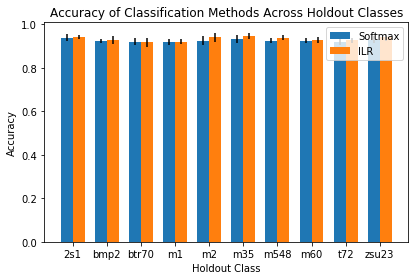

In [68]:
labels = [clsmap[i] for i in range(10)]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

STAT_accuracy_np = np.array(STAT_accuracy)
STAT_accuracy_means = STAT_accuracy_np.mean(axis=1)
STAT_accuracy_std = STAT_accuracy_np.std(axis=1)
STAT_ilr_accuracy_np = np.array(STAT_ilr_accuracy)
STAT_ilr_accuracy_means = STAT_ilr_accuracy_np.mean(axis=1)
STAT_ilr_accuracy_std = STAT_ilr_accuracy_np.std(axis=1)
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, STAT_accuracy_means, width,
                yerr=STAT_accuracy_std, label="Softmax")
rects2 = ax.bar(x + width/2, STAT_ilr_accuracy_means, width,
                yerr=STAT_ilr_accuracy_std, label="ILR")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_xlabel('Holdout Class')
ax.set_title('Accuracy of Classification Methods Across Holdout Classes')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

In [69]:
print("Average Softmax accuracy across holdout classes: ", STAT_accuracy_means.mean())
print("Average Softmax std across holdout classes: ", STAT_accuracy_std.mean())
print("Average ILR accuracy across holdout classes: ", STAT_ilr_accuracy_means.mean())
print("Average ILR std across holdout classes: ", STAT_ilr_accuracy_std.mean())

Average Softmax accuracy across holdout classes:  0.9263496656794599
Average Softmax std across holdout classes:  0.014391729658120573
Average ILR accuracy across holdout classes:  0.9333008814437157
Average ILR std across holdout classes:  0.014207119072825977


In [70]:
def getHistData(data, getDetAcc=False):
    tnr_mean = []
    tnr_std = []
    auroc_mean = []
    auroc_std = []
    dtacc_mean = []
    dtacc_std = []
    for i in range(10):
        temp_auroc = np.array(data[i]['holdout']['auroc'])
        temp_tnr = np.array(data[i]['holdout']['tnr'])
        temp_dtacc = np.array(data[i]['holdout']['dtacc'])
        auroc_mean.append(temp_auroc.mean())
        auroc_std.append(temp_auroc.std())
        tnr_mean.append(temp_tnr.mean())
        tnr_std.append(temp_tnr.std())
        if getDetAcc:
            dtacc_mean.append(temp_dtacc.mean())
            dtacc_std.append(temp_dtacc.std())
    tnr_mean = np.array(tnr_mean).mean()
    tnr_std = np.array(tnr_std).mean()
    auroc_mean = np.array(auroc_mean).mean()
    auroc_std = np.array(auroc_std).mean()
    if getDetAcc:
        dtacc_mean = np.array(dtacc_mean).mean()
        dtacc_std = np.array(dtacc_std).mean()
    else:
        dtacc_mean = 0.
        dtacc_std = 0.
    return tnr_mean, tnr_std, auroc_mean, auroc_std, dtacc_mean, dtacc_std

In [71]:
soft_base = getHistData(STAT_ood_baseline, getDetAcc=True)
soft_odin = getHistData(STAT_ood_odin, getDetAcc=True)
soft_odin_ipp = getHistData(STAT_ood_odin_ipp, getDetAcc=True)
soft_mahala = getHistData(STAT_ood_mahala, getDetAcc=True)
soft_mahala_ipp = getHistData(STAT_ood_mahala_ipp, getDetAcc=False)
ilr_base = getHistData(STAT_ilr_ood_baseline, getDetAcc=True)
ilr_odin = getHistData(STAT_ilr_ood_odin, getDetAcc=True)
ilr_odin_ipp = getHistData(STAT_ilr_ood_odin_ipp, getDetAcc=True)
ilr_mahala = getHistData(STAT_ilr_ood_mahala, getDetAcc=True)
ilr_mahala_ipp = getHistData(STAT_ilr_ood_mahala_ipp, getDetAcc=False)

soft_tnr_means = [soft_base[0], soft_odin[0], soft_odin_ipp[0], soft_mahala[0], soft_mahala_ipp[0]]
soft_tnr_std = [soft_base[1], soft_odin[1], soft_odin_ipp[1], soft_mahala[1], soft_mahala_ipp[1]]
soft_auroc_means = [soft_base[2], soft_odin[2], soft_odin_ipp[2], soft_mahala[2], soft_mahala_ipp[2]]
soft_auroc_std = [soft_base[3], soft_odin[3], soft_odin_ipp[3], soft_mahala[3], soft_mahala_ipp[3]]
soft_dtacc_means = [soft_base[4], soft_odin[4], soft_odin_ipp[4], soft_mahala[4]]
soft_dtacc_std = [soft_base[5], soft_odin[5], soft_odin_ipp[5], soft_mahala[5]]

ilr_tnr_means = [ilr_base[0], ilr_odin[0], ilr_odin_ipp[0], ilr_mahala[0], ilr_mahala_ipp[0]]
ilr_tnr_std = [ilr_base[1], ilr_odin[1], ilr_odin_ipp[1], ilr_mahala[1], ilr_mahala_ipp[1]]
ilr_auroc_means = [ilr_base[2], ilr_odin[2], ilr_odin_ipp[2], ilr_mahala[2], ilr_mahala_ipp[2]]
ilr_auroc_std = [ilr_base[3], ilr_odin[3], ilr_odin_ipp[3], ilr_mahala[3], ilr_mahala_ipp[3]]
ilr_dtacc_means = [ilr_base[4], ilr_odin[4], ilr_odin_ipp[4], ilr_mahala[4]]
ilr_dtacc_std = [ilr_base[5], ilr_odin[5], ilr_odin_ipp[5], ilr_mahala[5]]

In [72]:
soft_tnr_means

[0.17063889782928837,
 0.2315352455380831,
 0.2215320554727071,
 0.1462954407727758,
 0.148783819117958]

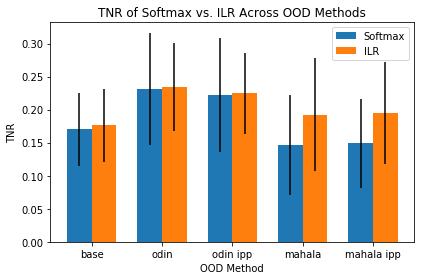

In [73]:
labels = ['base', 'odin', 'odin ipp', 'mahala', 'mahala ipp']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, soft_tnr_means, width,
                yerr=soft_tnr_std, label="Softmax")
rects2 = ax.bar(x + width/2, ilr_tnr_means, width,
                yerr=ilr_tnr_std, label="ILR")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('TNR')
ax.set_xlabel('OOD Method')
ax.set_title('TNR of Softmax vs. ILR Across OOD Methods')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

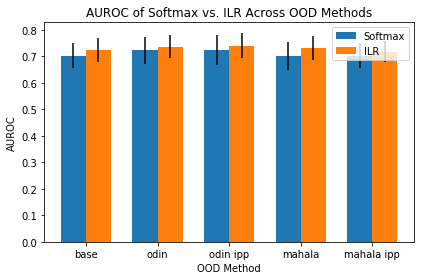

In [74]:
labels = ['base', 'odin', 'odin ipp', 'mahala', 'mahala ipp']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, soft_auroc_means, width,
                yerr=soft_auroc_std, label="Softmax")
rects2 = ax.bar(x + width/2, ilr_auroc_means, width,
                yerr=ilr_auroc_std, label="ILR")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('AUROC')
ax.set_xlabel('OOD Method')
ax.set_title('AUROC of Softmax vs. ILR Across OOD Methods')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

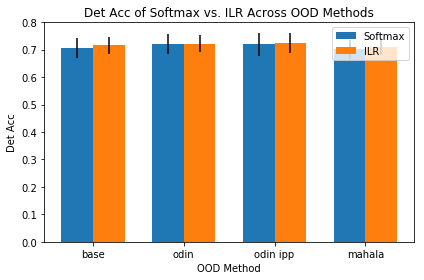

In [75]:
labels = ['base', 'odin', 'odin ipp', 'mahala']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, soft_dtacc_means, width,
                yerr=soft_dtacc_std, label="Softmax")
rects2 = ax.bar(x + width/2, ilr_dtacc_means, width,
                yerr=ilr_dtacc_std, label="ILR")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Det Acc')
ax.set_xlabel('OOD Method')
ax.set_title('Det Acc of Softmax vs. ILR Across OOD Methods')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()